In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import seaborn as sns
from sklearn.svm import SVR
from sklearn_evaluation import plot
from sklearn.externals import joblib
import seaborn
from math import sqrt

In [ ]:
#prediction of coal quality parameters (Ash, moisture, VM and GCV) from spectroscopic data
# regression methods - SVM, PLS, RF, XGBoost 

In [2]:

def svm_regression(df, df_id, n_components = 20):
    
    X = MinMaxScaler().fit_transform(df.iloc[:,1:-5].values)
    y = MinMaxScaler().fit_transform(df.iloc[:,-5:].values)
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20)
    
    pca = PCA(n_components)
    x_train = pca.fit_transform(X_train)
    x_test = pca.transform(X_test)


    param_grid = { 
         'C': [0.01, 0.1, 1, 10, 50],
         'kernel' : ['rbf', 'linear'],
        'gamma': [0.001, 0.01, 1, 10, 50]

    }

    for i in range(y_train.shape[1]):
        #model = SVR(kernel='linear', C=1, epsilon = .1, gamma='auto')
        clf = GridSearchCV(SVR(), param_grid, cv = 3, n_jobs = -1, scoring="neg_mean_squared_error")
        clf.fit(x_train, y_train[:,i])
        model = clf.best_estimator_
        print(clf.best_params_)
#         grid_scores = clf.cv_results_
#         changes = 'C', 'kernel', 'gamma'
#         plot.grid_search(clf.cv_results_, change='gamma', kind='bar')
        
        model.fit(x_train, y_train[:,i])
        Y_pred = model.predict(x_test)
        score = r2_score(y_test[:,i], Y_pred)
        mse = mean_squared_error(y_test[:,i], Y_pred)
        if i == 0:
            prop = 'ash content'
        elif i ==1:
            prop = 'moisture'
        elif i ==2:
            prop = 'volatile matter'
        elif i ==3:
            prop = 'fixed carbon'
        elif i ==4:
            prop = 'calorific value'
        print(prop, ': R_Square = ' + str(int(score*100)), ', error = ' + str(mse) +  ', training error = ' + str(mean_squared_error(y_train[:,i], model.predict(x_train))))
        fig, ax = plt.subplots()
        #ax.plot(Y_pred, y_test)
        ax.scatter(Y_pred, y_test[:,i])
        plt.show()
        #joblib.dump(model, 'my_model_svm_' + prop + '_' + str(df_id) +'_' + str(int(mse*100)) + '_'+ '.pkl', compress=9)


In [3]:
def pls_regression(df, df_id):
    X =  MinMaxScaler().fit_transform(df.iloc[:,1:-5].values)
    y =  MinMaxScaler().fit_transform(df.iloc[:,-5:].values)
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20)

    param_grid = { 
         'n_components': [2, 5,10,15,20,30,40],
          'scale' : ['True']
    }


    x_train, x_test = X_train, X_test


    for i in range(y_train.shape[1]):

        
        clf = GridSearchCV(PLSRegression(), param_grid, cv = 5, n_jobs = -1, scoring="neg_mean_squared_error")
        clf.fit(x_train, y_train[:,i])
        model = clf.best_estimator_
        grid_scores = clf.cv_results_
        plot.grid_search(grid_scores, change='n_components', kind='bar')
        model.fit(x_train, y_train[:,i])
        Y_pred = model.predict(x_test)
        score = r2_score(y_test[:,i], Y_pred)
        mse = mean_squared_error(y_test[:,i], Y_pred)
        if i == 0:
            prop = 'ash content'
        elif i ==1:
            prop = 'moisture'
        elif i ==2:
            prop = 'volatile matter'
        elif i ==3:
            prop = 'fixed carbon'
        elif i ==4:
            prop = 'calorific value'
        print(prop, ': R_Square = ' + str(int(score*100)), ', error = ' + str(mse) +  ', training error = ' + str(mean_squared_error(y_train[:,i], model.predict(X_train))))
        fig, ax = plt.subplots()
        #ax.plot(Y_pred, y_test)
        ax.scatter(y_test[:,i], Y_pred)
        plt.show()
        seaborn.residplot(y_test[:,i], Y_pred)
        plt.show()
        
        
        y_pred_train = model.predict(X_train)
        temp_np1 = np.vstack((y_train[:,i], y_pred_train[:,0]))
        temp_np2 = np.vstack((y_test[:,i], Y_pred[:,0]))
        temp_np = np.hstack((temp_np1, temp_np2))
        df_temp = pd.DataFrame(temp_np2)
        filename = prop + '_' + str(df_id) + '_' + 'pls_' + str(sqrt(mse))+ '.csv'
        df_temp.to_csv('./results/' + filename,index=False)
        
        #joblib.dump(pls_clf, 'my_model_pls_' + prop + '_' + str(df_id) + '_' + str(int(mse*100)) + '_'+ '.pkl', compress=9)


In [4]:
def randomforest_regression(df, df_id, n_components = 20, PCA_ = 'True'):
    df_x = df.iloc[:,1:-5]
    
    importance_pd = pd.Series(index=df_x.columns).fillna(0)
    X = MinMaxScaler().fit_transform(df.iloc[:,1:-5].values)
    y = MinMaxScaler().fit_transform(df.iloc[:,-5:].values)
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20)
    pca = PCA(n_components)
    x_train = pca.fit_transform(X_train)
    x_test = pca.transform(X_test)
    

    param_grid = {
            'n_estimators': [1000, 3000], 
            'criterion' : ['mse'],
            'max_depth' : [10, 50, 200, 500],
            'min_samples_split' : [2, 5], 
            'min_samples_leaf' : [2], 
            'max_features' : [.1, .3, .7, .99]
            }
    if PCA_ != 'True':
        x_train, x_test = X_train, X_test
        param_grid = {
            'n_estimators': [50, 500], 
            'criterion' : ['mse'],
            'max_depth' : [10, 50],
            'min_samples_split' : [2, 5], 
            'min_samples_leaf' : [2], 
            'max_features' : [.1, .7]
            }
        
    for i in range(y_train.shape[1]):
        clf = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5, n_jobs = -1, scoring="neg_mean_squared_error")
        clf.fit(x_train, y_train[:,i])
        model = clf.best_estimator_
        print(clf.best_params_)
        grid_scores = clf.cv_results_
        model.fit(x_train, y_train[:,i])
        
        if PCA_!= 'True':
            #df1 = df.iloc[:,1:-5]
            #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
            importances = pd.Series(model.feature_importances_, index=df_x.columns)
            importance_pd = importance_pd + importances
            #importances.nlargest(20).plot(kind='barh')
            #plt.show()
            
        Y_pred = model.predict(x_test)
        score = r2_score(y_test[:,i], Y_pred)
        mse = mean_squared_error(y_test[:,i], Y_pred)
        if i == 0:
            prop = 'ash content'
        elif i ==1:
            prop = 'moisture'
        elif i ==2:
            prop = 'volatile matter'
        elif i ==3:
            prop = 'fixed carbon'
        elif i ==4:
            prop = 'calorific value'
        print(prop, ': R_Square = ' + str(int(score*100)), ', error = ' + str(mse) +  ', training error = ' + str(mean_squared_error(y_train[:,i], model.predict(x_train))))
        fig, ax = plt.subplots()
        #ax.plot(Y_pred, y_test)
        ax.scatter(Y_pred, y_test[:,i])
        plt.show()
        seaborn.residplot(y_test[:,i], Y_pred)
        plt.show()
        
        y_pred_train = model.predict(x_train)
        temp_np1 = np.vstack((y_train[:,i], y_pred_train))
        temp_np2 = np.vstack((y_test[:,i], Y_pred))
        temp_np = np.hstack((temp_np1, temp_np2))
        df_temp = pd.DataFrame(temp_np2)
        filename = prop + '_' + str(df_id) + '_' + 'rf_' + str(sqrt(mse))+ '.csv'
        df_temp.to_csv('./results/' + filename,index=False)
        #joblib.dump(model, 'my_model_rf_' + prop + '_' + str(df_id) + '_' + str(int(mse*100)) + '_'+'.pkl', compress=9)
    importance_pd.nlargest(20).plot(kind='barh')


In [6]:
def xgb_regression(df, df_id, n_components = 20, PCA_ = 'True'):
    df_x = df.iloc[:,1:-5]
    importance_pd = pd.Series(index=df_x.columns).fillna(0)
    X = MinMaxScaler().fit_transform(df.iloc[:,1:-5].values)
    y = MinMaxScaler().fit_transform(df.iloc[:,-5:].values)
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20)
    pca = PCA(n_components)
    x_train = pca.fit_transform(X_train)
    x_test = pca.transform(X_test)

    param_grid =  {
                  'learning_rate': [.005], #so called `eta` value
                  'max_depth': [2, 5],
                  'min_child_weight': [4],
                  'subsample': [0.6],
                  'colsample_bytree': [0.8],
                  'n_estimators': [3500, 2000],
                  }
    if PCA_ != 'True':
        x_train, x_test = X_train, X_test
        param_grid = {
            'learning_rate': [.001], #so called `eta` value
            'max_depth': [5, 8],
            'min_child_weight': [2],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'n_estimators': [2000],
            }
    for i in range(y_train.shape[1]):
        clf = GridSearchCV(xgb.XGBRegressor(objective = 'reg:squarederror', silent = 1, nthread = 4, tree_method = 'gpu_hist'), param_grid, cv = 5, scoring="neg_mean_squared_error")
        clf.fit(x_train, y_train[:,i])
        print(clf.best_params_)
        grid_scores = clf.cv_results_
        model = clf.best_estimator_
        #model = GradientBoostingRegressor(n_estimators=100, max_depth = 10, subsample = .1)
        model.fit(x_train, y_train[:,i])
        if PCA_!= 'True':
            #df1 = df.iloc[:,1:-5]
            #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
            importances = pd.Series(model.feature_importances_, index=df_x.columns)
            importance_pd = importance_pd + importances
            #importances.nlargest(20).plot(kind='barh')
            #plt.show()
        
        Y_pred = model.predict(x_test)
        score = r2_score(y_test[:,i], Y_pred)
        mse = mean_squared_error(y_test[:,i], Y_pred)
        if i == 0:
            prop = 'ash content'
        elif i ==1:
            prop = 'moisture'
        elif i ==2:
            prop = 'volatile matter'
        elif i ==3:
            prop = 'fixed carbon'
        elif i ==4:
            prop = 'calorific value'
        print(prop, ': R_Square = ' + str(int(score*100)), ', error = ' + str(mse) +  ', training error = ' + str(mean_squared_error(y_train[:,i], model.predict(x_train))))
        fig, ax = plt.subplots()
        #ax.plot(Y_pred, y_test)
        ax.scatter(Y_pred, y_test[:,i])

        plt.show()
        seaborn.residplot(y_test[:,i], Y_pred)
        plt.show()
        
        y_pred_train = model.predict(x_train)
        temp_np1 = np.vstack((y_train[:,i], y_pred_train))
        temp_np2 = np.vstack((y_test[:,i], Y_pred))
        temp_np = np.hstack((temp_np1, temp_np2))
        df_temp = pd.DataFrame(temp_np2)
        filename = prop + '_' + str(df_id) + '_' + 'xgb_' + str(sqrt(mse))+ '.csv'
        df_temp.to_csv('./results/' + filename,index=False)
        #joblib.dump(model, 'my_model_xgb_' + prop + '_' + str(df_id)+'_' + str(int(mse*100)) + '_'+ '.pkl', compress=9)
    importance_pd.nlargest(30).plot(kind='barh')


removed outliers : 7
removed outliers : 7


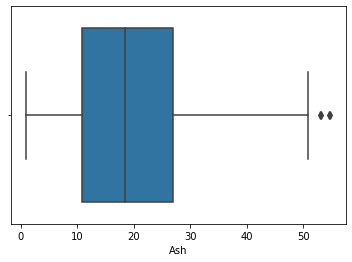

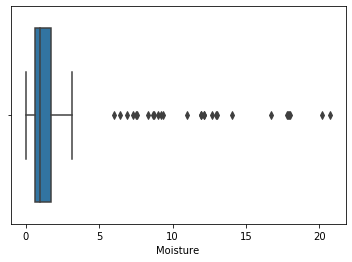

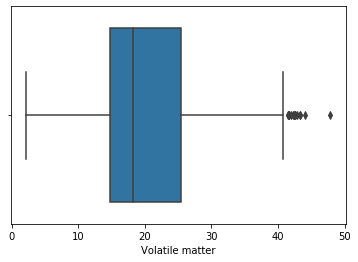

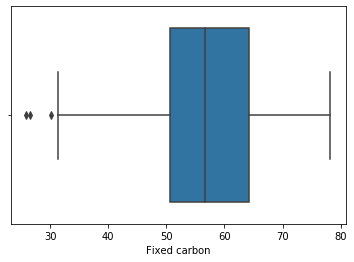

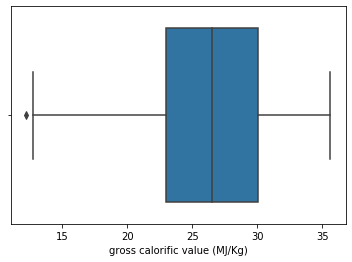

In [2]:
xls = pd.ExcelFile('Data for modelling-5.8.19.xlsx')
df1 = pd.read_excel(xls, 'Abs-SG+RNr')
df2 = pd.read_excel(xls, 'Abs-SG+BC+RNr+MSC')

prev_shape1 = (df1.shape[0])
prev_shape2 = (df2.shape[0])
for i in range(5):
    z = np.abs(stats.zscore(df1.iloc[:,-5+i].values))
    threshold = 3
    idx = (np.where(z > threshold)[0])
    indexes_to_keep = set(range(df1.shape[0])) - set(idx)
    df1 = df1.take(list(indexes_to_keep))
now_shape = (df1.shape[0])
print('removed outliers : ' + str(prev_shape1 - now_shape))
for i in range(5):
    z = np.abs(stats.zscore(df2.iloc[:,-5+i].values))
    threshold = 3
    idx = (np.where(z > threshold)[0])
    indexes_to_keep = set(range(df2.shape[0])) - set(idx)
    df2 = df2.take(list(indexes_to_keep))
now_shape = (df2.shape[0])
print('removed outliers : ' + str(prev_shape2 - now_shape))
(sns.boxplot(x=df1.iloc[:,-5]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-4]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-3]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-2]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-1]))
pyplot.show()

In [8]:
print('Ash: (max, min, mean) = (' + str(df1.iloc[:,-5].max()) + ' , ' + str(df1.iloc[:,-5].min()) + ' , ' + str(df1.iloc[:,-5].mean()) + str(' )'))
print('Moisture: (max, min, mean) = (' + str(df1.iloc[:,-4].max()) + ' , ' + str(df1.iloc[:,-4].min())+ ' , ' + str(df1.iloc[:,-4].mean())+ str(' )'))
print('VM: (max, min, mean) = (' + str(df1.iloc[:,-3].max()) + ' , ' + str(df1.iloc[:,-3].min()) + ' , ' + str(df1.iloc[:,-3].mean()) + str(' )'))
print('FC: (max, min, mean) = (' + str(df1.iloc[:,-2].max()) + ' , ' + str(df1.iloc[:,-2].min()) +' , ' + str(df1.iloc[:,-2].mean()) + str(' )'))
print('GCV: (max, min, mean) = (' + str(df1.iloc[:,-1].max()) + ' , ' + str(df1.iloc[:,-1].min()) +' , ' + str(df1.iloc[:,-1].mean()) + str(' )'))

Ash: (max, min, mean) = (54.77 , 0.9 , 19.68808487804878 )
Moisture: (max, min, mean) = (20.74 , 0.02 , 2.4985073170731713 )
VM: (max, min, mean) = (47.86 , 2.1499999999999995 , 21.50388292682927 )
FC: (max, min, mean) = (78.21000000000001 , 25.849999999999994 , 56.30401268292684 )
GCV: (max, min, mean) = (35.60596412139999 , 12.213600422999999 , 26.179338394416778 )


ash content : R_Square = 69 , error = 0.01572992337779832, training error = 0.004655967962365807


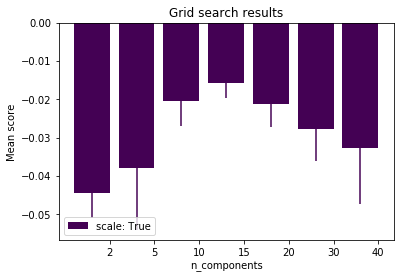

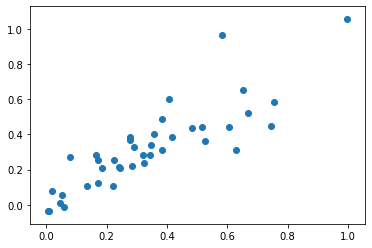

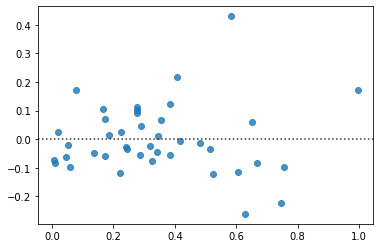

moisture : R_Square = 78 , error = 0.007709006106724983, training error = 0.00520424958918163


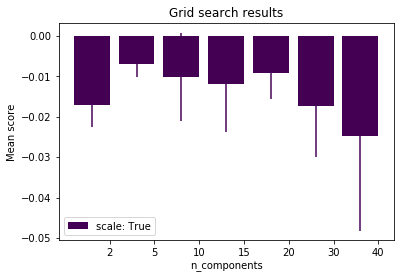

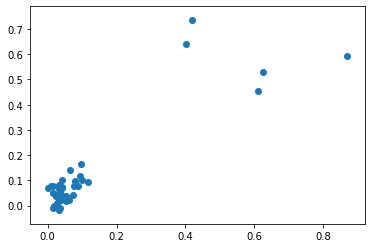

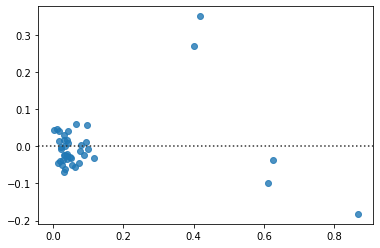

volatile matter : R_Square = 90 , error = 0.004887054296885529, training error = 0.003989729149149547


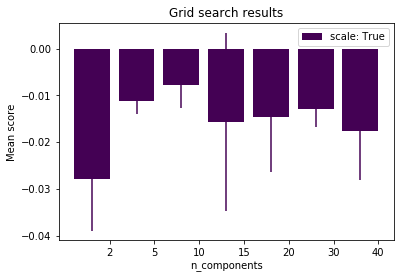

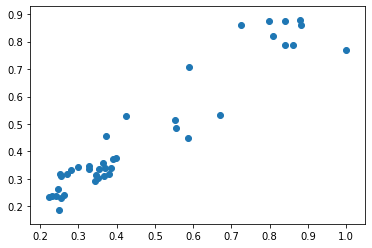

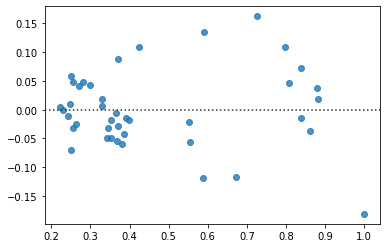

fixed carbon : R_Square = 65 , error = 0.016237274089497877, training error = 0.012156088982655045


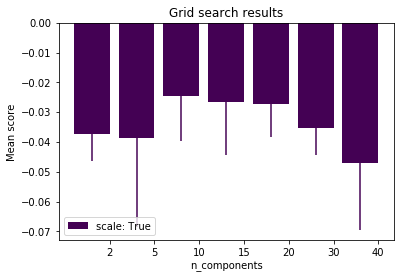

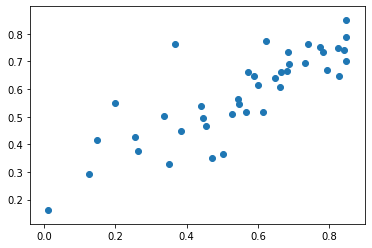

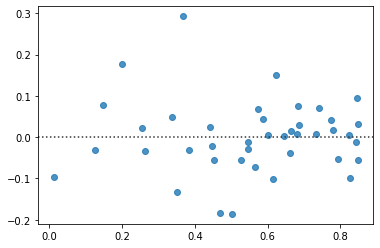

calorific value : R_Square = 59 , error = 0.020283479484532754, training error = 0.00140112919298384


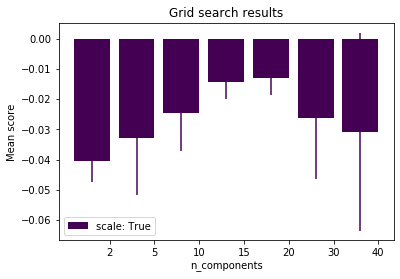

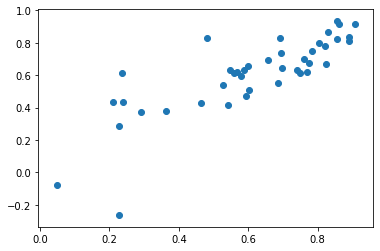

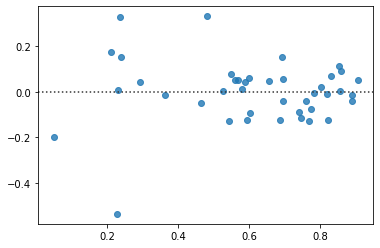

In [32]:
pls_regression(df1, 1)

ash content : R_Square = 54 , error = 0.023839007135239385, training error = 0.008977858150644733


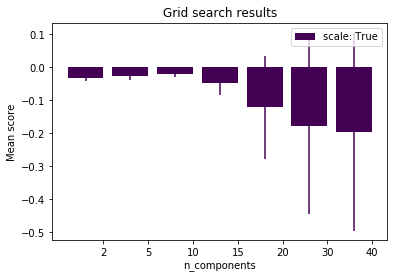

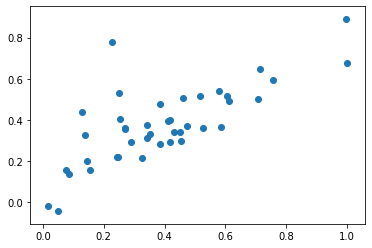

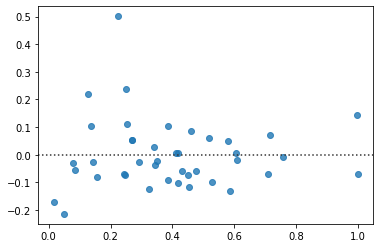

moisture : R_Square = 90 , error = 0.005015504522284295, training error = 0.003175328883478054


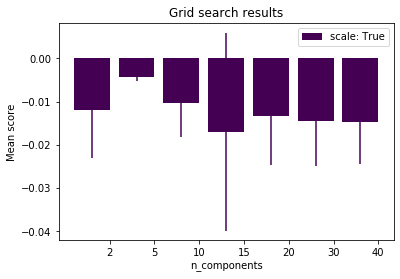

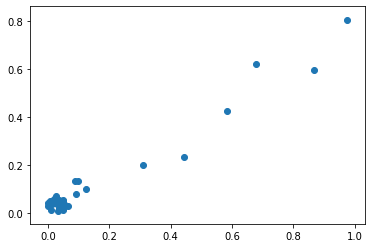

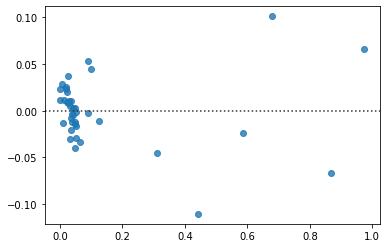

volatile matter : R_Square = 78 , error = 0.006625091391729741, training error = 0.0032792301878555885


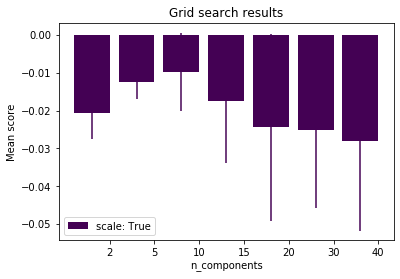

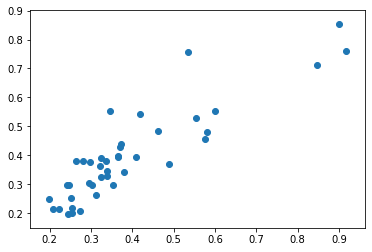

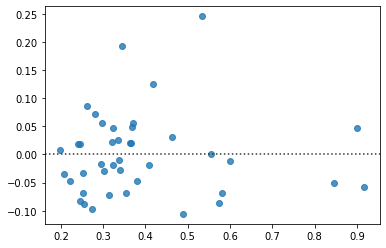

fixed carbon : R_Square = 20 , error = 0.03652003255317869, training error = 0.016057881879082435


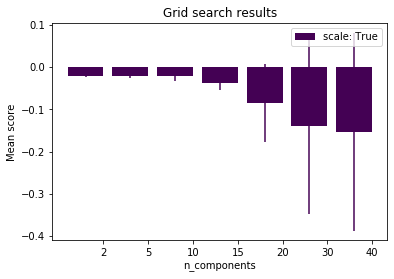

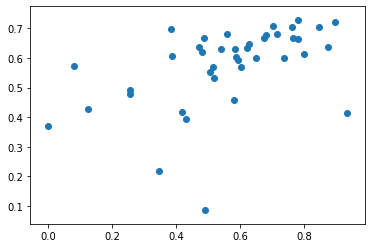

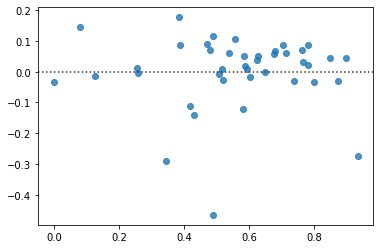

calorific value : R_Square = 28 , error = 0.03070153548495977, training error = 0.00834920154500661


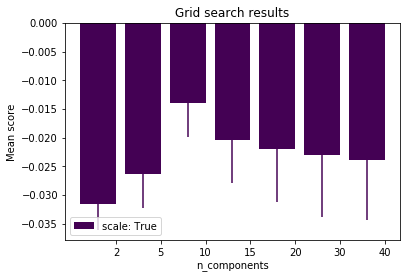

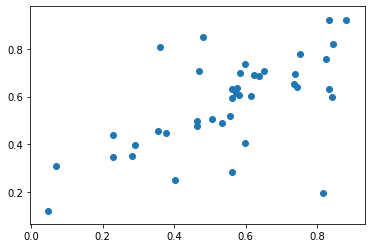

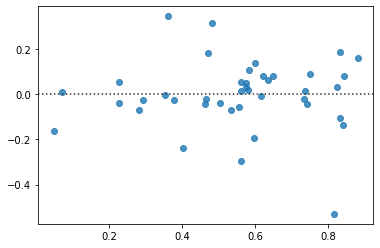

In [33]:
pls_regression(df2, 2)

In [8]:
#svm_regression(df1, 1)

In [9]:
#svm_regression(df2, 2)

{'criterion': 'mse', 'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
ash content : R_Square = 41 , error = 0.03889275637572021, training error = 0.008921281008620625


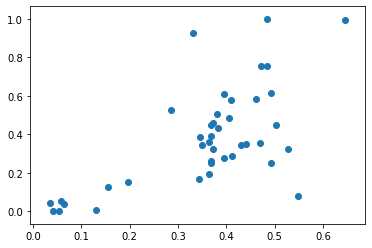

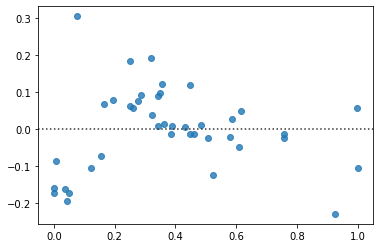

{'criterion': 'mse', 'max_depth': 50, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
moisture : R_Square = 78 , error = 0.006239256806680328, training error = 0.0033223092581928263


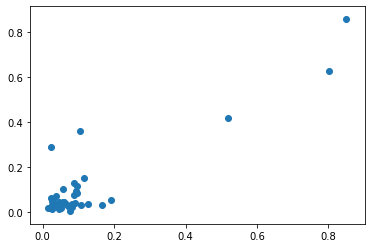

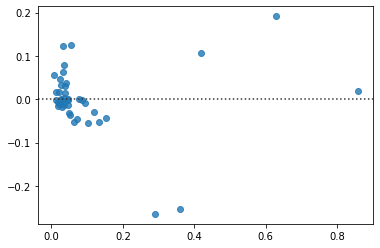

{'criterion': 'mse', 'max_depth': 50, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
volatile matter : R_Square = 80 , error = 0.010642114724648204, training error = 0.0028168004517103123


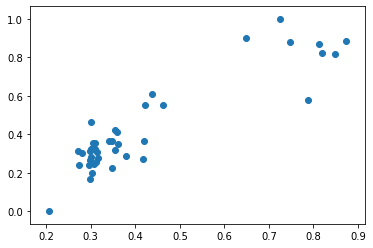

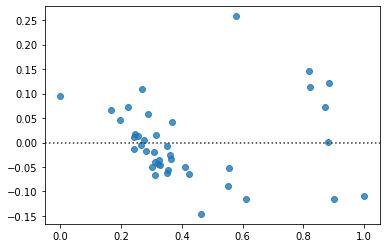

{'criterion': 'mse', 'max_depth': 50, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
fixed carbon : R_Square = 21 , error = 0.03350780591615518, training error = 0.00817995591015223


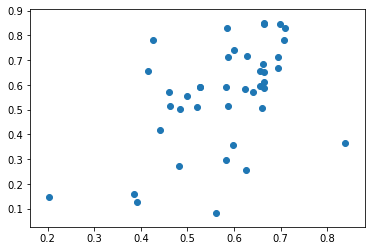

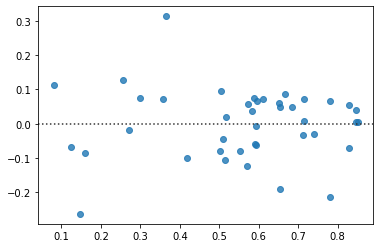

{'criterion': 'mse', 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
calorific value : R_Square = 25 , error = 0.04108505946454462, training error = 0.009663932699087758


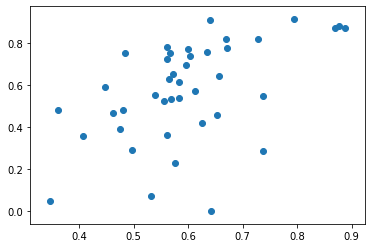

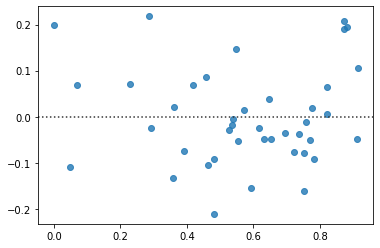

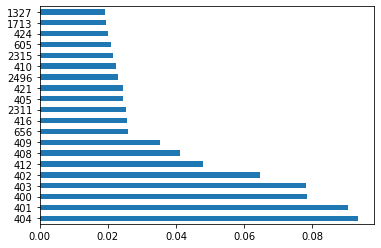

In [25]:
randomforest_regression(df1, 1)

{'criterion': 'mse', 'max_depth': 50, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
ash content : R_Square = 40 , error = 0.03515012838283542, training error = 0.004016919772528966


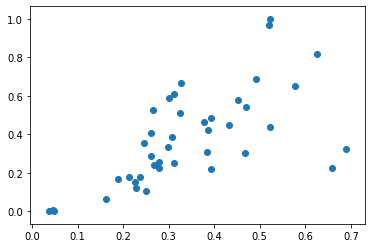

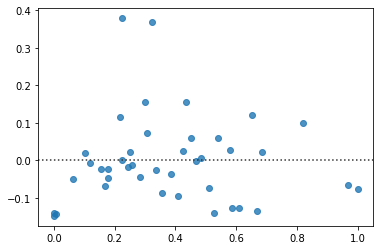

{'criterion': 'mse', 'max_depth': 50, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
moisture : R_Square = 92 , error = 0.0022154339430970533, training error = 0.0012970885004171982


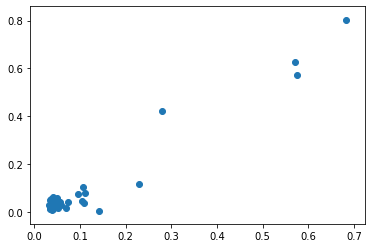

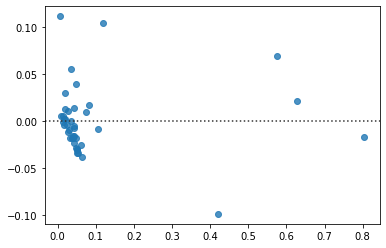

{'criterion': 'mse', 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
volatile matter : R_Square = 87 , error = 0.00426180471190314, training error = 0.0017146998162440006


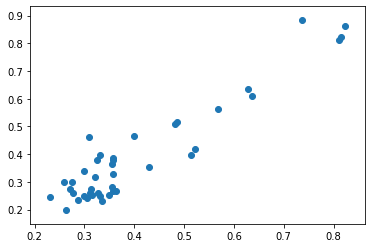

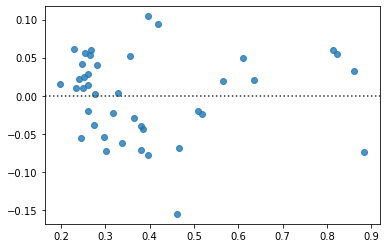

{'criterion': 'mse', 'max_depth': 50, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
fixed carbon : R_Square = 33 , error = 0.024857950586002084, training error = 0.003876359280535447


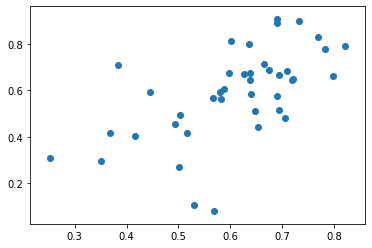

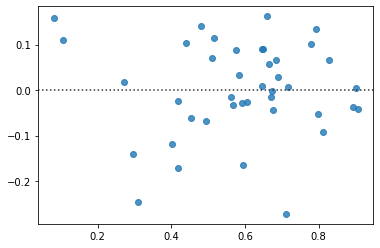

{'criterion': 'mse', 'max_depth': 50, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
calorific value : R_Square = 44 , error = 0.02909335069698811, training error = 0.004022816395479851


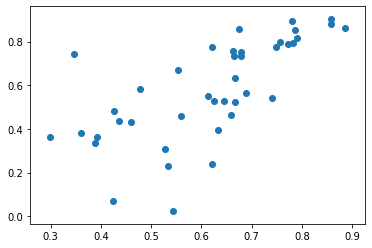

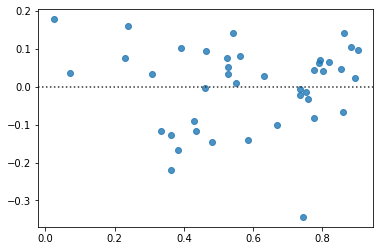

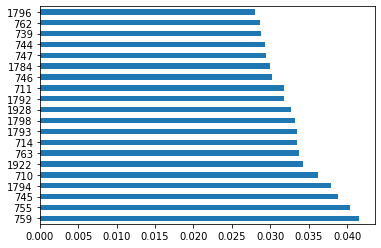

In [26]:
randomforest_regression(df2, 2)

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
ash content : R_Square = 22 , error = 0.03995706424710886, training error = 0.013688108338049603


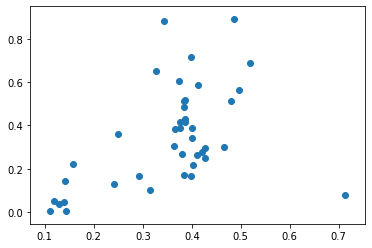

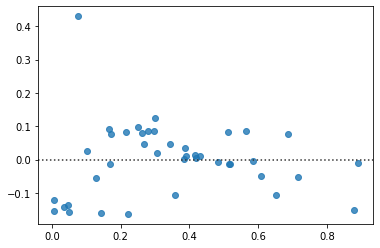

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
moisture : R_Square = 36 , error = 0.010370366357906932, training error = 0.007158548181264562


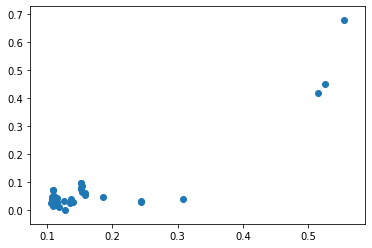

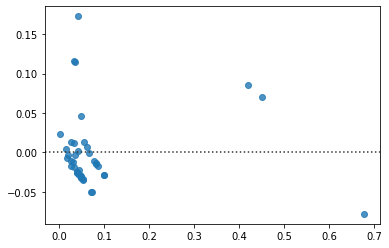

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
volatile matter : R_Square = 72 , error = 0.014980372777534593, training error = 0.004206773962624813


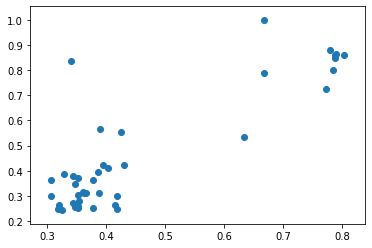

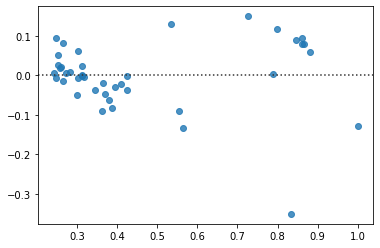

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
fixed carbon : R_Square = 15 , error = 0.031537433174199284, training error = 0.0070525297702204144


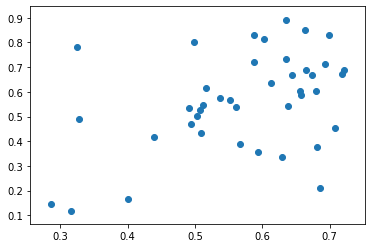

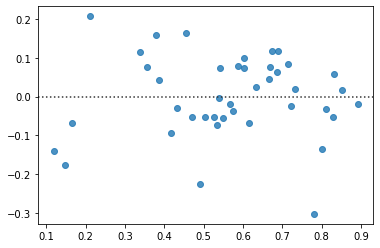

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
calorific value : R_Square = 15 , error = 0.03163462667503371, training error = 0.010050147443455964


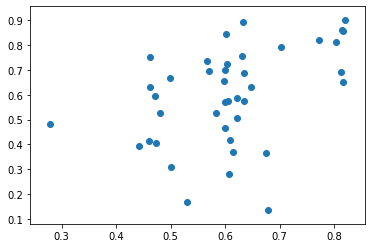

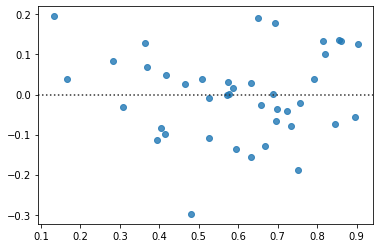

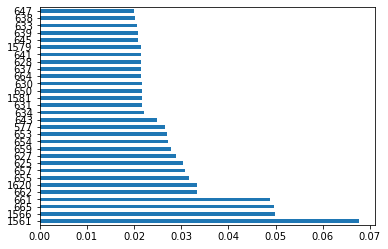

In [19]:
xgb_regression(df1, 1)

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
ash content : R_Square = 38 , error = 0.02231553963070488, training error = 0.004610014623918698


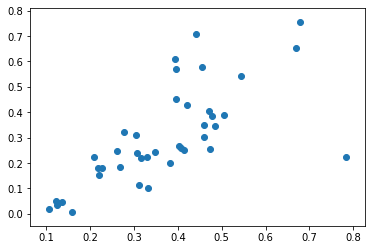

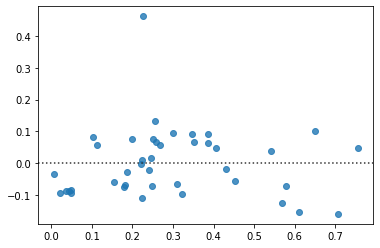

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
moisture : R_Square = 81 , error = 0.005718282368264159, training error = 0.004671654901009058


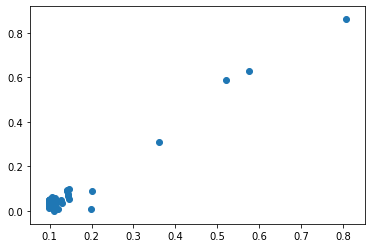

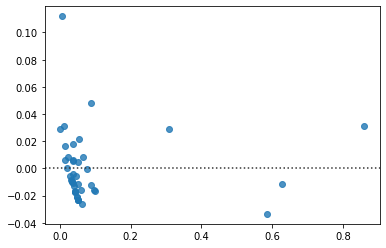

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
volatile matter : R_Square = 84 , error = 0.0077153486040874315, training error = 0.002562876300707405


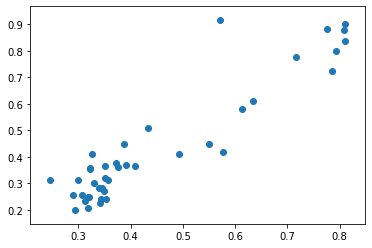

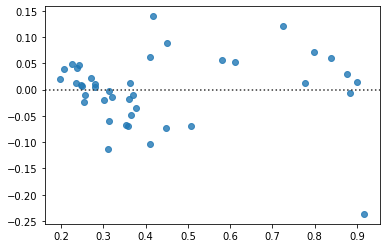

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
fixed carbon : R_Square = 41 , error = 0.02244562683326673, training error = 0.004196841437757864


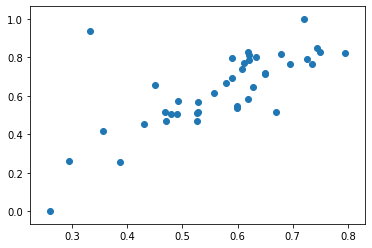

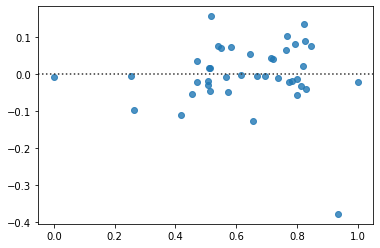

{'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8}
calorific value : R_Square = 23 , error = 0.025102334239461458, training error = 0.003911286209314936


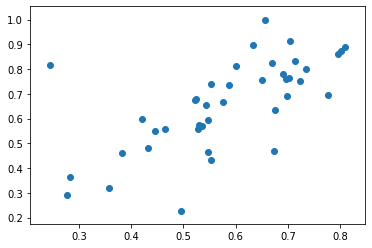

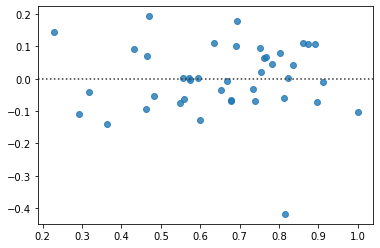

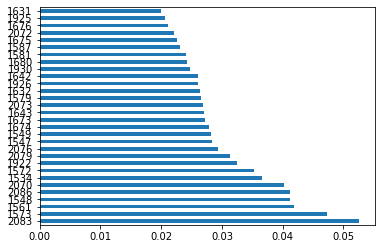

In [20]:
xgb_regression(df2, 2)

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 62 , error = 0.01884316762572457, training error = 0.0012565548174300392


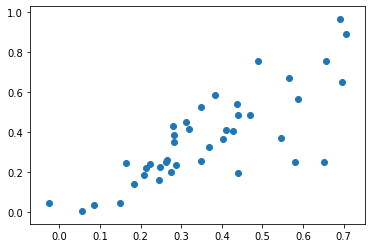

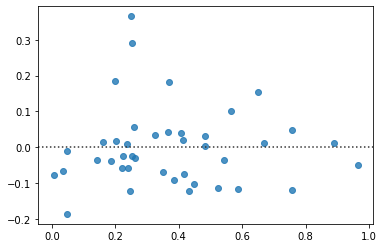

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 76 , error = 0.010091536127152016, training error = 0.0005374832690037025


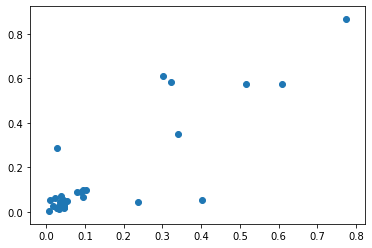

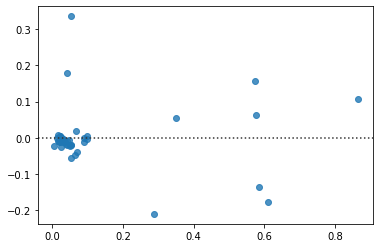

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 89 , error = 0.004537951591295943, training error = 6.421066840872993e-05


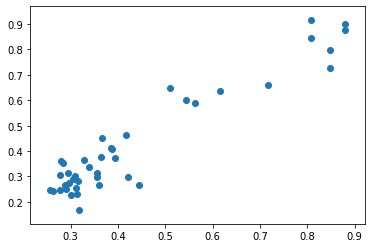

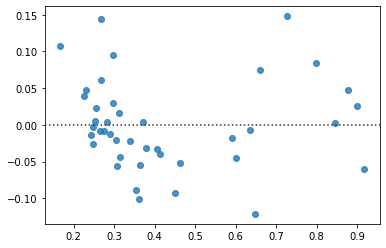

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 66 , error = 0.011049961406647837, training error = 0.0003336085200774547


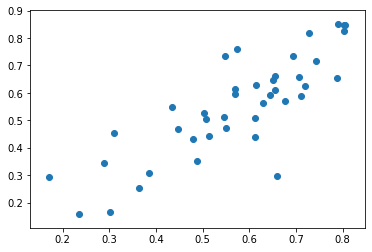

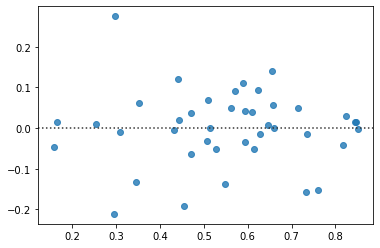

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 69 , error = 0.011846562658572585, training error = 3.866249716339662e-05


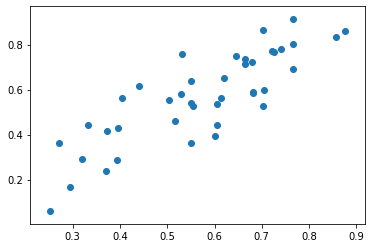

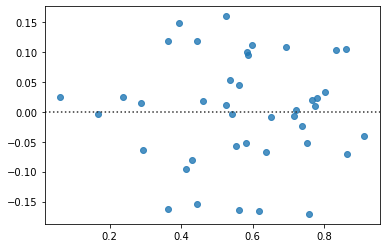

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 76 , error = 0.008079036495483315, training error = 0.00024123298456143832


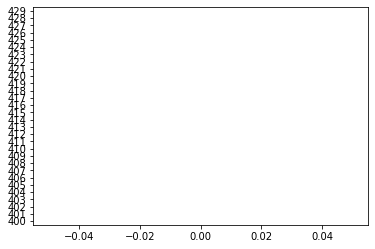

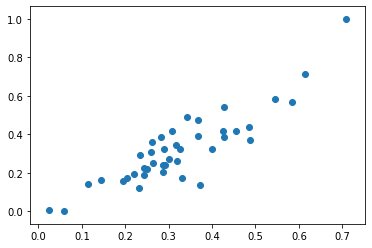

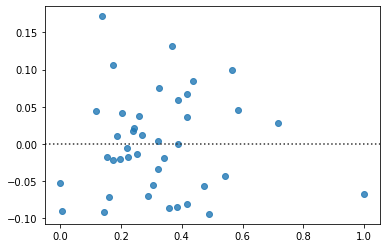

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 82 , error = 0.005271576652324378, training error = 0.00020027124478028948


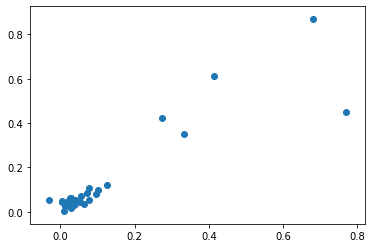

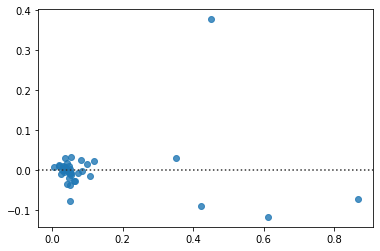

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 83 , error = 0.005288100540035483, training error = 0.00032710435119540597


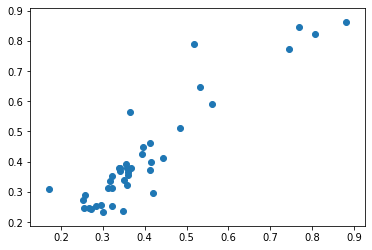

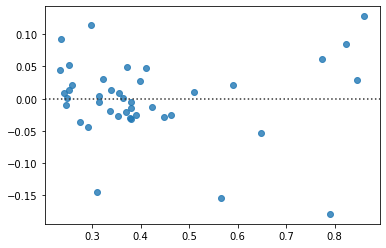

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 64 , error = 0.014423641520830957, training error = 0.00363417640131982


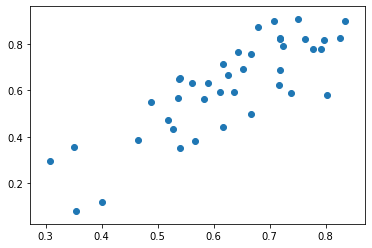

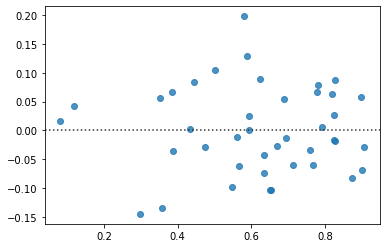

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 69 , error = 0.01123226002589647, training error = 0.00032936301617538823


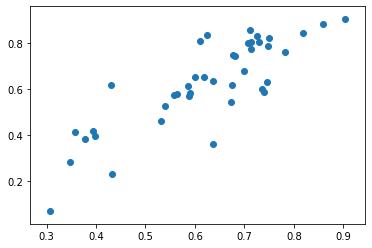

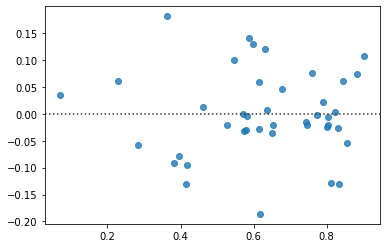

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 58 , error = 0.016947717143306666, training error = 0.0002443109304421671


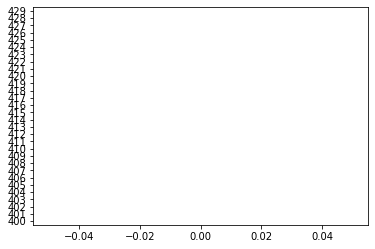

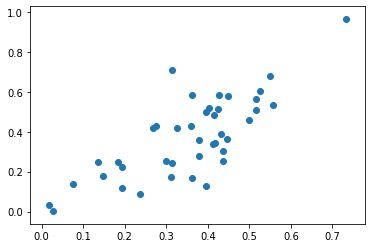

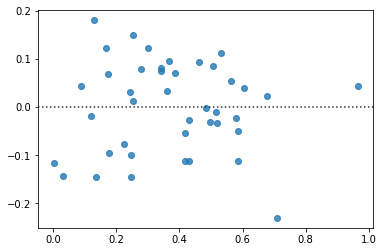

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 86 , error = 0.007358735828743185, training error = 0.00017145864634485964


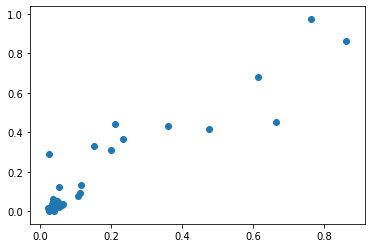

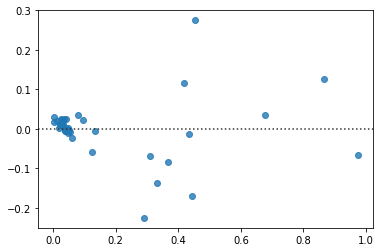

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 73 , error = 0.010389385749068178, training error = 0.0013419500109881312


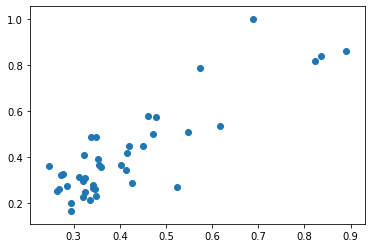

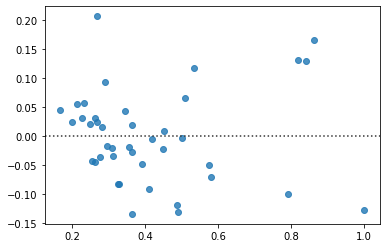

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 55 , error = 0.020251783575780447, training error = 0.00019420193258893389


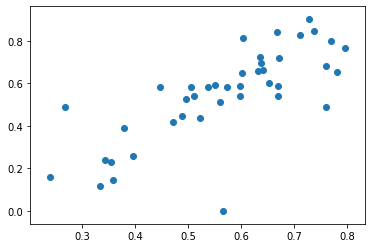

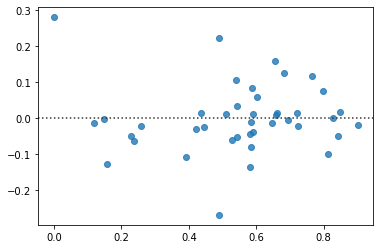

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 72 , error = 0.010611599575305549, training error = 0.0002866413345170296


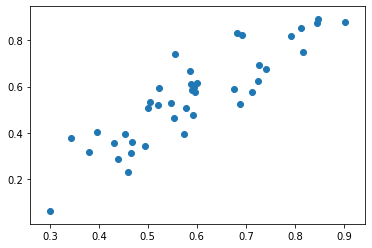

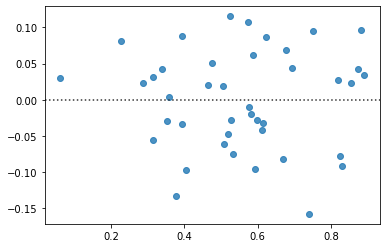

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 63 , error = 0.021057684757601745, training error = 3.16258891720797e-05


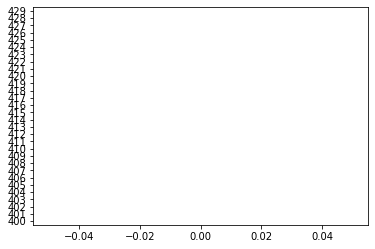

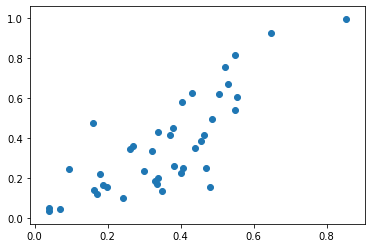

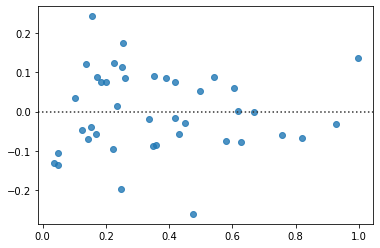

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 74 , error = 0.012898963785718875, training error = 0.00014179842023071812


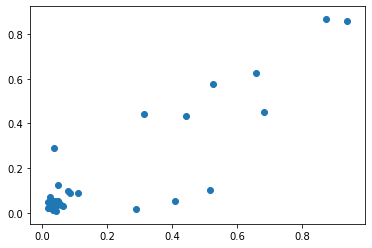

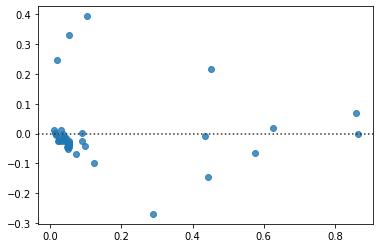

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 73 , error = 0.011577386344572163, training error = 0.0004320059213999581


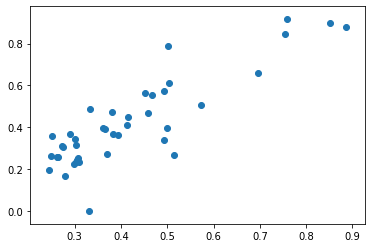

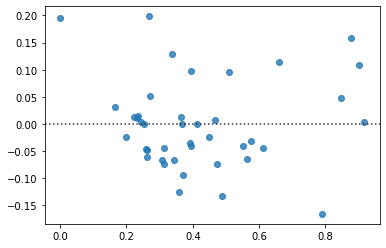

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 55 , error = 0.02124565292161737, training error = 0.00048792142952764234


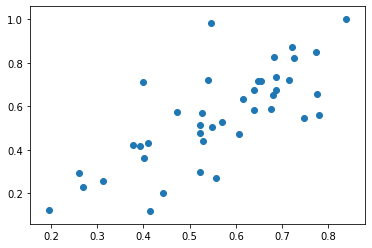

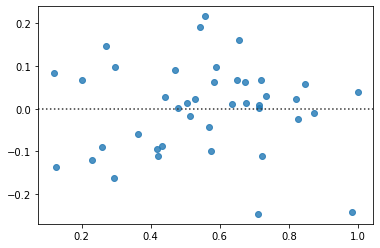

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 59 , error = 0.022537969078124886, training error = 0.00018183926020884898


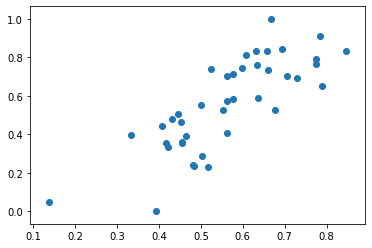

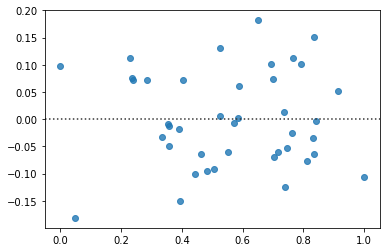

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 47 , error = 0.017353324521125698, training error = 0.0012266854170869302


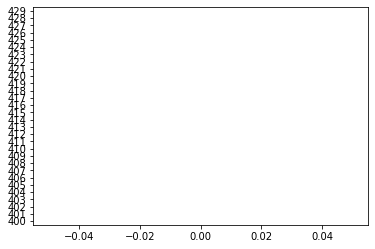

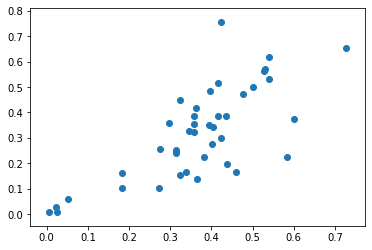

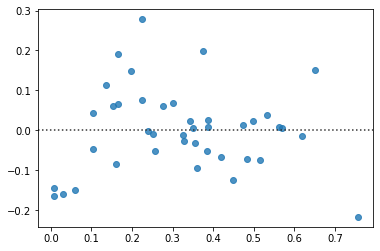

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 79 , error = 0.003993882646078691, training error = 0.0008173123977563215


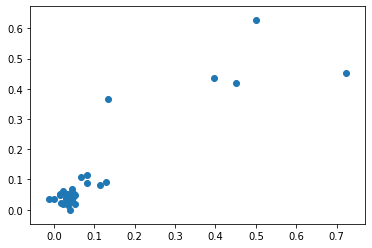

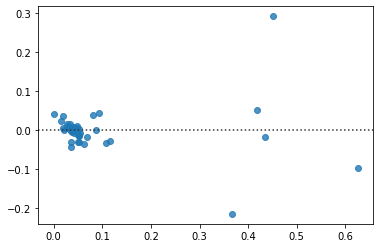

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 85 , error = 0.006892977714503897, training error = 4.662673200284175e-05


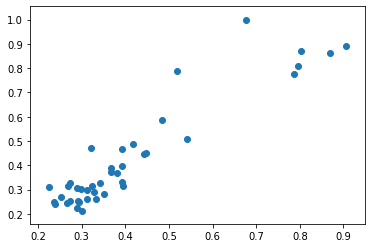

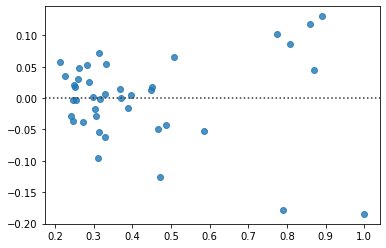

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 62 , error = 0.016504356587743574, training error = 0.00038586797997157326


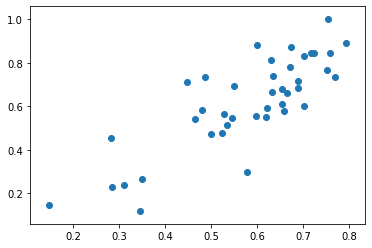

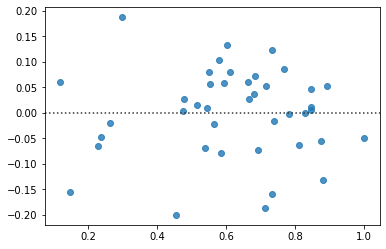

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 62 , error = 0.01158632946339756, training error = 0.00028928392979162216


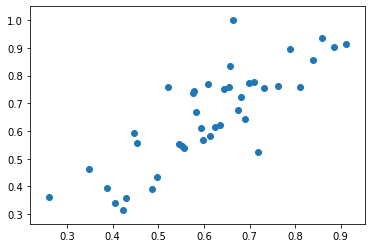

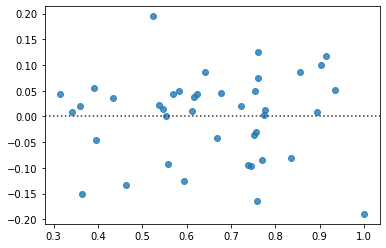

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 70 , error = 0.012791267598884853, training error = 0.00018410670896292002


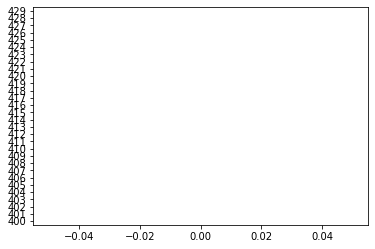

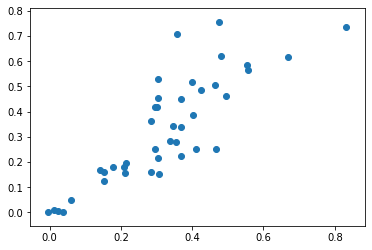

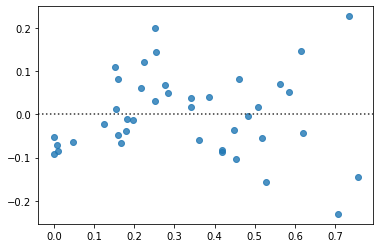

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 92 , error = 0.0031919191468363687, training error = 0.00025817213268918357


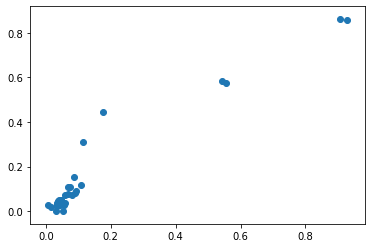

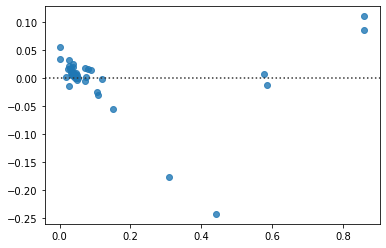

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 78 , error = 0.009810844055925876, training error = 4.96450255572707e-05


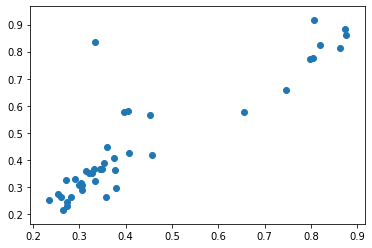

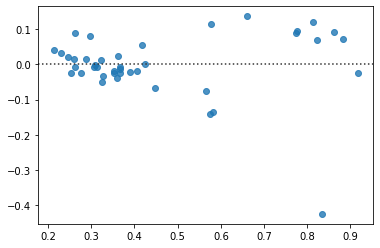

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 54 , error = 0.016614588835217606, training error = 0.0002236449522042679


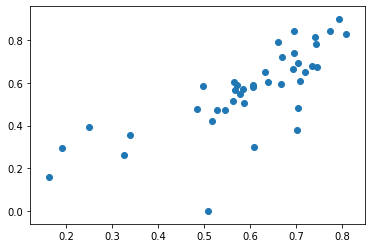

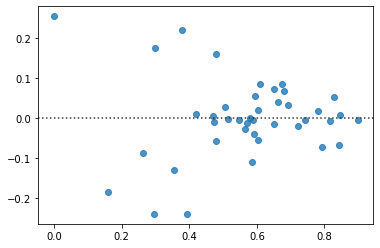

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 82 , error = 0.00538740416983575, training error = 0.00026309678902392296


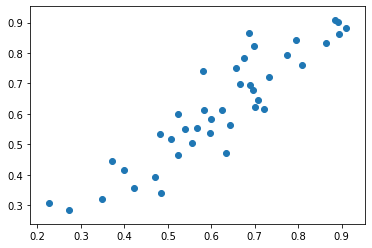

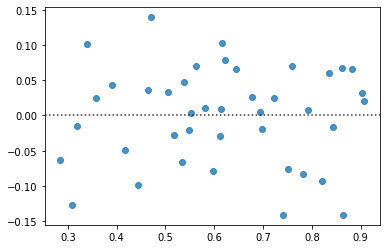

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 81 , error = 0.011683867235231564, training error = 0.0013145805221884094


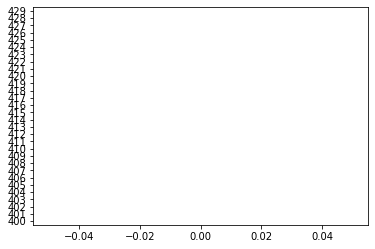

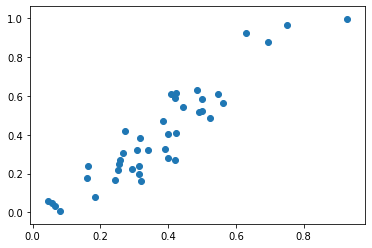

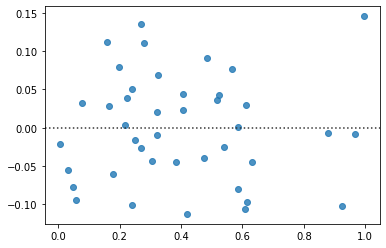

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 78 , error = 0.005238890163721056, training error = 0.0006479746185445853


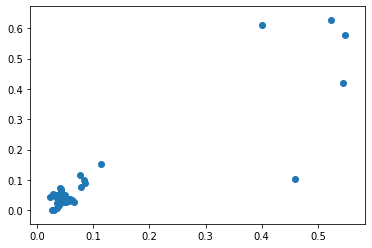

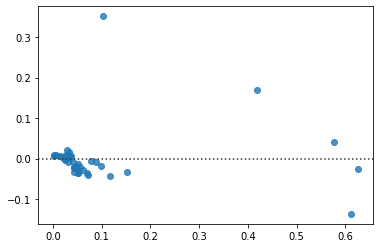

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 83 , error = 0.007792233568882396, training error = 0.000279516441026805


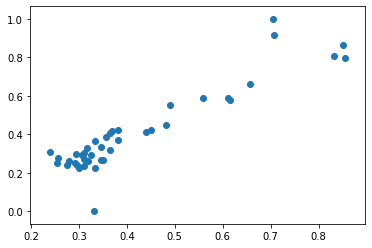

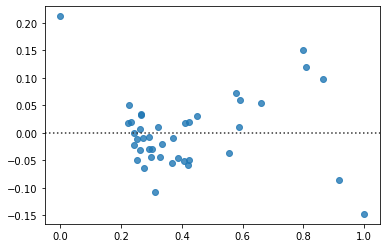

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 77 , error = 0.010383758415105339, training error = 0.0002933571306373524


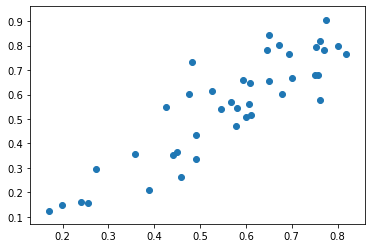

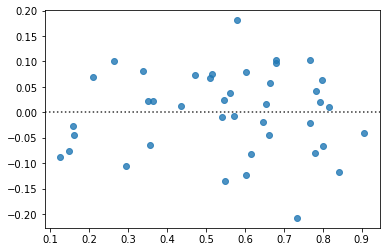

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 65 , error = 0.01811222472091228, training error = 0.00015652942941710732


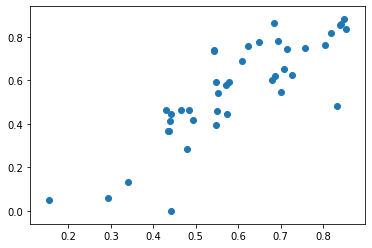

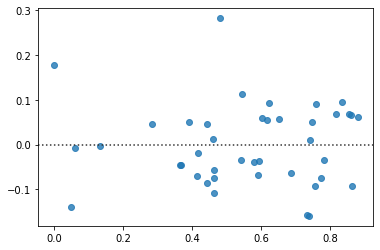

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 64 , error = 0.021421123999533703, training error = 0.0027797443486990447


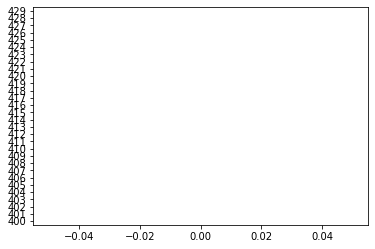

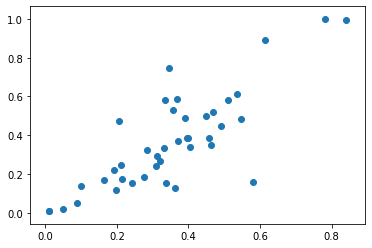

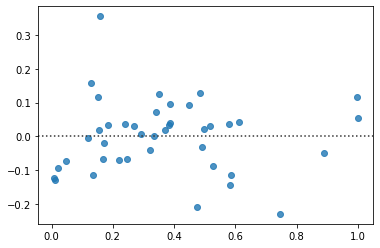

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 86 , error = 0.004415864867287943, training error = 0.0005774827581463225


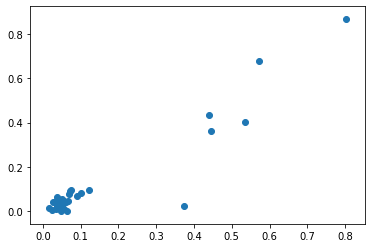

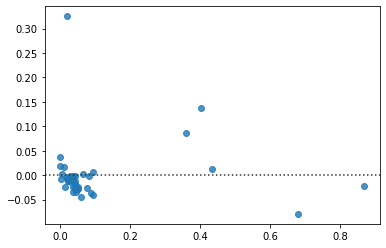

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 88 , error = 0.004505011535513123, training error = 4.2534128459774464e-05


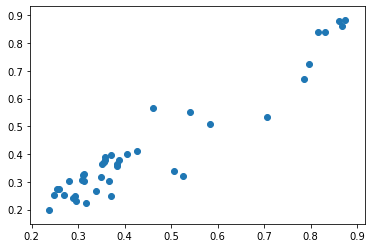

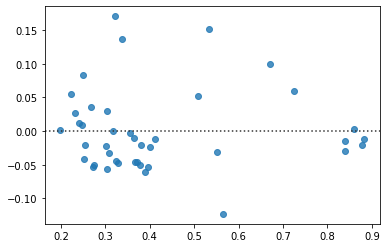

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 52 , error = 0.024442697712430208, training error = 0.0033676682860738325


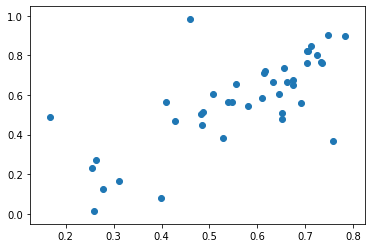

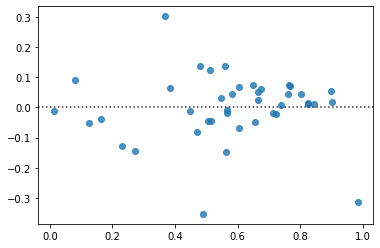

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 73 , error = 0.01581629301493238, training error = 4.005493174930252e-05


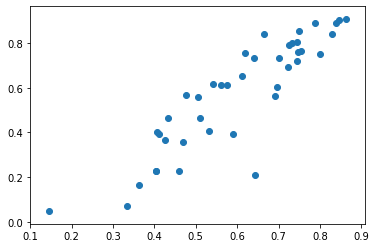

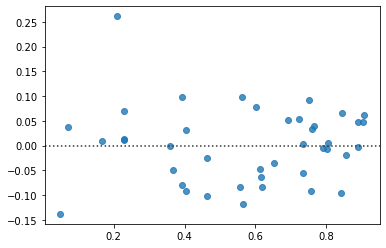

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 64 , error = 0.01566529750353113, training error = 0.0002132837333864952


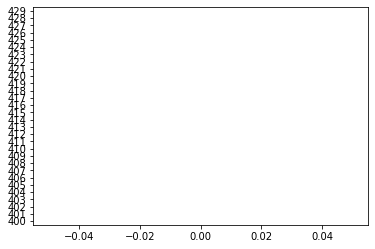

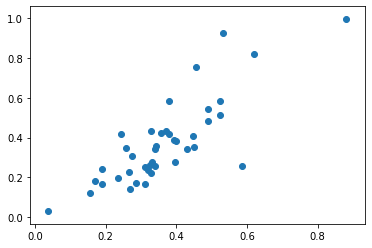

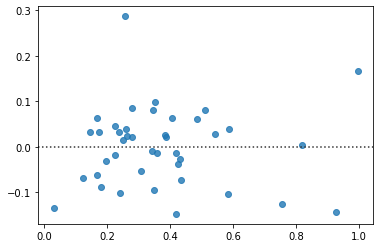

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 74 , error = 0.006603323683687673, training error = 0.0006015060601081477


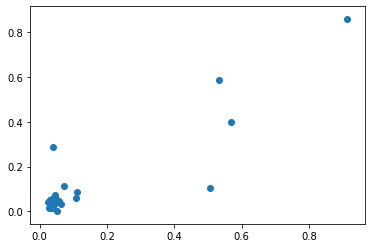

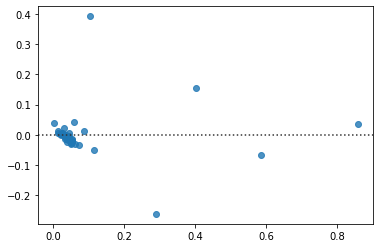

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 71 , error = 0.007882890154084403, training error = 0.0015739196688844066


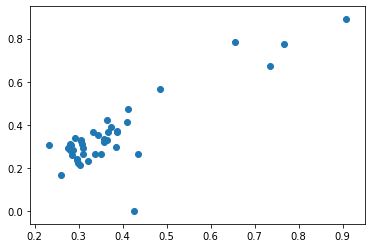

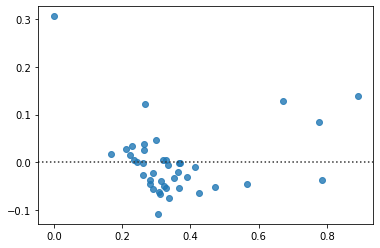

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 70 , error = 0.012562677611958544, training error = 0.000393768252070888


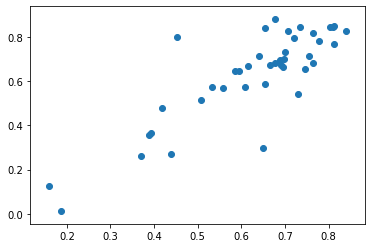

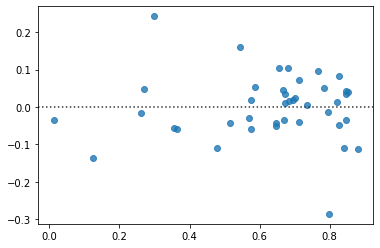

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 54 , error = 0.01777132955739161, training error = 0.00017217008635773837


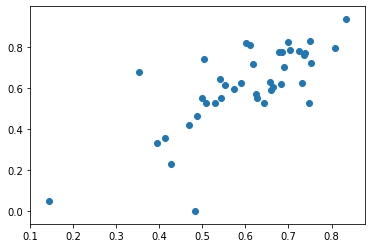

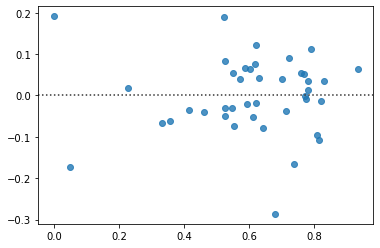

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 72 , error = 0.011429686090038329, training error = 0.0013958872859162674


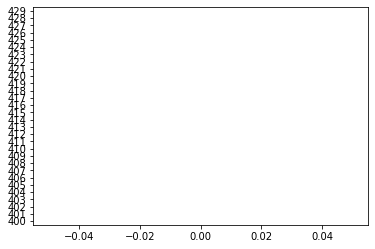

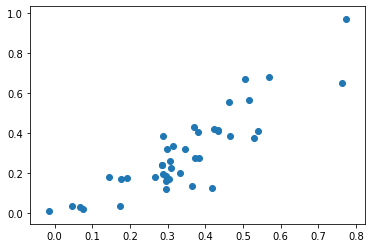

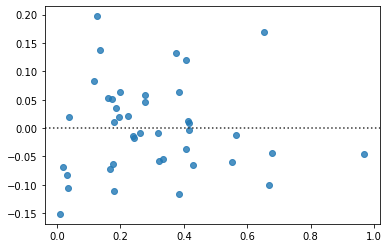

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 80 , error = 0.005608086538361628, training error = 0.0008384123276140943


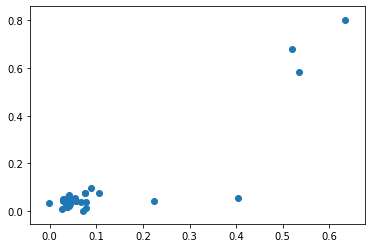

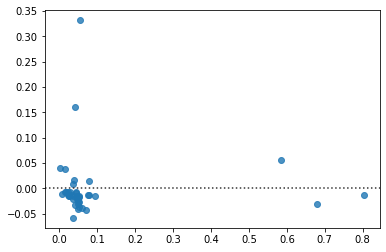

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 90 , error = 0.0037327094230003395, training error = 0.0002865059780826396


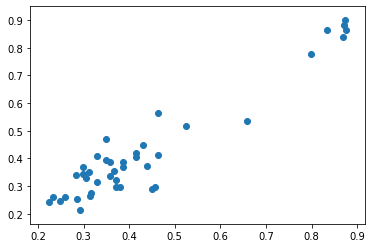

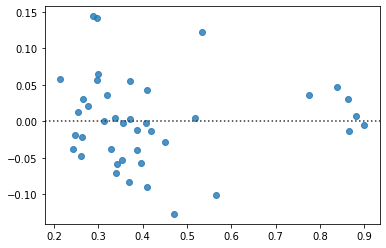

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 52 , error = 0.014279965327124935, training error = 0.0014793753171315586


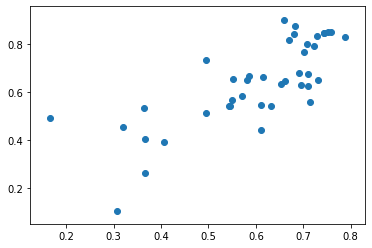

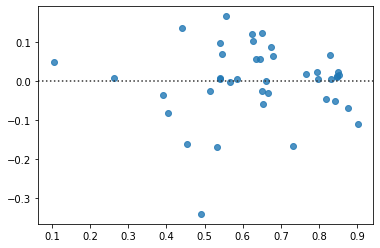

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 65 , error = 0.014177529795412001, training error = 0.0003593230792144678


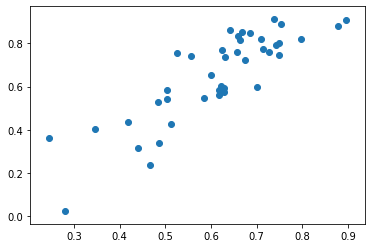

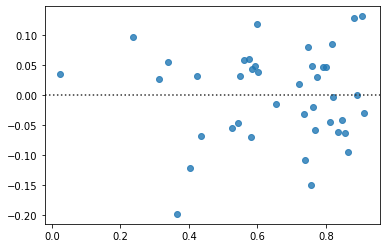

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 56 , error = 0.013435608427269303, training error = 0.0013454465543420897


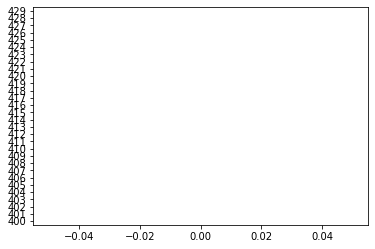

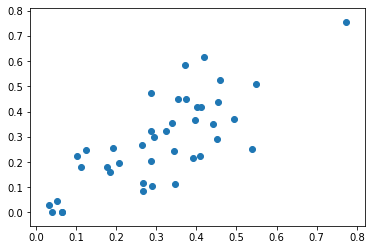

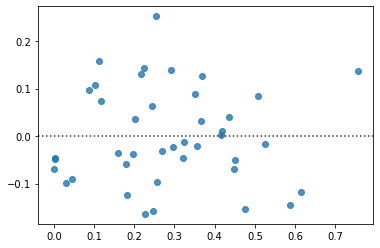

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 96 , error = 0.0030154946019881764, training error = 0.00023126975594432614


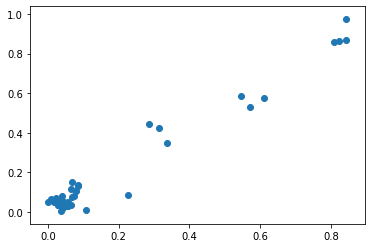

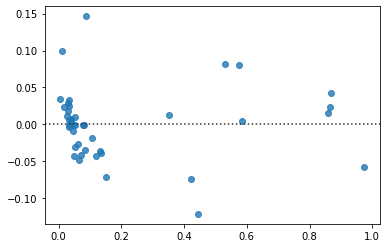

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 65 , error = 0.016063262485301905, training error = 0.0004758195093225683


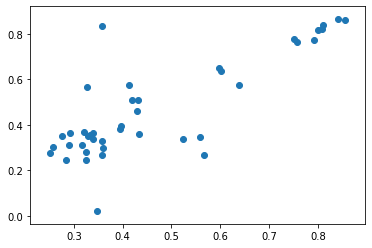

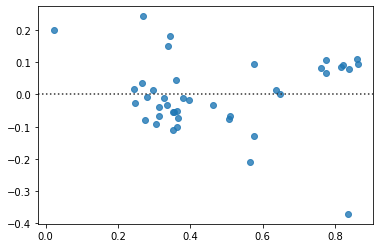

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 61 , error = 0.013845055055878972, training error = 0.00027658417039300447


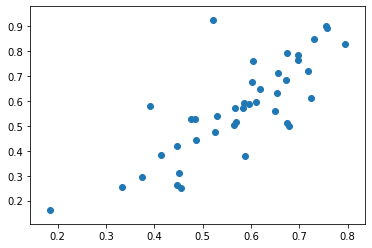

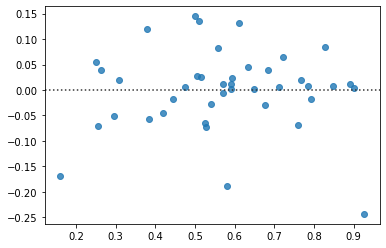

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 55 , error = 0.018723844095910047, training error = 0.003122445721965191


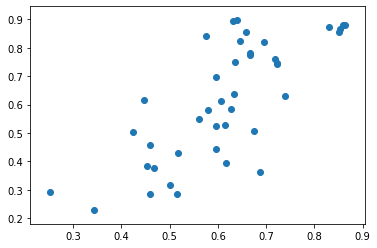

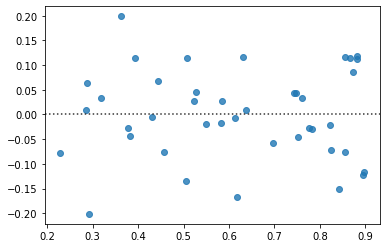

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 44 , error = 0.026724429490664947, training error = 0.00018792315986526127


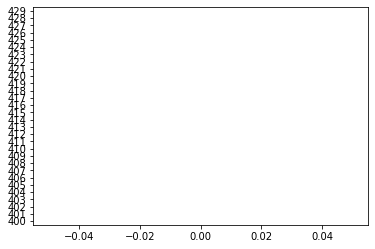

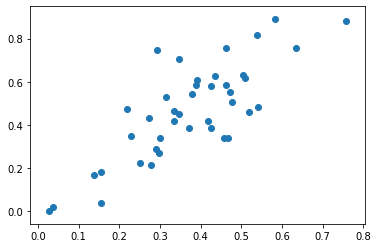

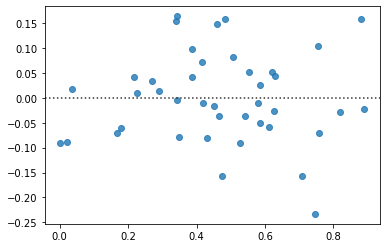

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 89 , error = 0.00288601474109072, training error = 0.0001882951620119377


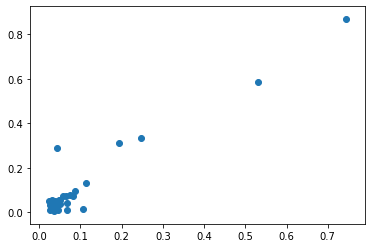

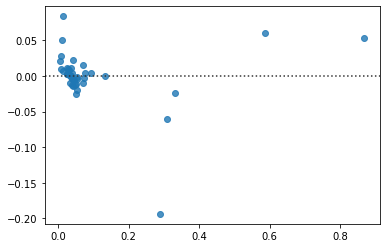

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 71 , error = 0.010126951980288847, training error = 0.00024238968790083346


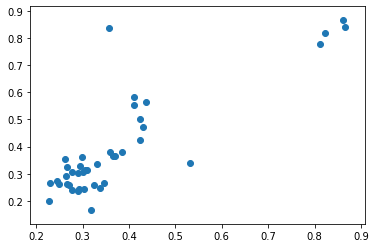

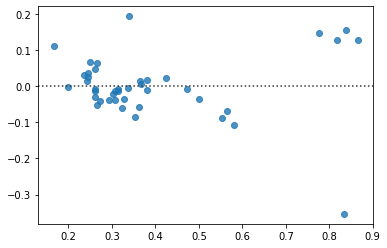

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 16 , error = 0.027164854810293102, training error = 0.00018498955692134377


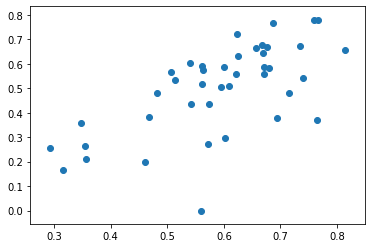

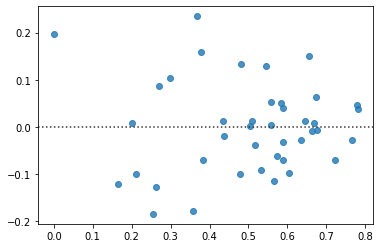

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 56 , error = 0.016934608095958783, training error = 0.0012566907926248117


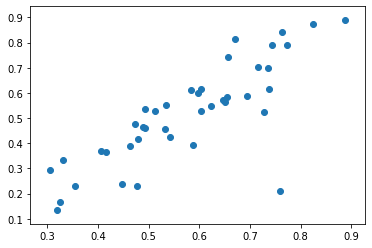

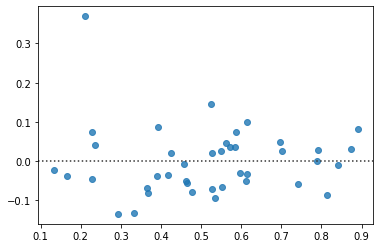

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 49 , error = 0.017448848791894712, training error = 0.0027298490897419065


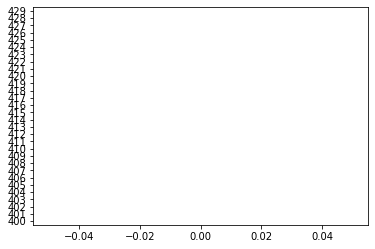

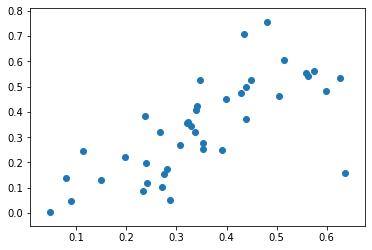

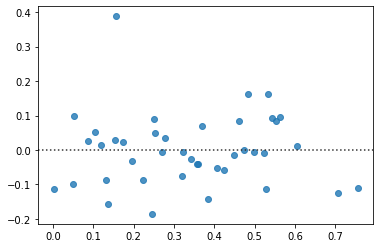

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 89 , error = 0.007144013358390199, training error = 0.0006059124884139947


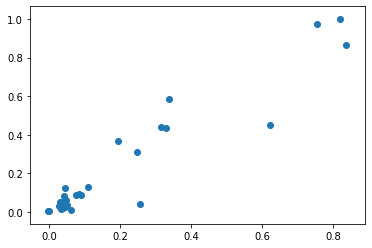

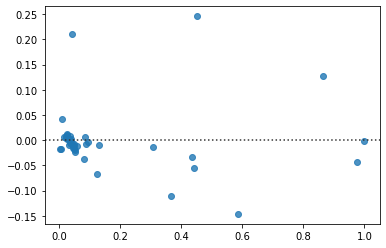

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 74 , error = 0.008973384141570607, training error = 0.0005120917041779759


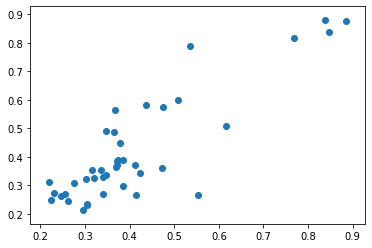

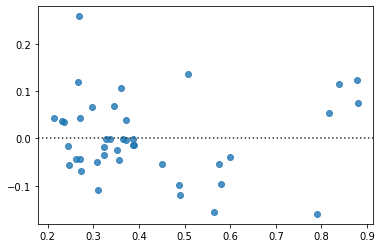

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 48 , error = 0.02386346543527203, training error = 0.003317026446645261


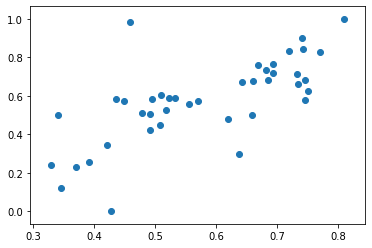

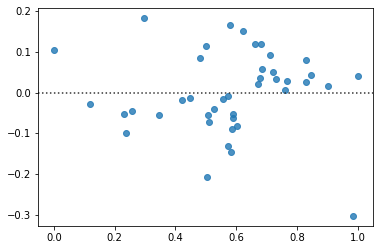

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 67 , error = 0.010755967227956863, training error = 0.0013675020433745572


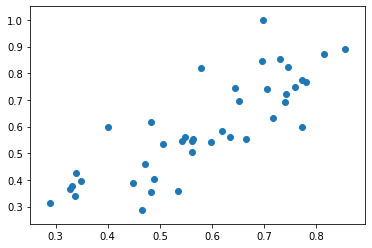

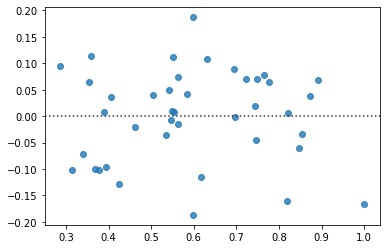

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 72 , error = 0.010352387809628829, training error = 0.0012557897421811412


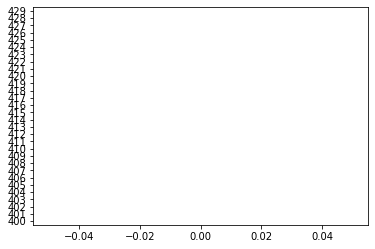

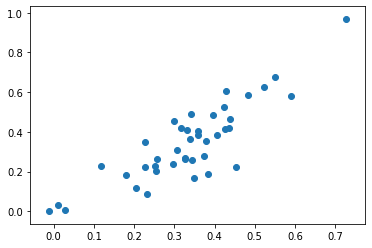

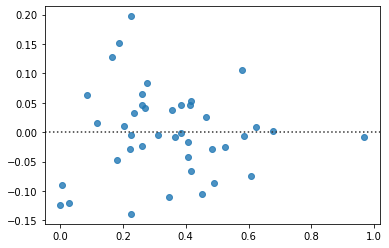

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 76 , error = 0.008440843937569496, training error = 0.00010571108389101587


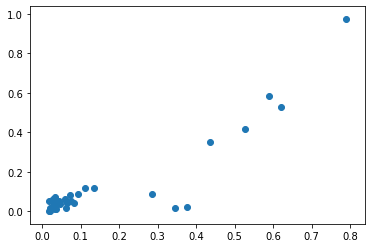

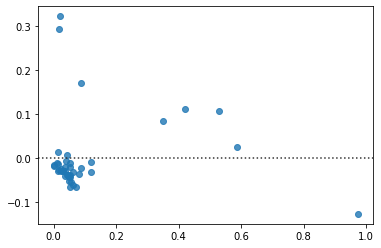

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 74 , error = 0.011238887048544005, training error = 0.0014458656223414101


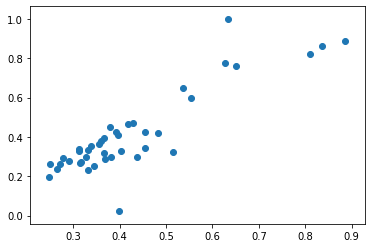

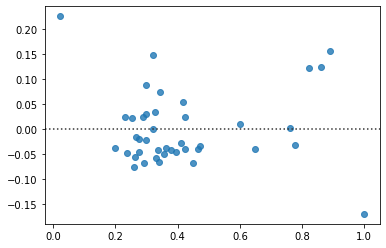

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 61 , error = 0.016703784938825798, training error = 0.001226425867935949


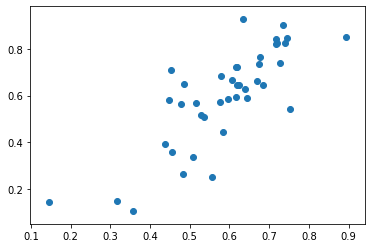

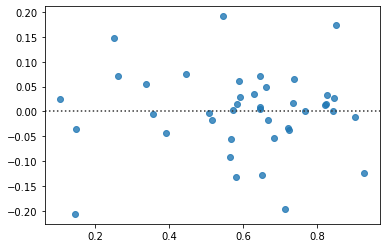

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 68 , error = 0.010640028963170626, training error = 0.0012779381155820179


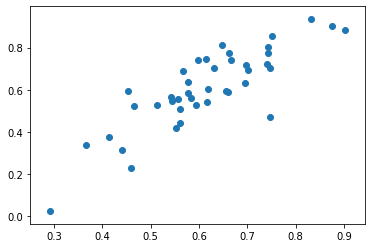

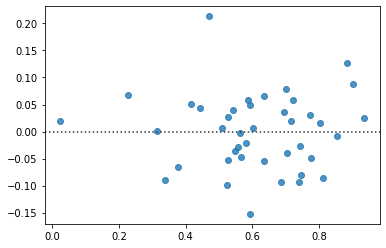

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 53 , error = 0.018807295066230075, training error = 0.001218366942137115


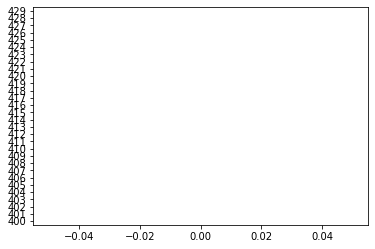

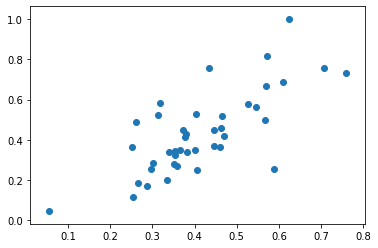

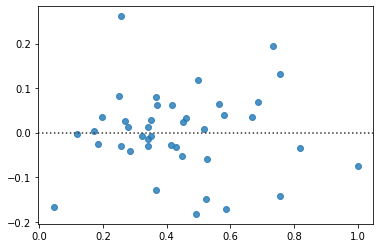

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 83 , error = 0.002515371499672199, training error = 0.0006628425752555335


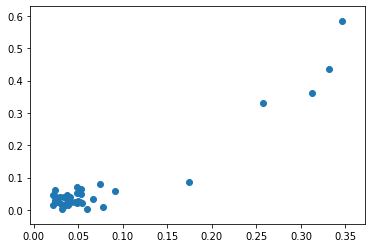

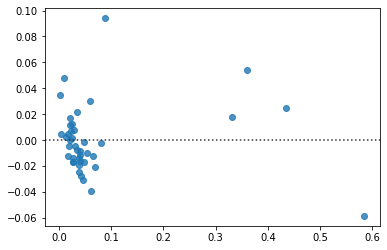

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 73 , error = 0.00448120274112736, training error = 0.001550357844424762


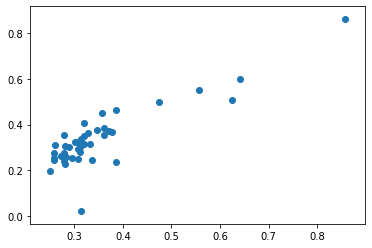

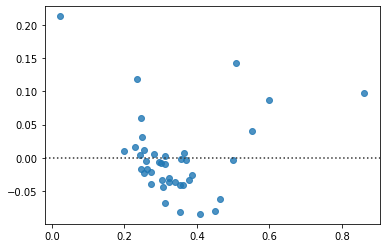

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 37 , error = 0.02515492487894329, training error = 0.0033497936244374182


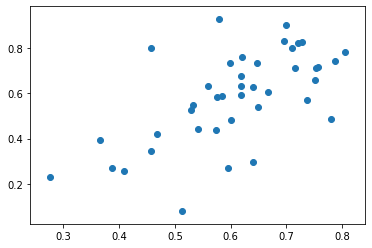

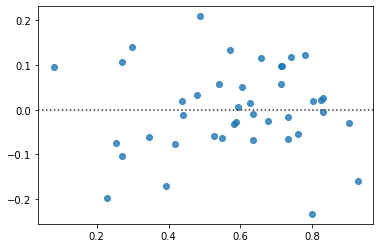

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 54 , error = 0.015195622420383338, training error = 0.0011395014812596224


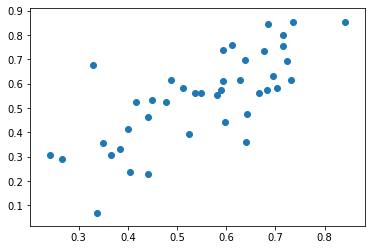

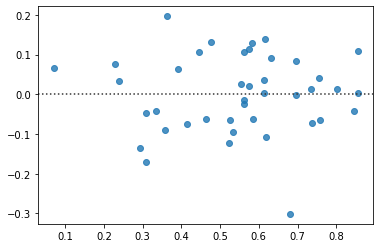

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 78 , error = 0.016506408089666934, training error = 0.0002704993592528082


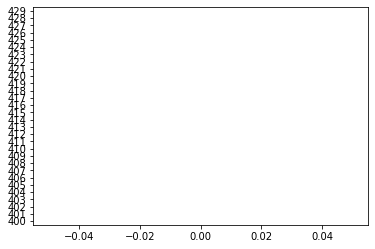

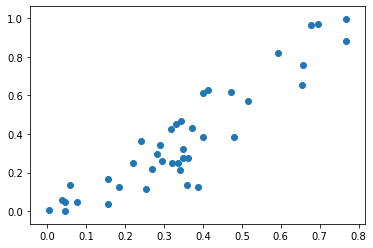

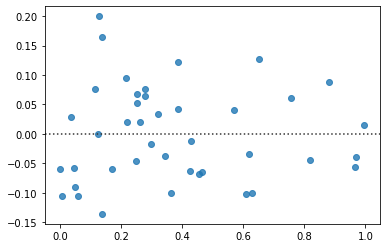

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 90 , error = 0.0022712092108195824, training error = 0.0002666813355539037


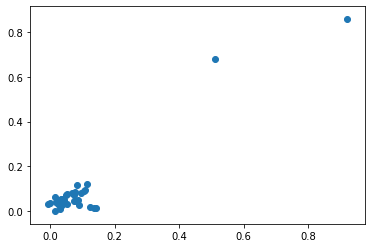

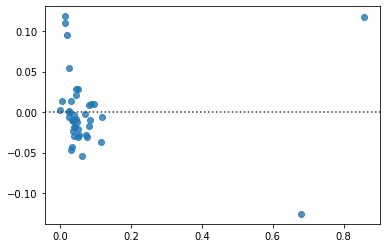

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 75 , error = 0.012337054621636864, training error = 0.00022438470437885846


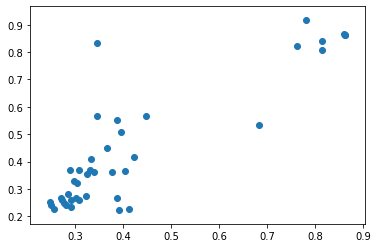

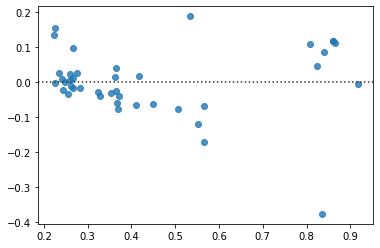

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 66 , error = 0.014986588370976642, training error = 0.00036034031172797276


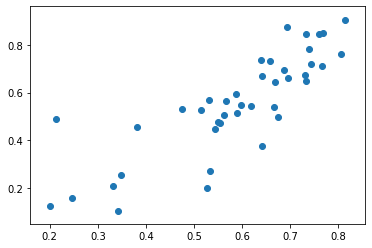

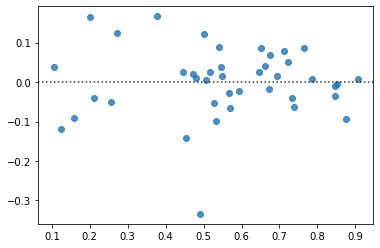

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 72 , error = 0.017102807179459275, training error = 0.003024738420841782


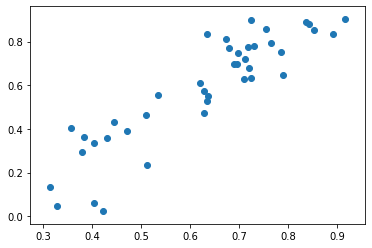

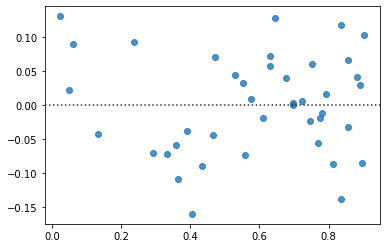

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 86 , error = 0.008188199281155766, training error = 0.00016752781910416503


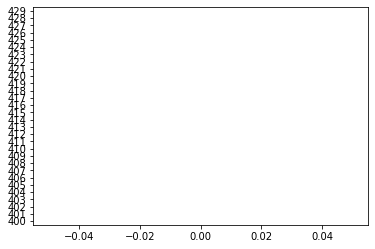

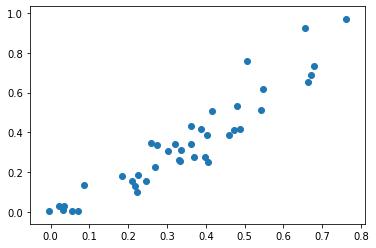

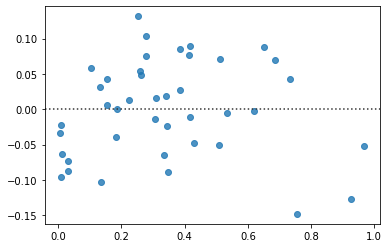

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 85 , error = 0.007224553555648277, training error = 3.431489163295786e-05


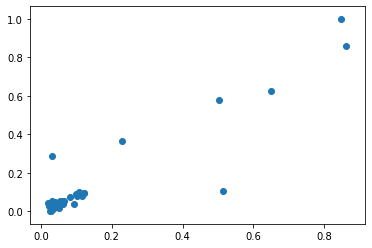

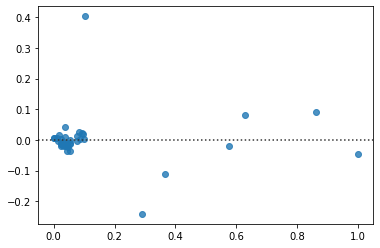

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 90 , error = 0.005142300205054203, training error = 0.000515374028683977


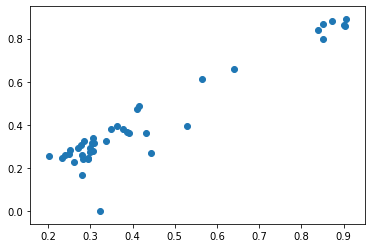

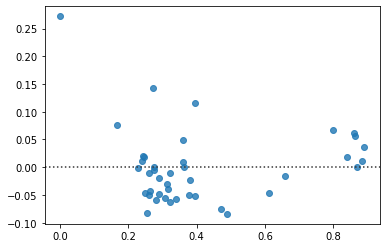

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 74 , error = 0.009405955856857598, training error = 0.00032890798135799907


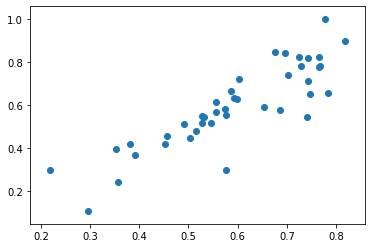

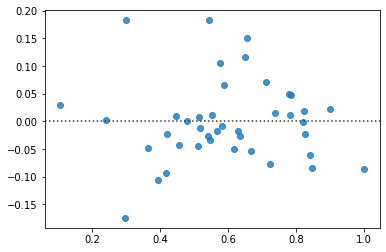

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 79 , error = 0.011647943335019539, training error = 0.00016161919356664172


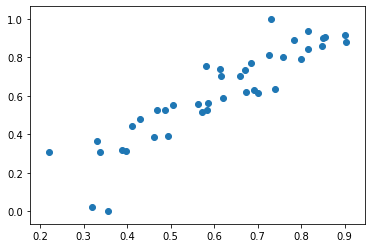

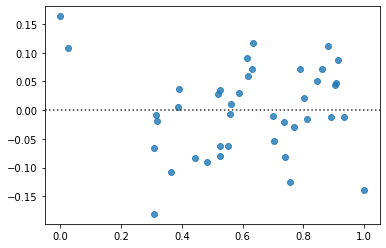

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 57 , error = 0.01935441824393437, training error = 0.0001629939778179636


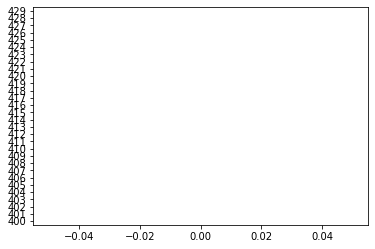

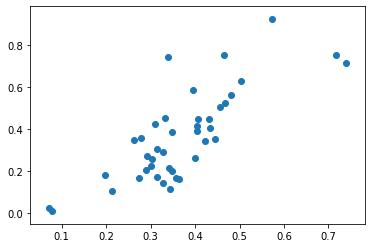

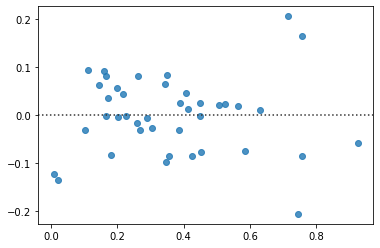

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 75 , error = 0.006407833134746846, training error = 0.0006413790794946391


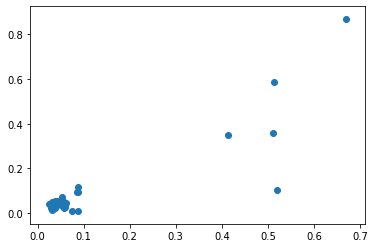

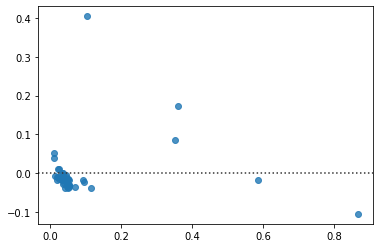

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 65 , error = 0.012315164334311839, training error = 0.00028384263389497614


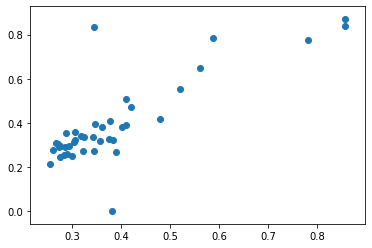

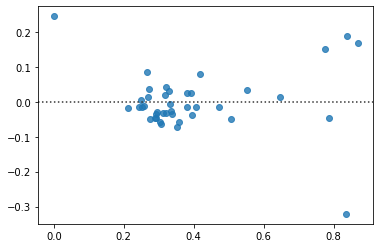

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 56 , error = 0.0160560519405351, training error = 0.00031534013756222176


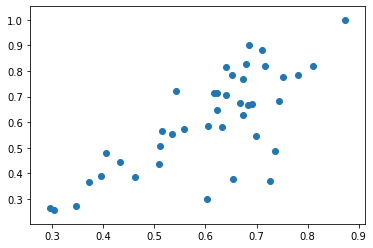

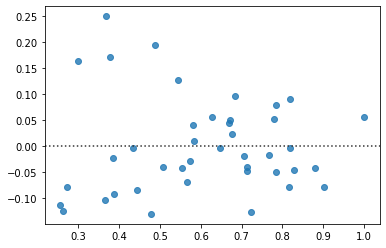

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 42 , error = 0.02710933568909712, training error = 1.6411239751036785e-05


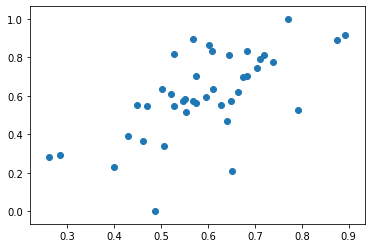

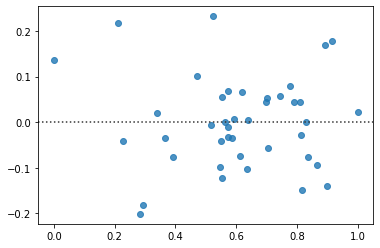

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 71 , error = 0.014858541659660801, training error = 0.0001780841048313996


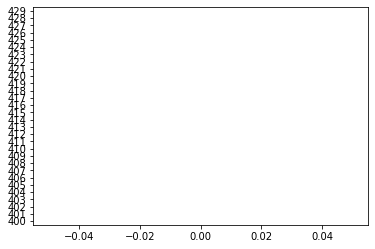

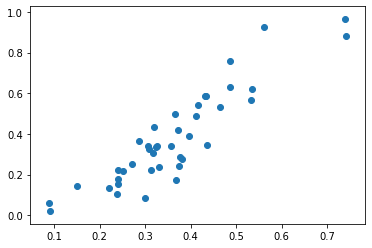

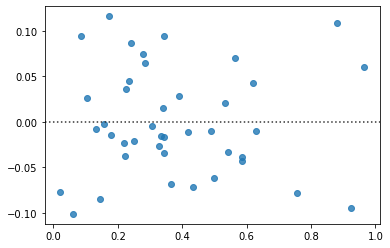

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 81 , error = 0.010755423806478268, training error = 1.6821531977168185e-05


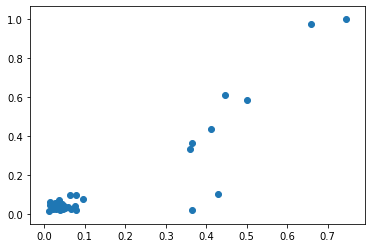

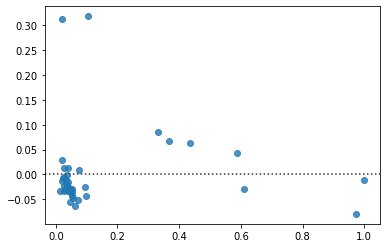

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 72 , error = 0.009023464865911799, training error = 0.0004974830593804654


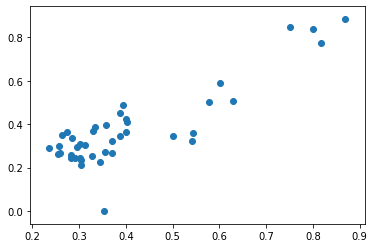

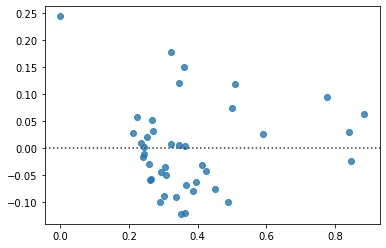

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 77 , error = 0.009986085313153722, training error = 0.0002692585358072285


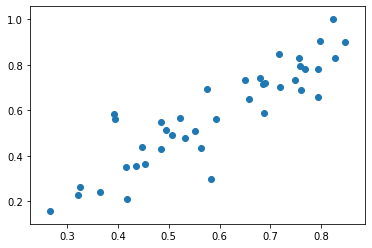

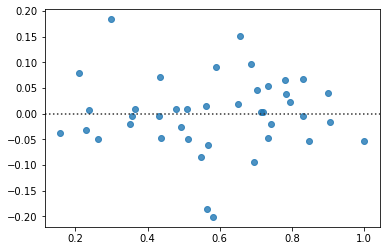

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 55 , error = 0.02063596535515109, training error = 1.8289649161271467e-05


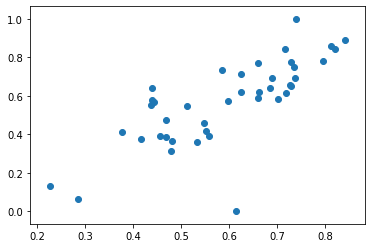

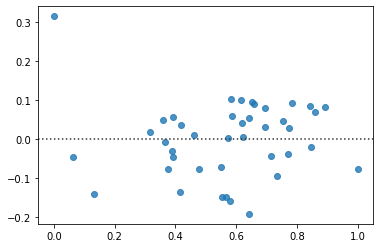

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 55 , error = 0.0207930050309898, training error = 0.001243595620155978


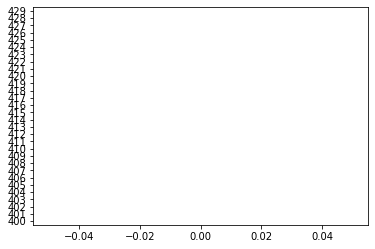

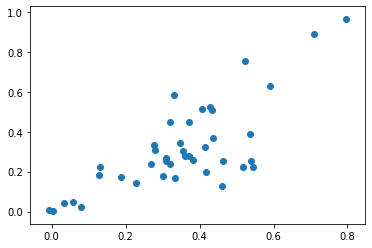

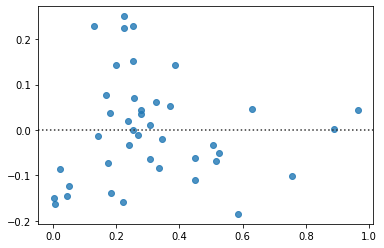

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 90 , error = 0.005575628035184134, training error = 0.00023295156495061647


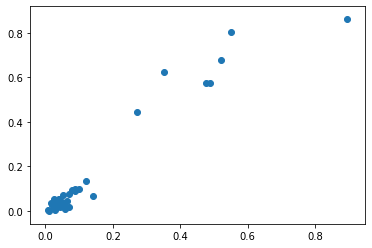

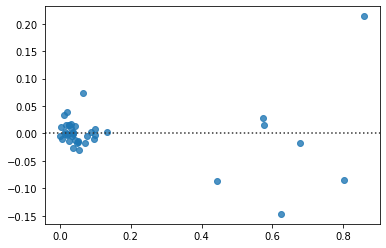

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 91 , error = 0.0035872255114095353, training error = 0.0006277609257050517


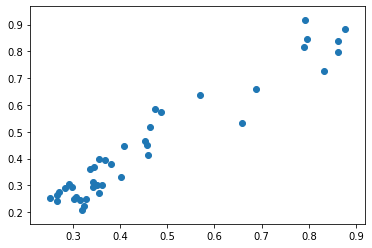

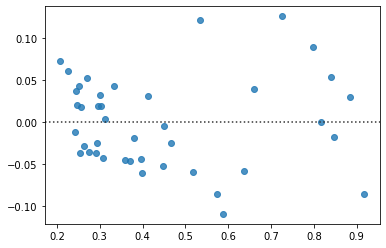

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 41 , error = 0.022520442347982124, training error = 0.001288153531204382


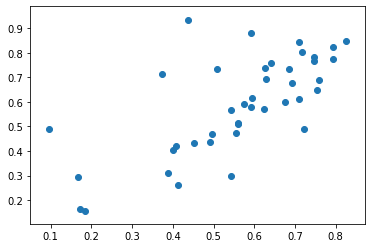

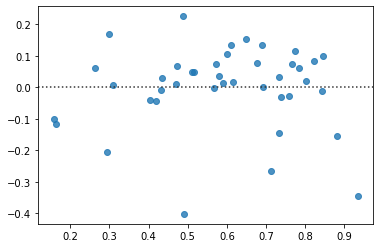

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 68 , error = 0.01103151156452496, training error = 0.0002245249772030066


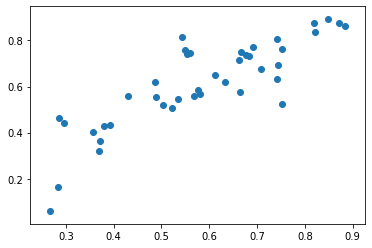

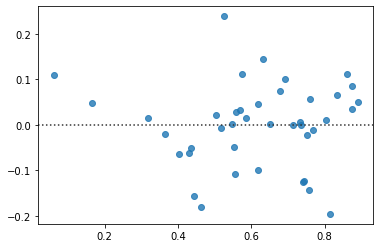

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 54 , error = 0.024497088972191376, training error = 0.0012307119019297696


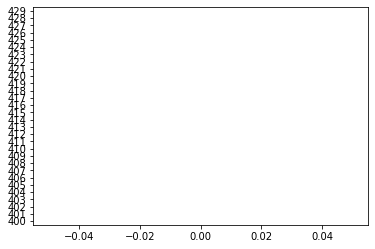

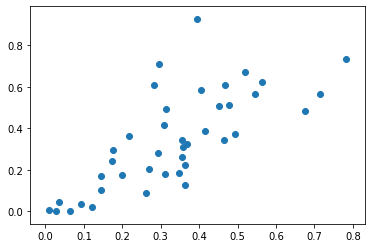

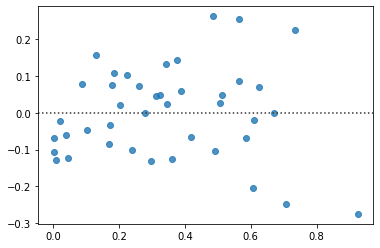

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 82 , error = 0.009131448193145932, training error = 0.0006769118707003187


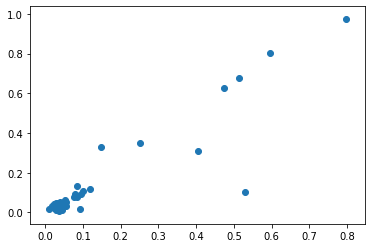

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 85 , error = 0.006990495890440113, training error = 0.00028109868836820377


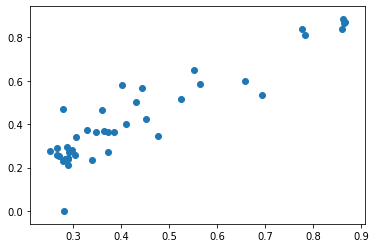

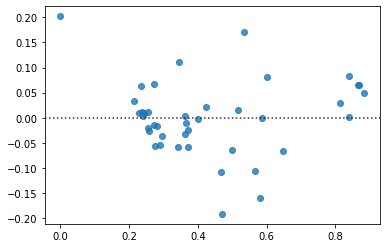

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 39 , error = 0.021872139864501237, training error = 3.8695754398980434e-05


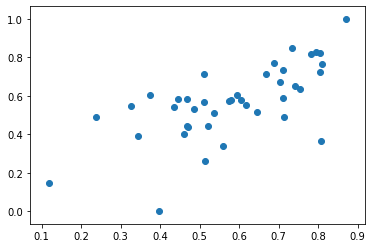

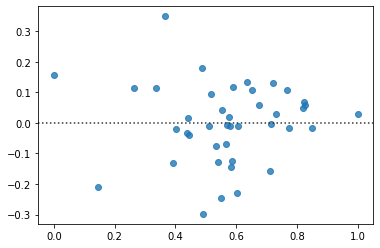

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 64 , error = 0.01553434242134192, training error = 0.00022986434678469404


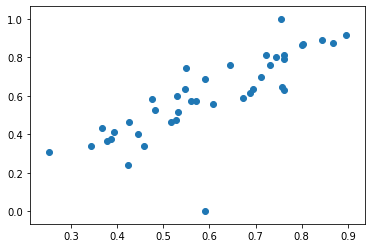

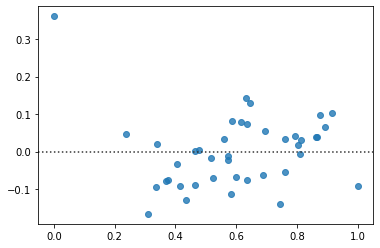

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 51 , error = 0.02337877757134259, training error = 1.708265292946067e-05


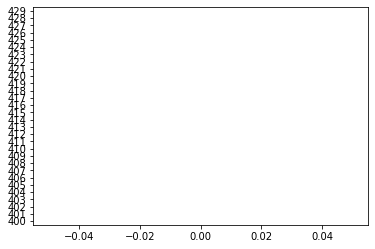

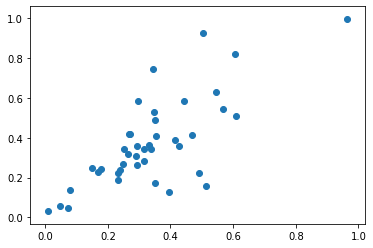

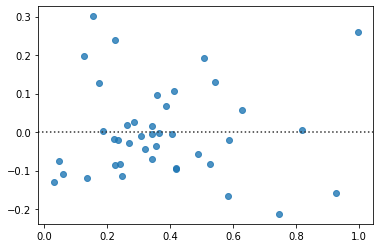

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 75 , error = 0.008723054085594489, training error = 0.00015881116706039963


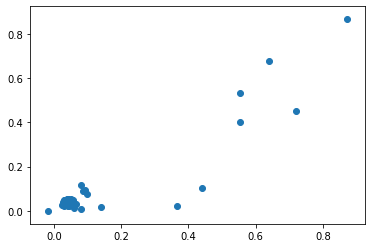

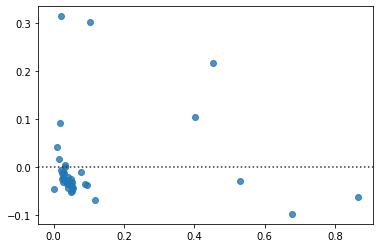

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 71 , error = 0.01138171678479066, training error = 0.0012088707197327254


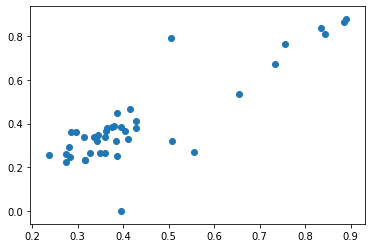

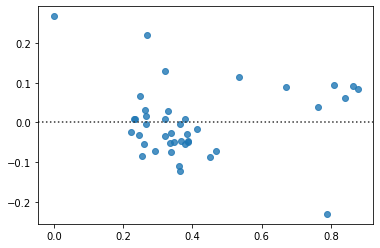

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 49 , error = 0.021746362417538585, training error = 0.00037887482358760975


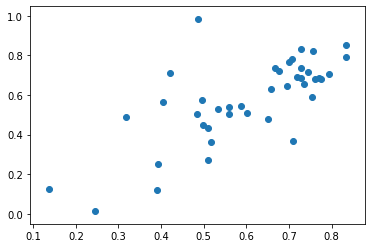

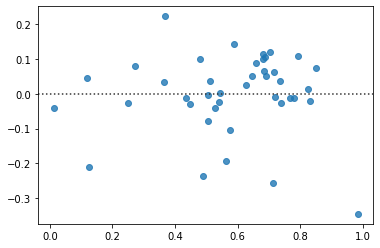

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 47 , error = 0.02454872292008321, training error = 9.240056771365007e-06


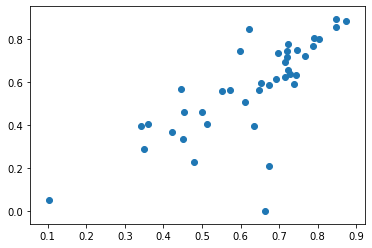

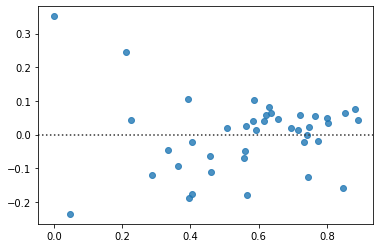

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 62 , error = 0.013478851537011735, training error = 0.0033857274623924436


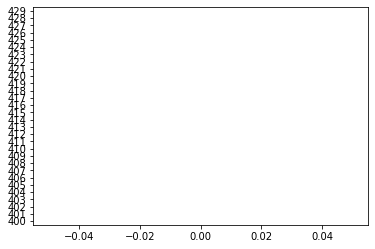

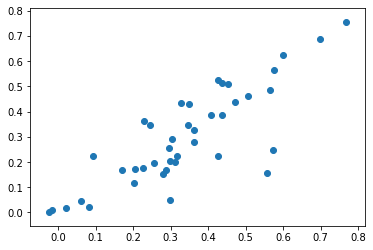

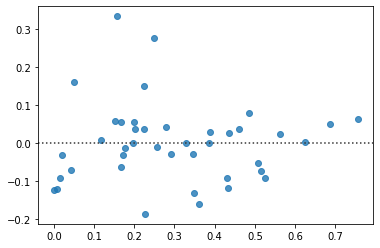

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 95 , error = 0.0018437429936081268, training error = 0.00016995282620083264


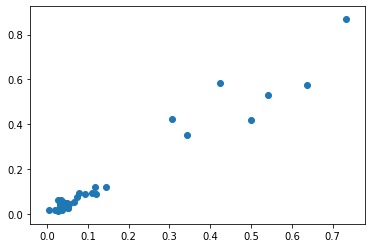

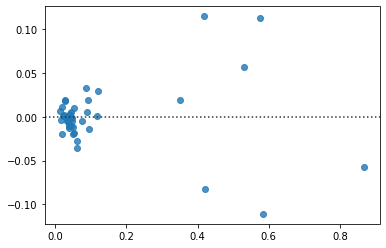

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 83 , error = 0.00818312006031279, training error = 4.1368824860117826e-05


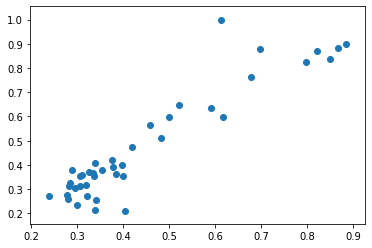

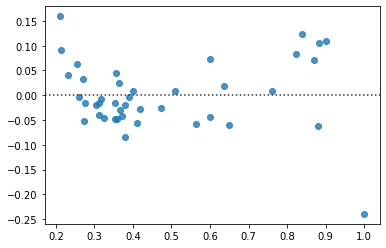

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 62 , error = 0.01542815884479598, training error = 0.00368832767367995


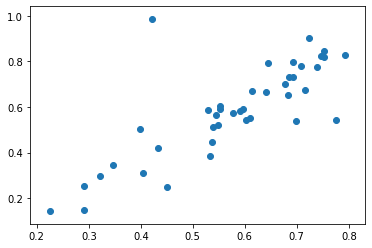

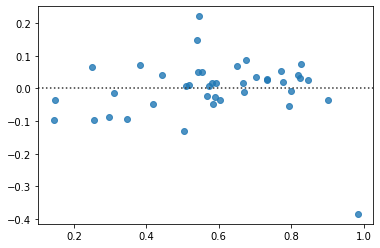

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 79 , error = 0.007671899609493576, training error = 0.0002437397827905112


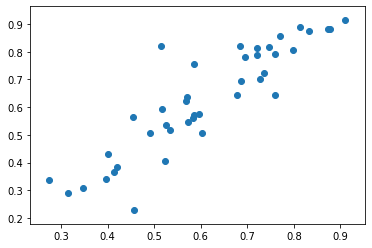

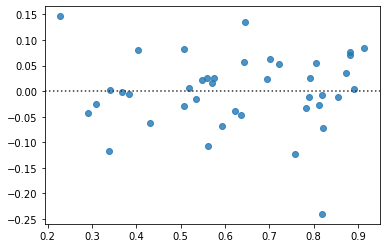

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 64 , error = 0.013453086083885561, training error = 0.00021879077176870806


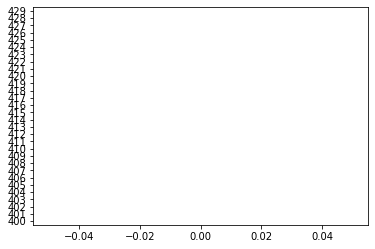

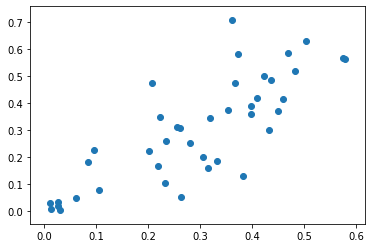

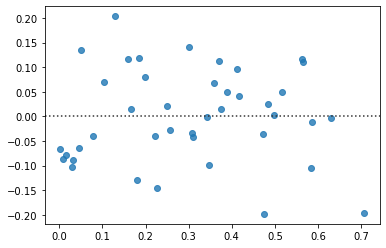

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 88 , error = 0.0041049776009681105, training error = 0.00018340070148699917


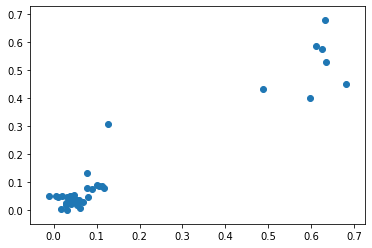

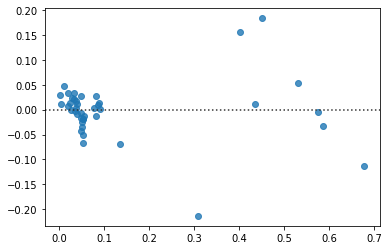

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 85 , error = 0.007647346141622216, training error = 0.0005232597592086692


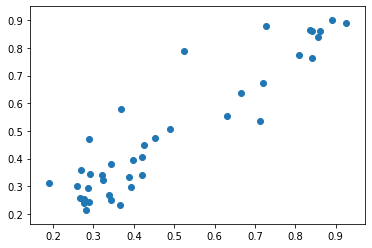

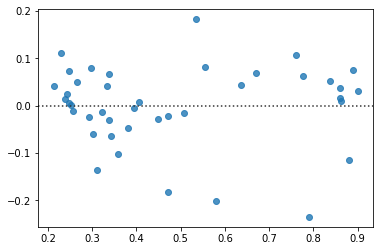

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 50 , error = 0.024637510049297463, training error = 0.003086553270082206


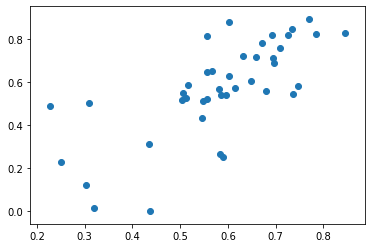

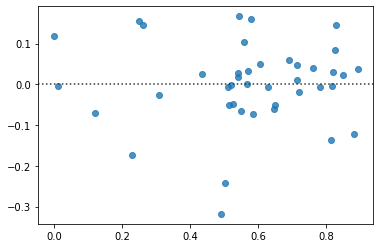

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 62 , error = 0.013015595561277678, training error = 0.0002576963943410897


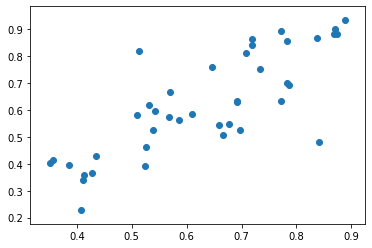

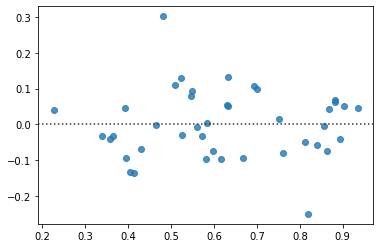

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 65 , error = 0.016175621735321704, training error = 0.0013695966325159273


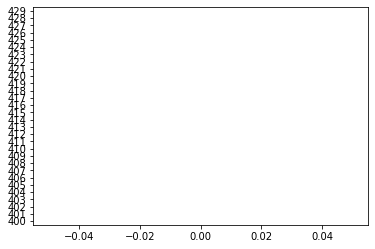

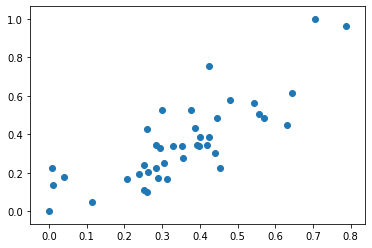

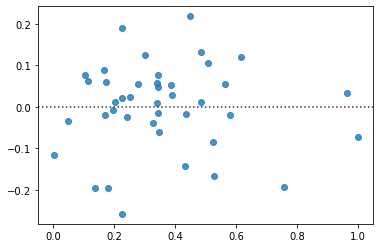

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 88 , error = 0.002222720827151341, training error = 0.00018550537780816562


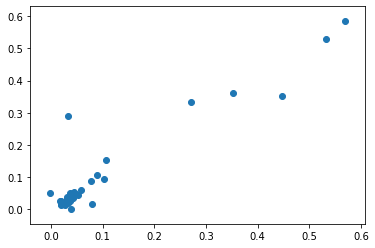

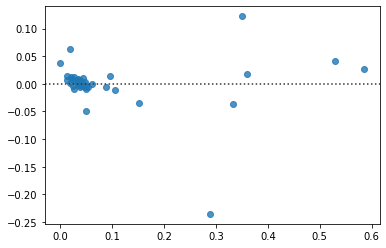

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 87 , error = 0.0044257001783698, training error = 3.6009887140024955e-05


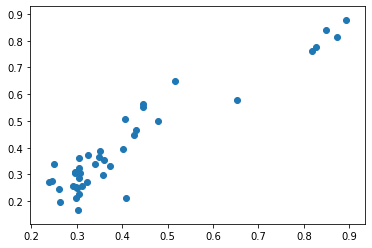

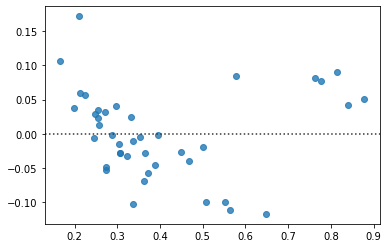

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 57 , error = 0.01908625210418537, training error = 0.0003568410377117635


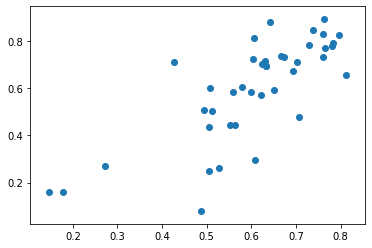

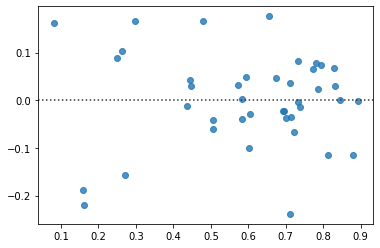

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 65 , error = 0.014129864002202841, training error = 0.0012433732762081784


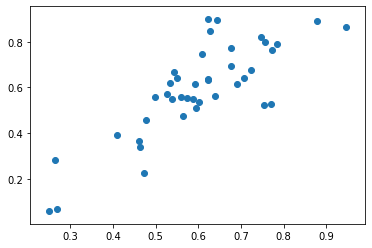

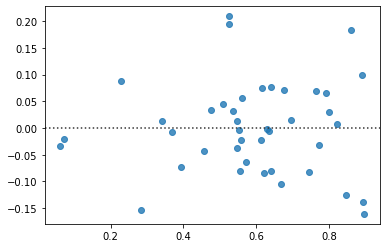

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 71 , error = 0.015293209691613997, training error = 0.00021165489670494256


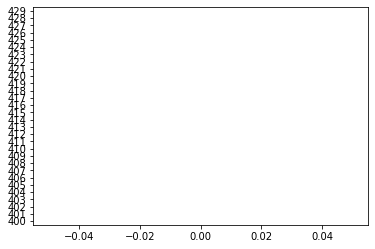

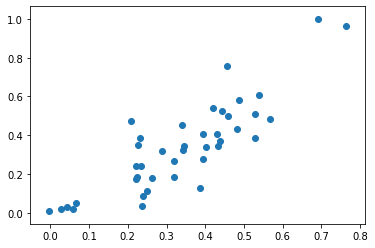

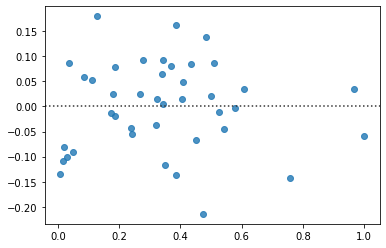

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 90 , error = 0.0045945131730024055, training error = 0.0002665515585808013


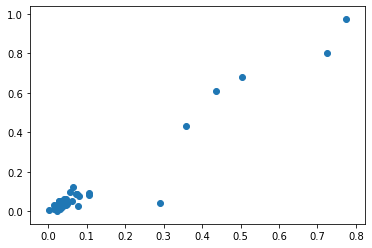

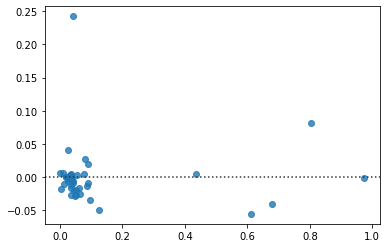

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 85 , error = 0.006250249248018934, training error = 0.0005328430039262008


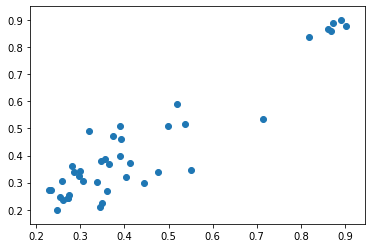

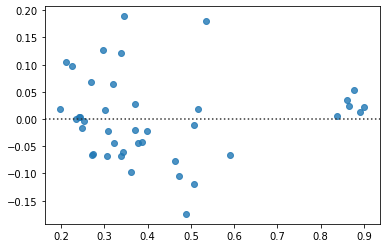

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 56 , error = 0.01473632790111767, training error = 0.00030838473387193206


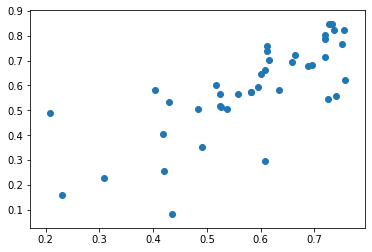

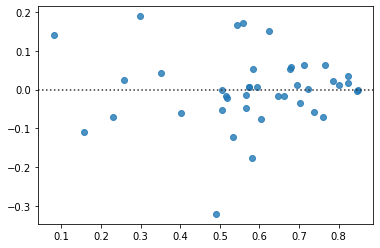

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 73 , error = 0.012343206546450845, training error = 0.00024609592105628766


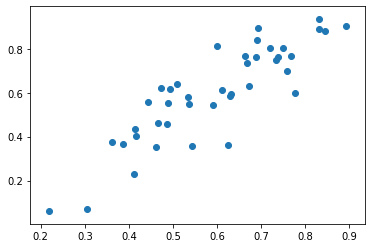

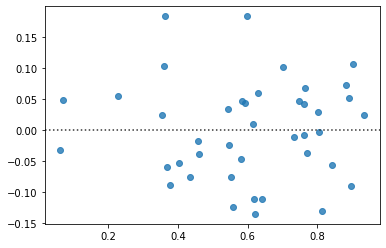

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 63 , error = 0.02233383141611191, training error = 0.003028467688288202


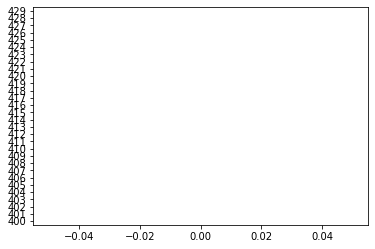

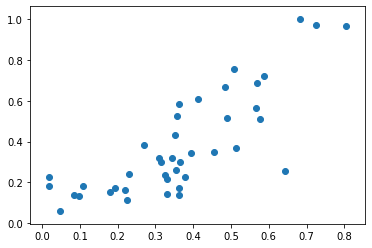

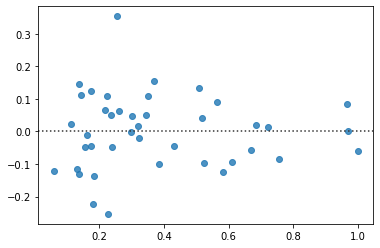

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 92 , error = 0.004108080846637242, training error = 0.00017927919115718846


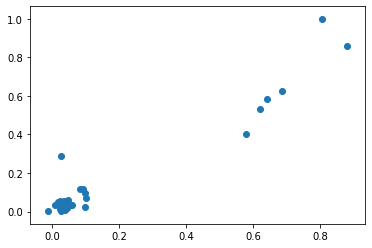

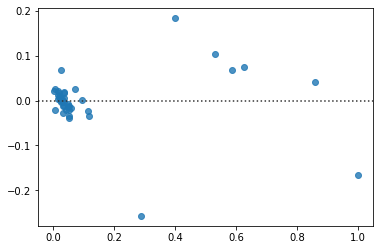

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 73 , error = 0.009520213695961286, training error = 4.506737632762242e-05


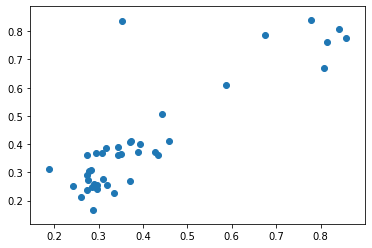

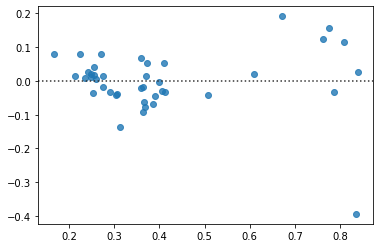

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 53 , error = 0.024525347837702733, training error = 0.0033319956662687077


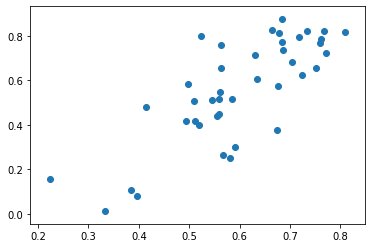

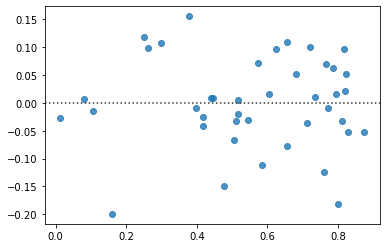

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 64 , error = 0.019288533283394416, training error = 0.00026883052223212946


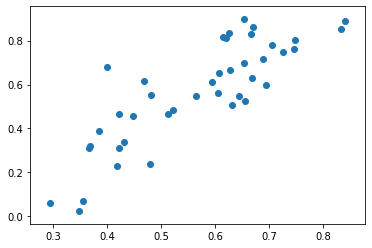

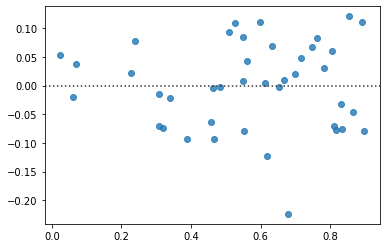

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 68 , error = 0.017805444415476684, training error = 0.00023799903570353154


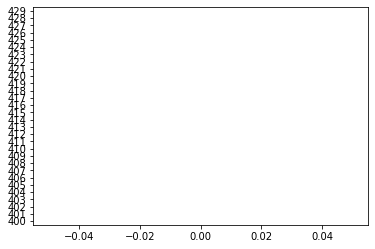

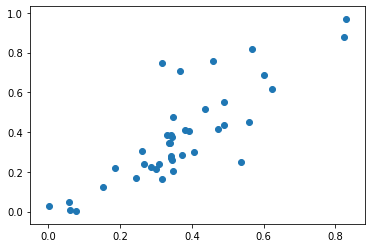

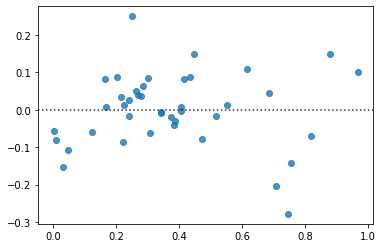

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 82 , error = 0.0062087853394670114, training error = 0.00023016453597664882


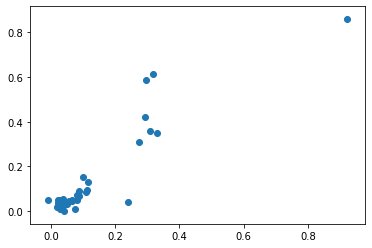

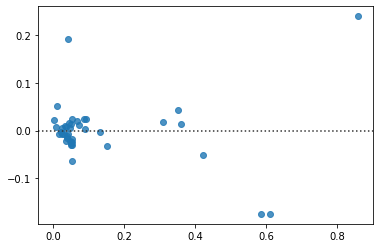

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 74 , error = 0.009946766838977182, training error = 0.00023672076157420688


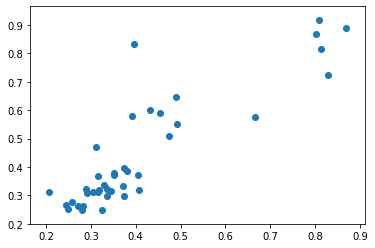

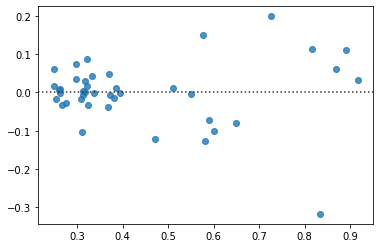

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 41 , error = 0.02768138297663371, training error = 1.7482753333885253e-05


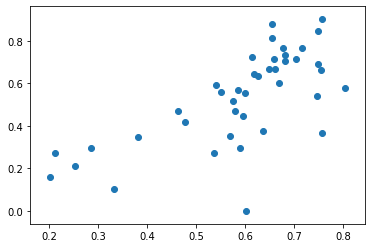

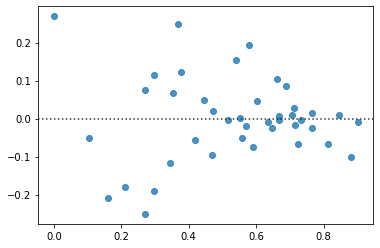

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 69 , error = 0.01295678448046317, training error = 0.0002575570139289058


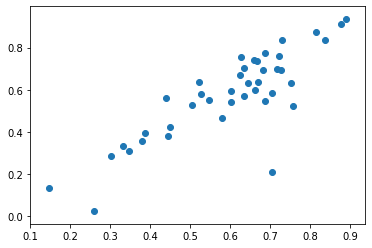

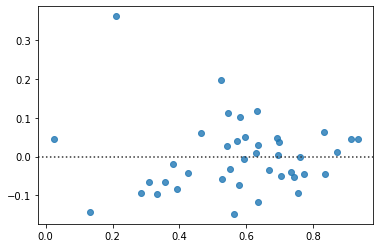

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 59 , error = 0.022714000197969084, training error = 0.003154338448036332


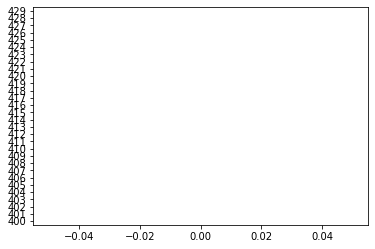

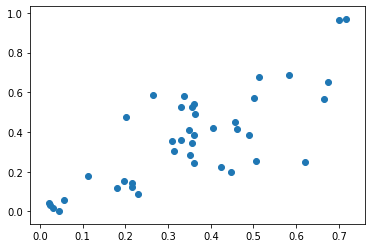

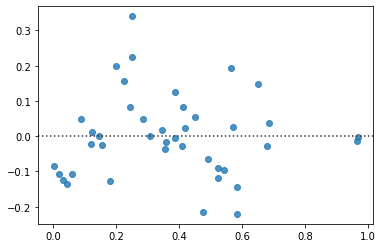

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 91 , error = 0.005050193634802236, training error = 0.0006564580455601823


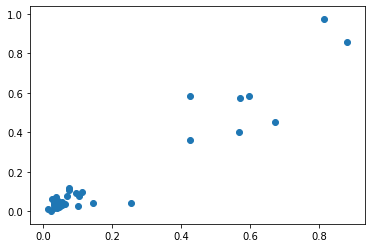

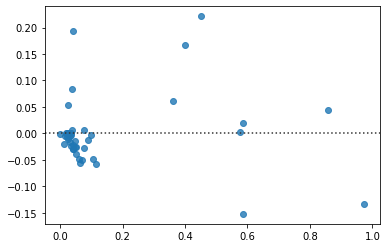

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 86 , error = 0.006444507169630349, training error = 0.00029550163101020843


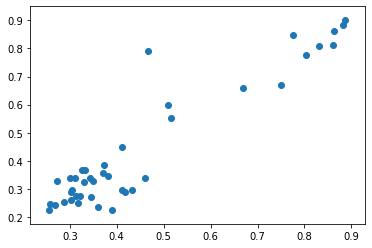

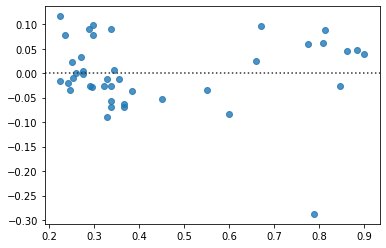

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 56 , error = 0.018487352961102044, training error = 0.0038021639930404323


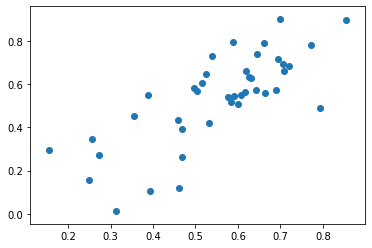

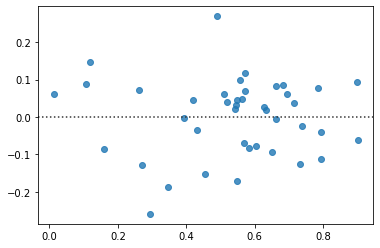

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 69 , error = 0.01485561359319448, training error = 0.00026403026903894065


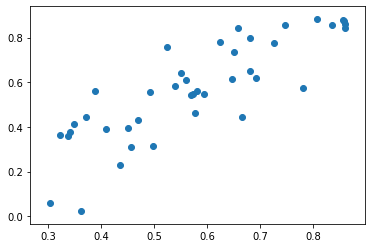

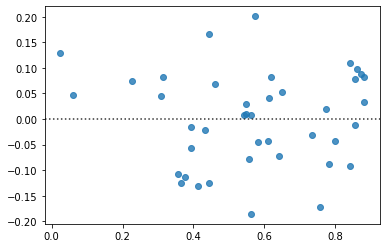

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 45 , error = 0.023235635159331892, training error = 3.0561900218364595e-05


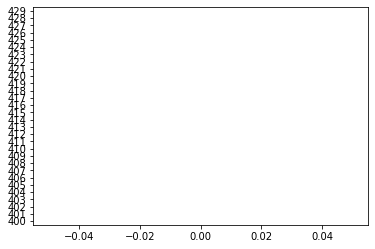

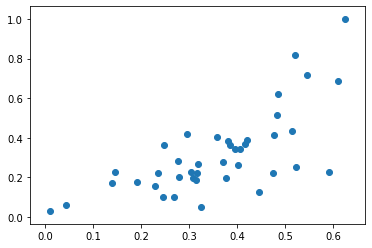

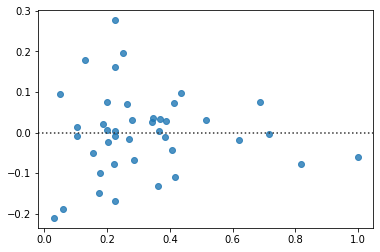

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 92 , error = 0.002592642363108748, training error = 0.00019821513285571307


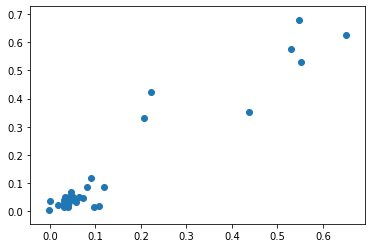

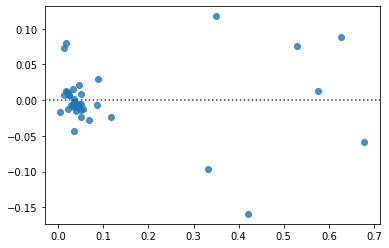

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 85 , error = 0.004443499590893156, training error = 4.590314851242713e-05


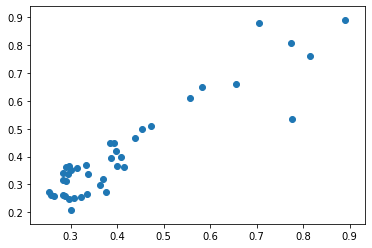

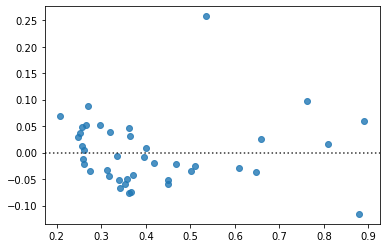

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 38 , error = 0.026843418940939175, training error = 0.0013053423261467053


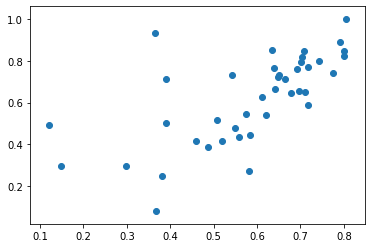

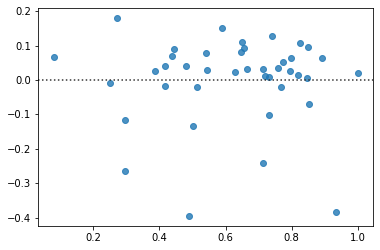

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 61 , error = 0.014997698689659998, training error = 2.984432252269334e-05


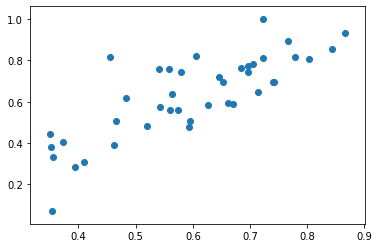

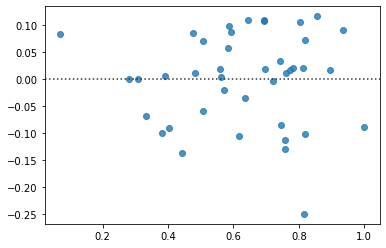

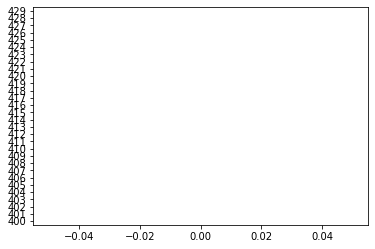

In [7]:
for i in range(30):
    xgb_regression(df1, 1)
    i = i + 1

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 65 , error = 0.018255817659492326, training error = 0.00109611714106921


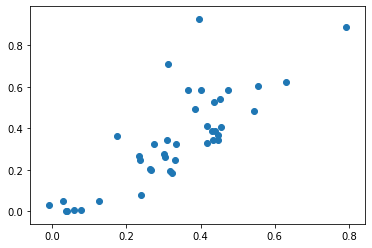

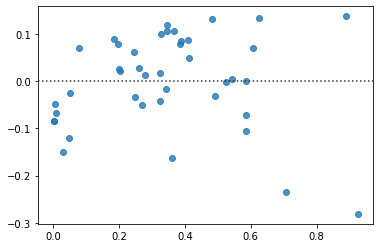

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 67 , error = 0.0037600554094948655, training error = 0.00029432742664991406


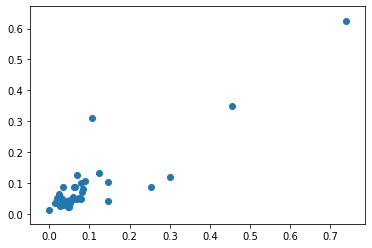

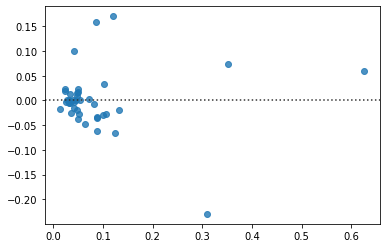

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 80 , error = 0.010110361138736144, training error = 0.00043532116716248146


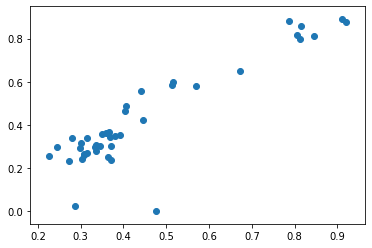

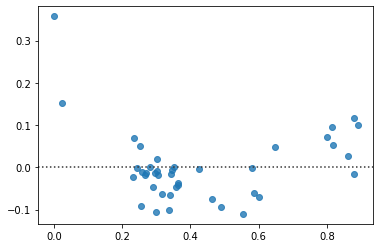

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 64 , error = 0.01547279178930956, training error = 0.003273862686075169


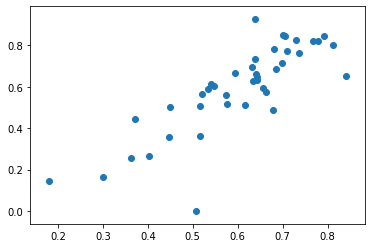

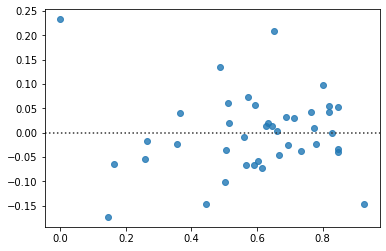

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 56 , error = 0.017705586133389132, training error = 0.0008911992371547857


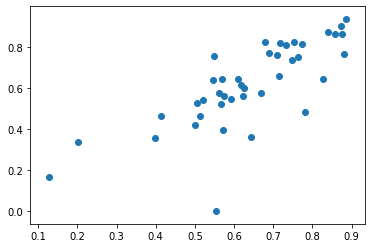

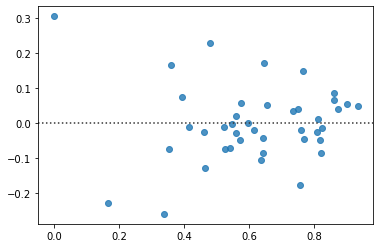

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 67 , error = 0.01342891122544178, training error = 0.00020533871091824317


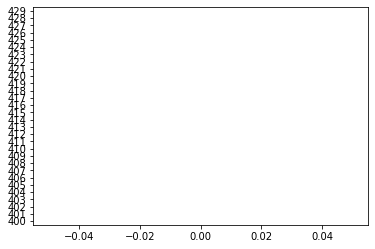

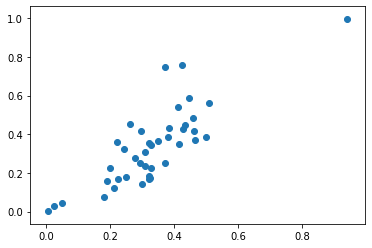

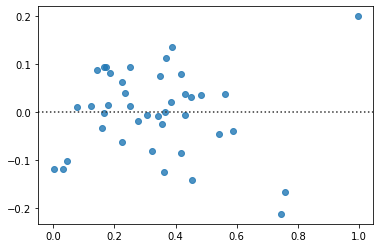

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 89 , error = 0.00438510224637798, training error = 0.00016033697147871805


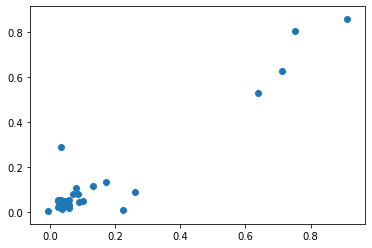

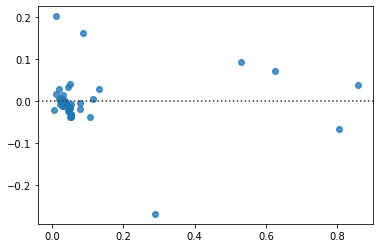

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 84 , error = 0.006257773595085342, training error = 0.0013865184961286878


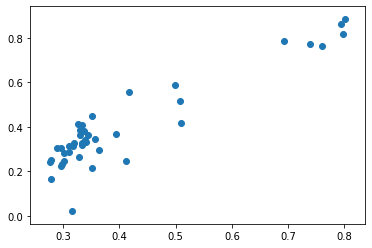

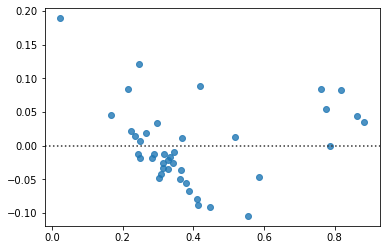

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 45 , error = 0.018699166103112706, training error = 0.0014055093947577474


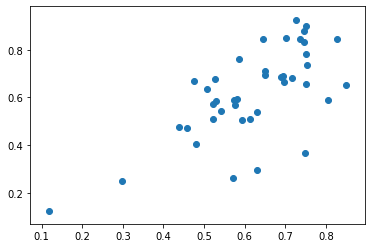

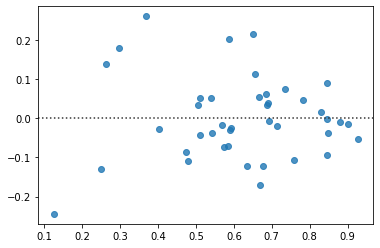

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 57 , error = 0.014066504139037723, training error = 0.00025281350707324055


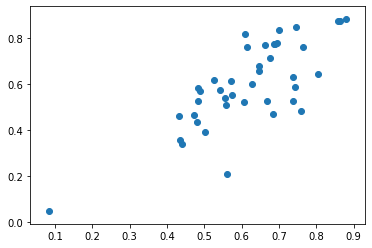

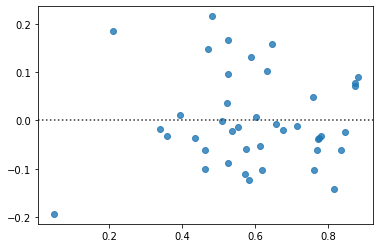

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 71 , error = 0.01799275937185361, training error = 0.0011238533709093958


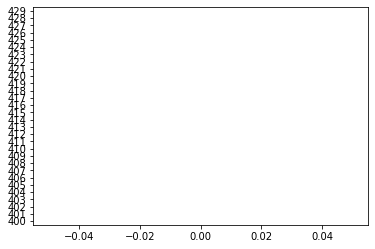

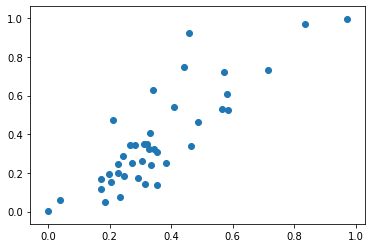

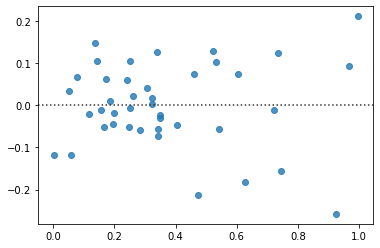

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 74 , error = 0.006527944200555942, training error = 1.3081983162355658e-05


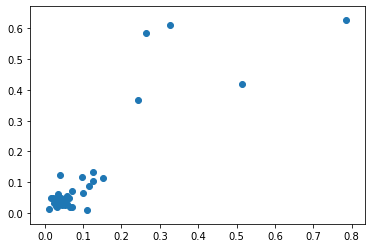

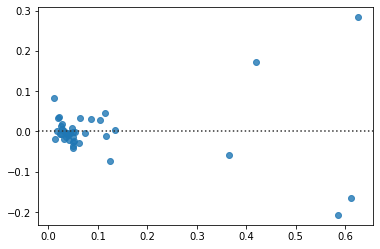

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 69 , error = 0.012634722621425783, training error = 0.00046384768546780343


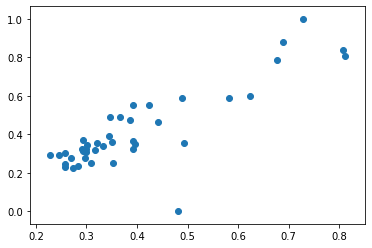

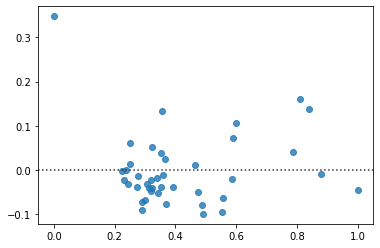

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 69 , error = 0.016882966354668696, training error = 0.0014172684204694721


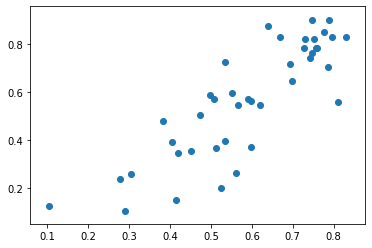

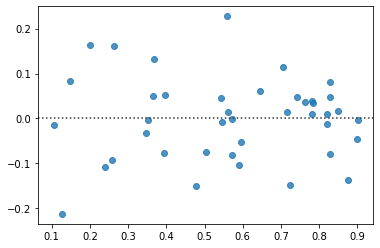

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 63 , error = 0.021837413829635683, training error = 0.0007592502892027463


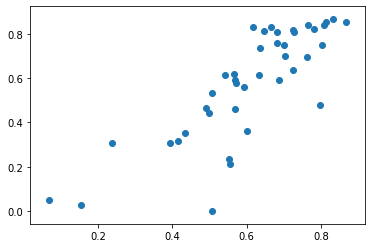

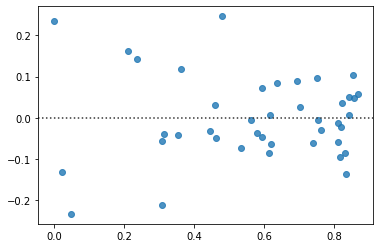

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 58 , error = 0.012705589535628972, training error = 0.0031237397963561377


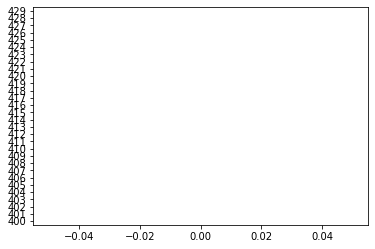

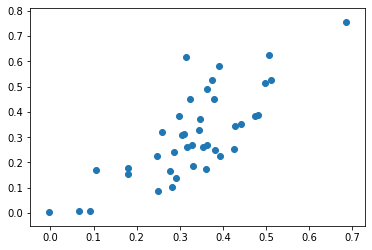

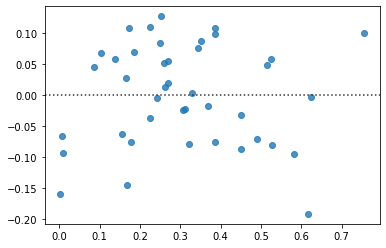

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 79 , error = 0.00782592609985527, training error = 0.00029511429371450657


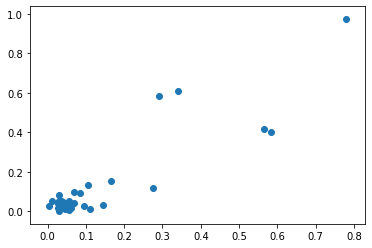

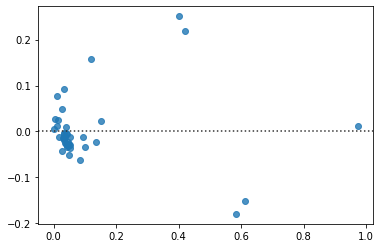

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 75 , error = 0.008552758192827584, training error = 0.00047871364263945404


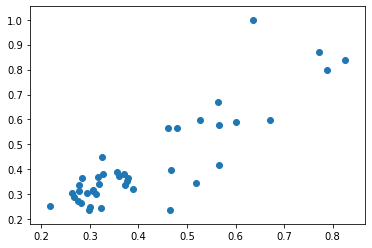

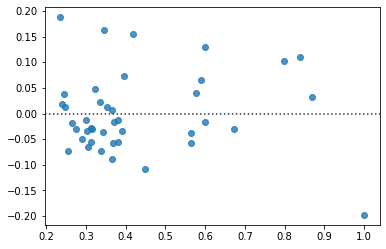

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 72 , error = 0.013546535874471329, training error = 0.0035914664310472207


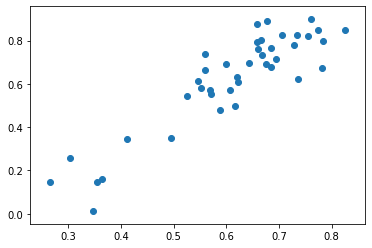

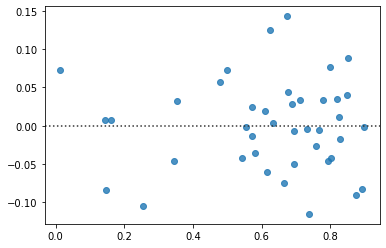

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 66 , error = 0.009895379851811603, training error = 0.00024050275709024306


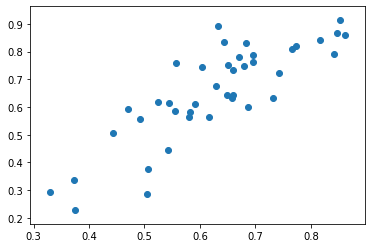

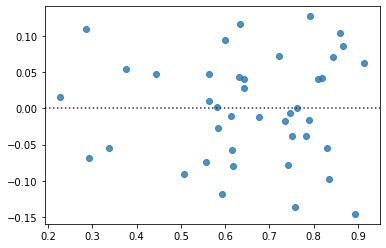

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 48 , error = 0.02557258084554247, training error = 0.0009275187580976576


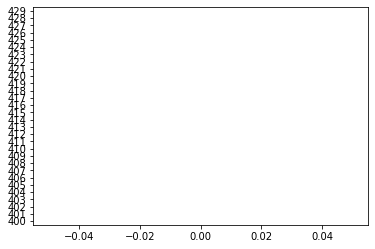

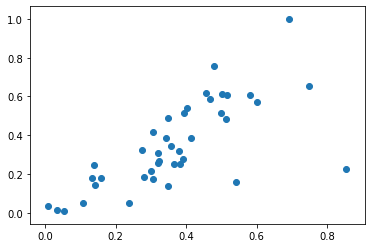

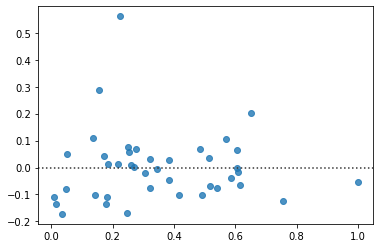

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 91 , error = 0.003111046565430876, training error = 1.8675419628076885e-05


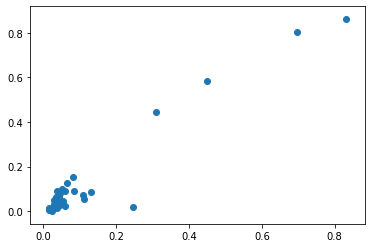

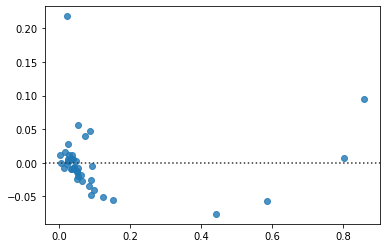

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 74 , error = 0.012661143017174914, training error = 0.0004153500895559905


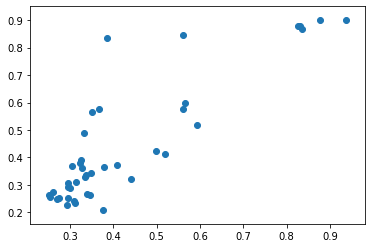

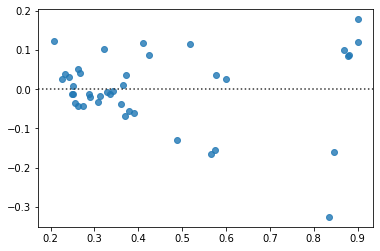

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 18 , error = 0.033185246803106944, training error = 0.0009249118287610119


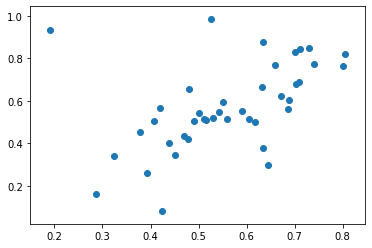

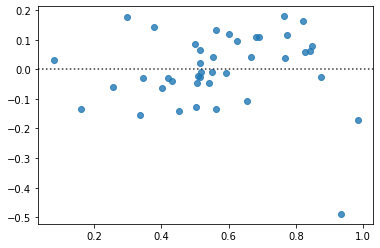

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 47 , error = 0.01878931534686681, training error = 2.1304774493906475e-05


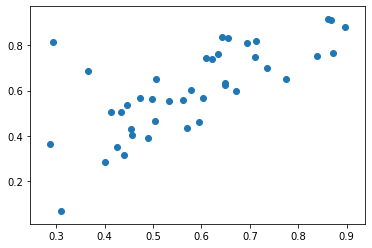

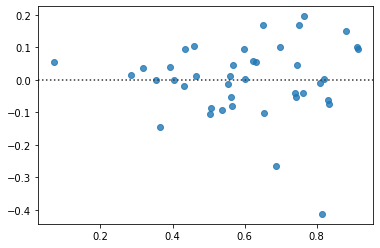

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 74 , error = 0.012881055770277365, training error = 0.00029741986533691865


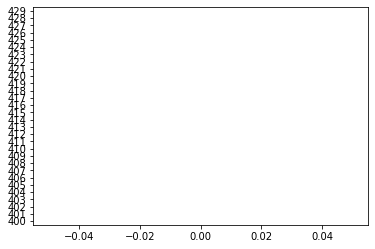

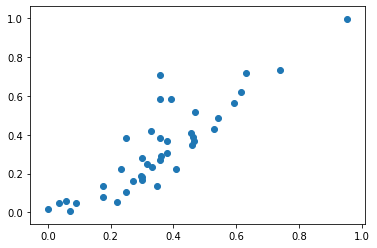

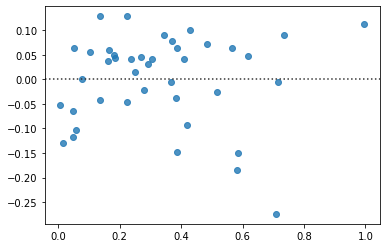

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 92 , error = 0.002776695630393852, training error = 1.4820791520970742e-05


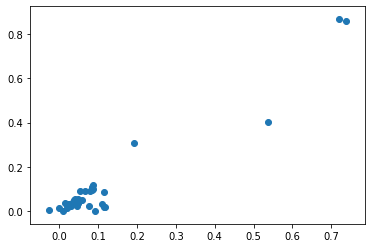

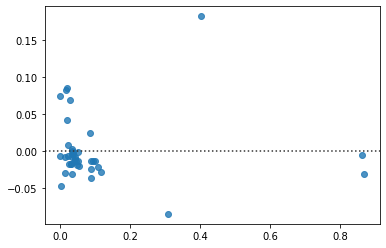

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 93 , error = 0.0033506019787939508, training error = 0.0005577413188531946


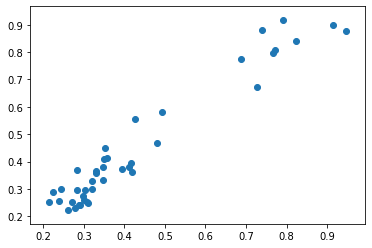

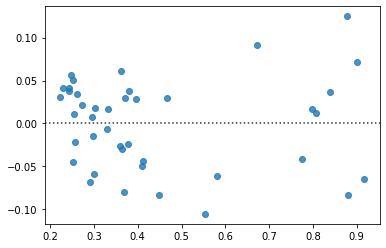

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 58 , error = 0.01862535118162777, training error = 0.0032547498104005543


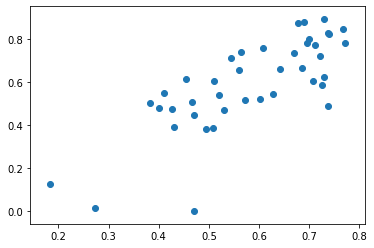

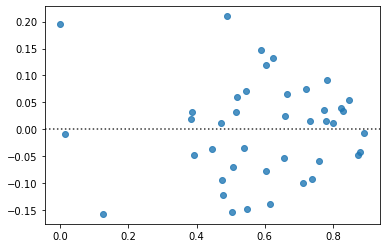

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 71 , error = 0.012480045667970056, training error = 4.67905133847857e-05


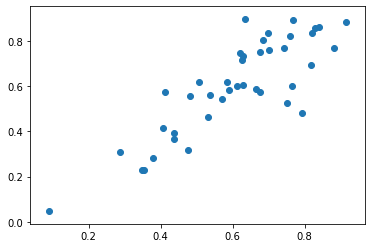

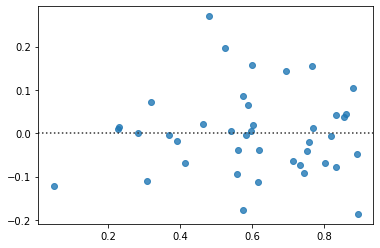

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 50 , error = 0.021053189945073873, training error = 0.00022717012697838813


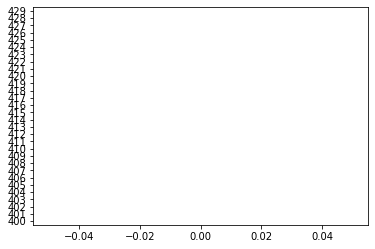

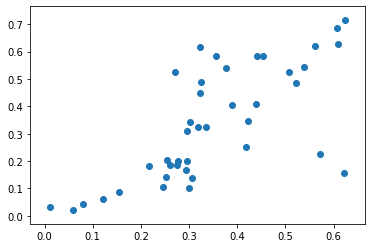

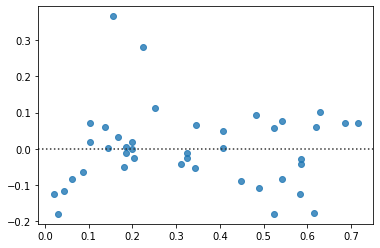

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 89 , error = 0.004550105300442635, training error = 0.00030868140277305487


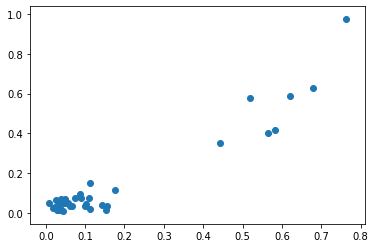

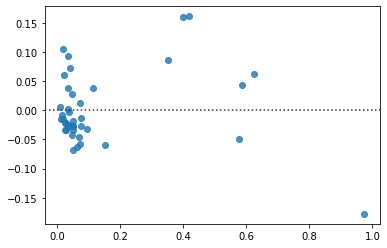

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 77 , error = 0.01112831440086536, training error = 0.0004147002112623664


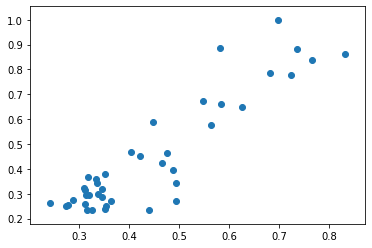

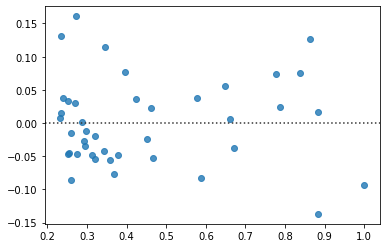

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 50 , error = 0.02443137298620077, training error = 0.00038698926246074863


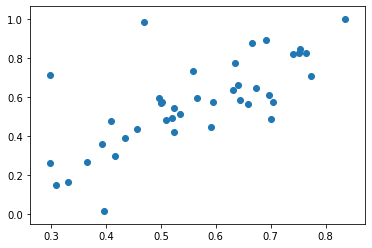

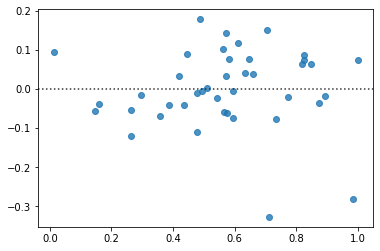

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 58 , error = 0.01665139643148268, training error = 2.4979080947470785e-05


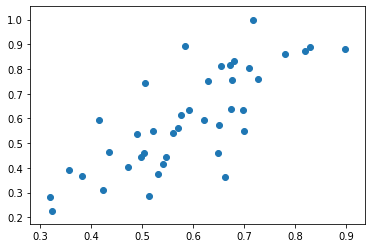

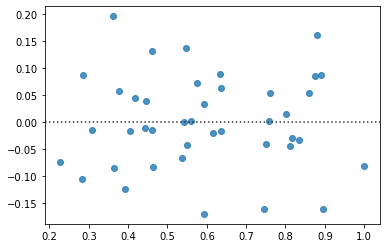

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 62 , error = 0.01857131255365756, training error = 0.0002496699780928496


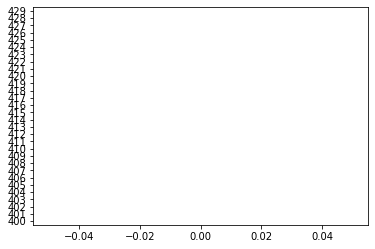

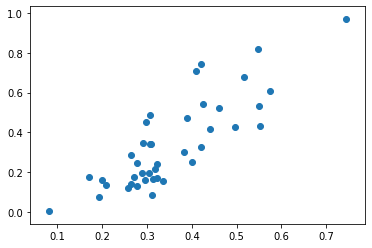

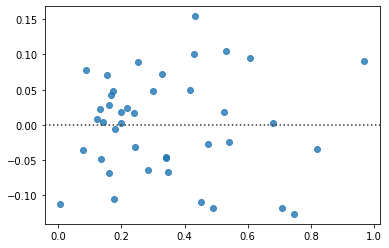

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 86 , error = 0.010147573885293559, training error = 1.3057322540313252e-05


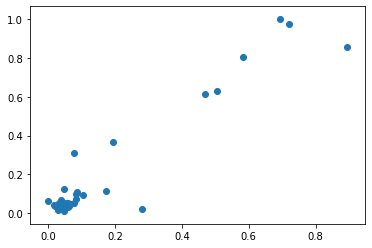

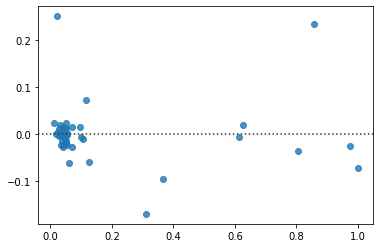

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 54 , error = 0.01364292209217097, training error = 3.0209196958263177e-05


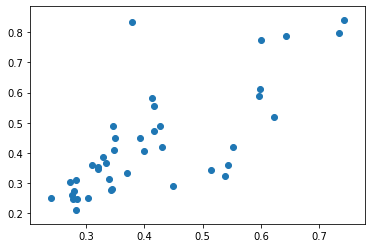

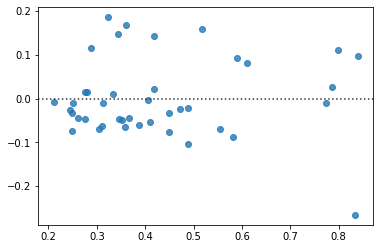

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 52 , error = 0.020718402019915934, training error = 0.0011512771115616877


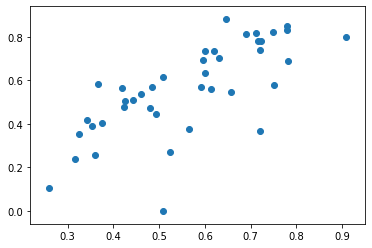

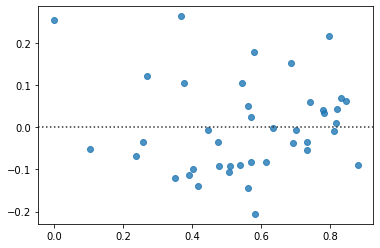

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 61 , error = 0.015139506118159618, training error = 0.00021215397780687835


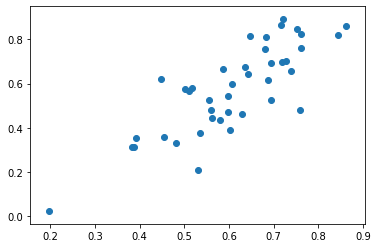

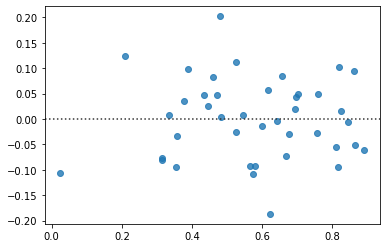

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 56 , error = 0.010514826297941976, training error = 0.0010755571183844374


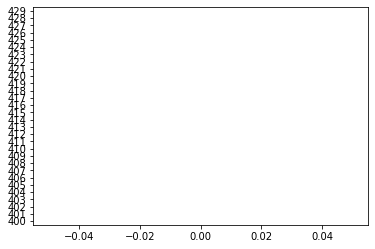

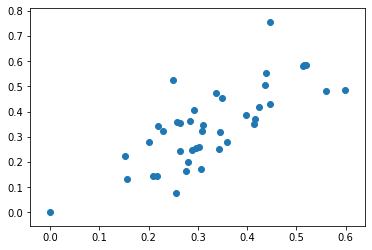

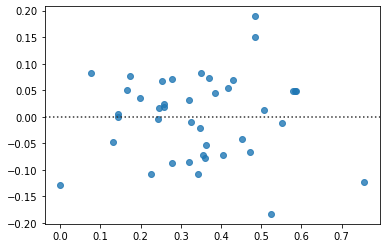

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 86 , error = 0.007885595437327251, training error = 0.00017225271220617619


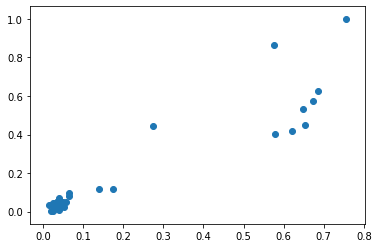

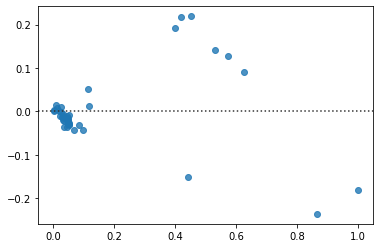

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 75 , error = 0.010160068228292669, training error = 0.00042576083097935696


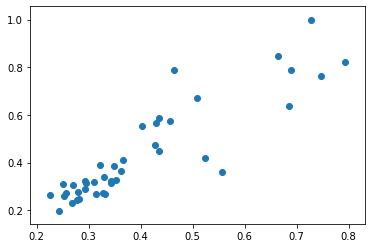

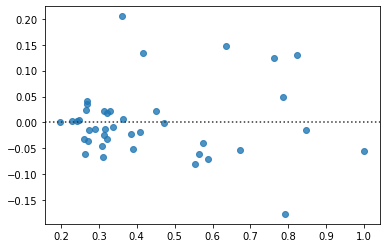

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 54 , error = 0.01796743113875281, training error = 0.0012116238864677185


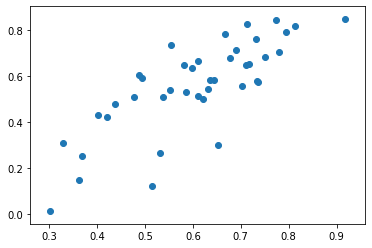

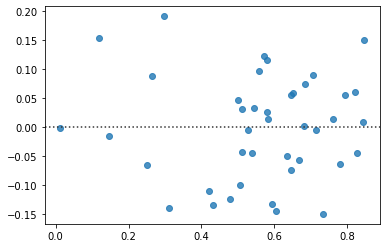

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 57 , error = 0.01229282937530844, training error = 0.0009246705796378196


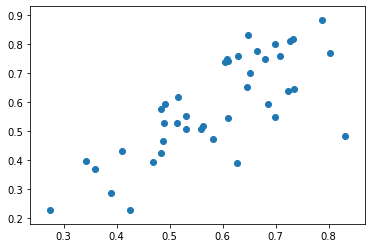

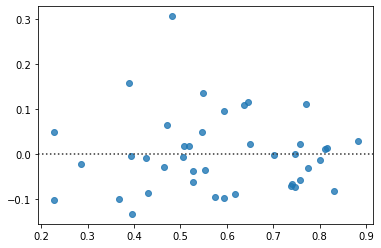

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 47 , error = 0.019359052270166835, training error = 0.001008934368092708


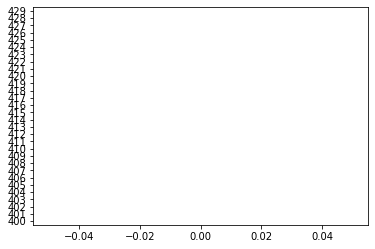

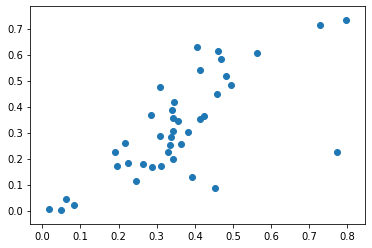

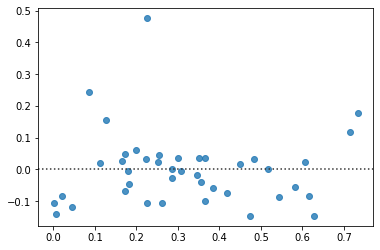

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 83 , error = 0.00970527715665426, training error = 0.0009018879571290091


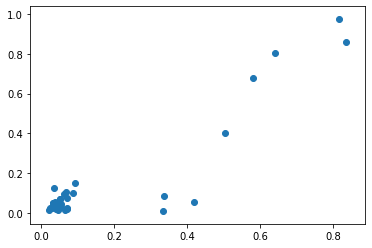

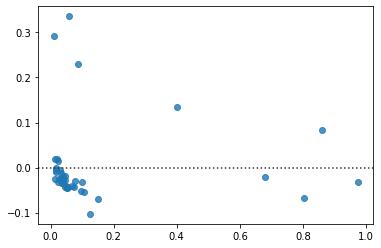

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 80 , error = 0.006644056912786114, training error = 0.0004787848254984574


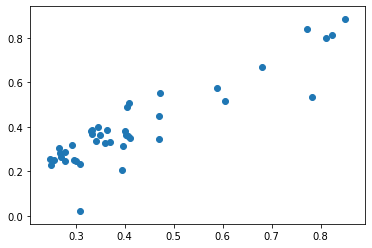

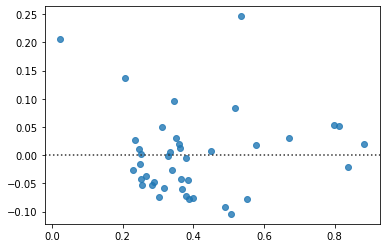

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 35 , error = 0.027945745269188606, training error = 0.0029756833230018425


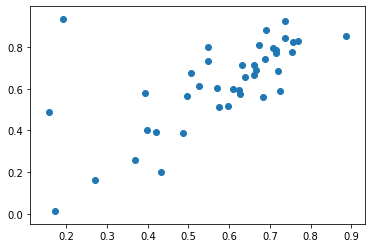

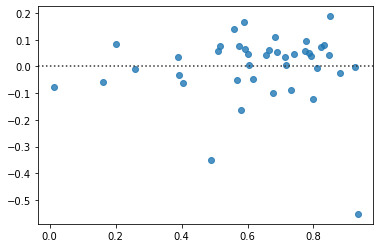

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 62 , error = 0.015071173859194915, training error = 0.0008546482881779087


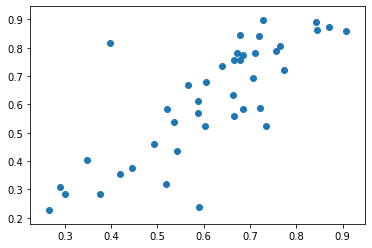

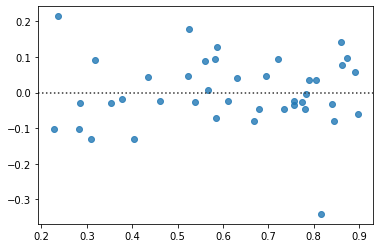

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 78 , error = 0.012129886821989865, training error = 0.003237612387064664


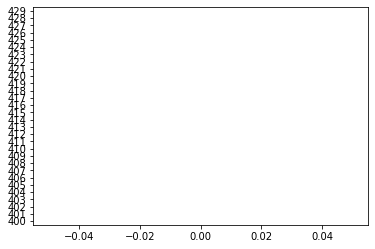

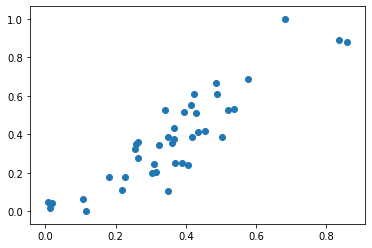

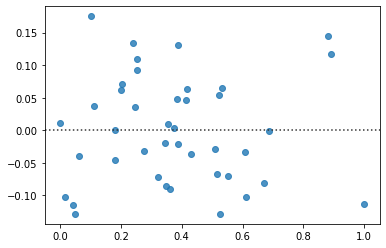

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 85 , error = 0.006661848945159344, training error = 0.00016111152608067327


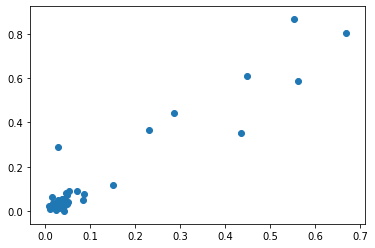

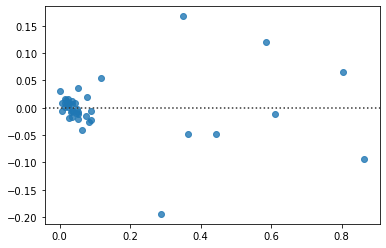

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 89 , error = 0.004519236756585142, training error = 0.0005683208374937135


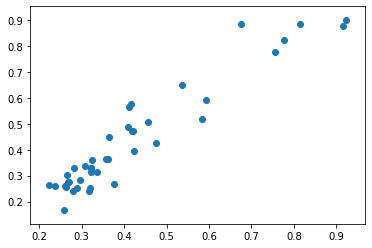

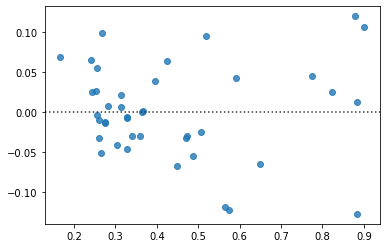

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 68 , error = 0.010167667017847335, training error = 0.0013709687303603676


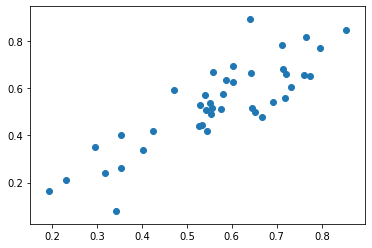

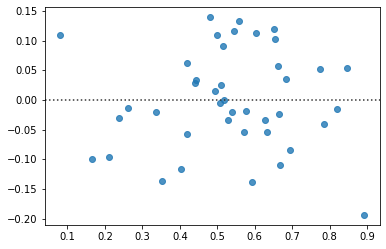

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 70 , error = 0.013300116510736757, training error = 0.0001831048524217247


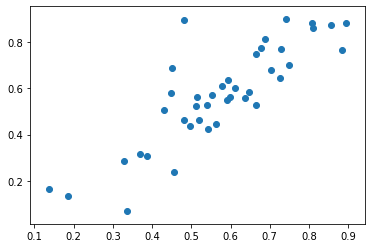

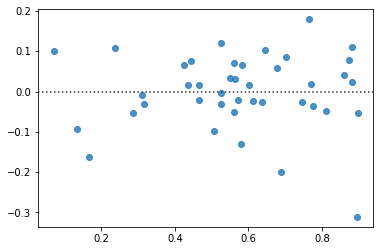

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 74 , error = 0.011783123087753549, training error = 0.003467103534762506


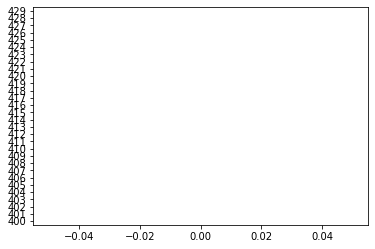

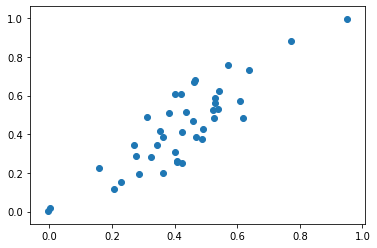

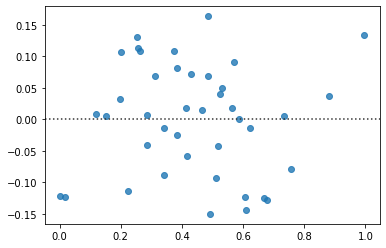

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 67 , error = 0.0022043692150868215, training error = 0.00017560613700959597


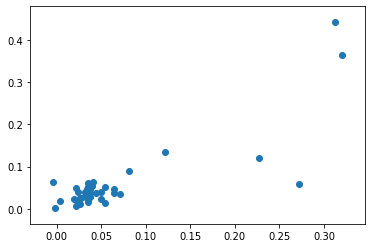

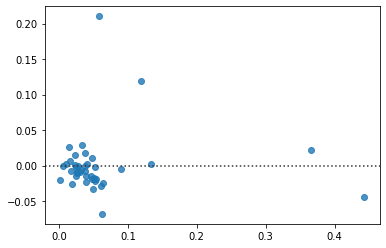

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 78 , error = 0.004577376593513683, training error = 0.0004461322204897408


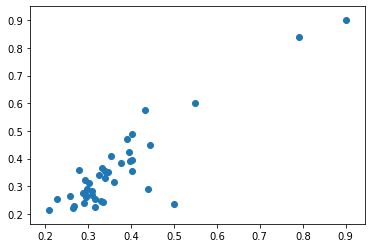

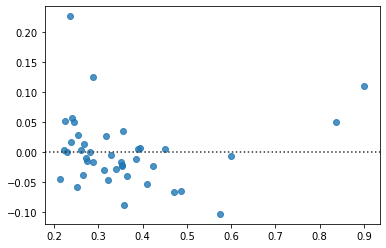

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 70 , error = 0.010943941523147824, training error = 0.0013854104064711108


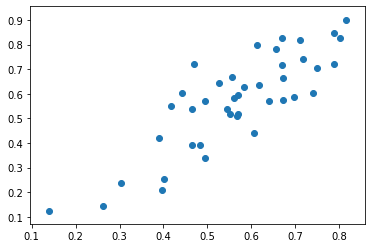

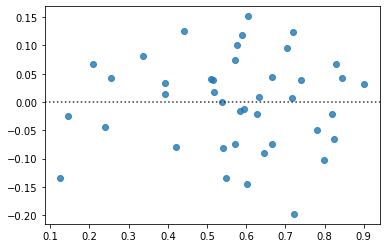

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 77 , error = 0.009134345621543506, training error = 0.0002475135314287317


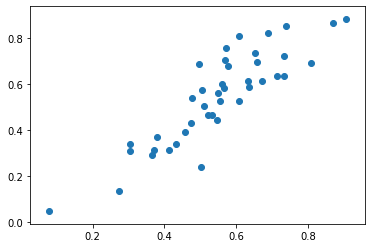

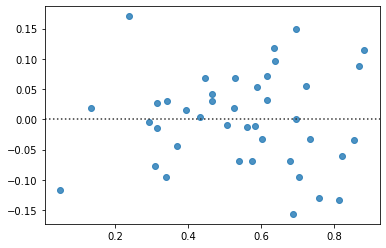

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 79 , error = 0.011472414808662491, training error = 0.0013805675277790254


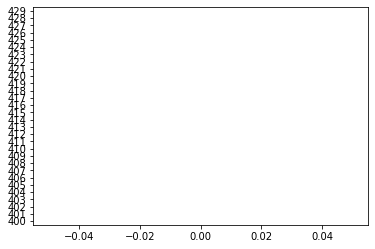

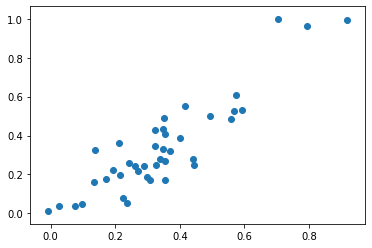

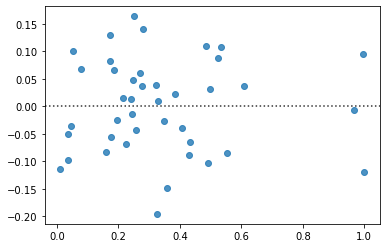

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 75 , error = 0.005808967183131578, training error = 2.346658491753015e-05


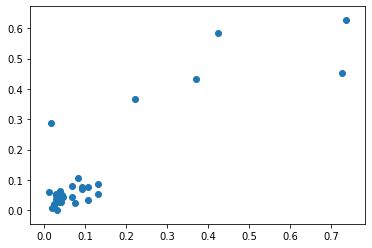

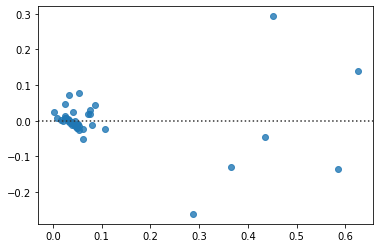

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 80 , error = 0.009636531040359097, training error = 0.00045026521185747095


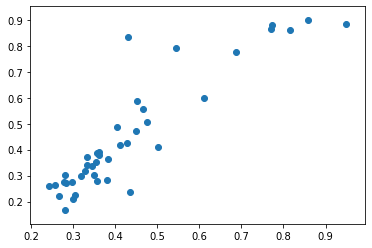

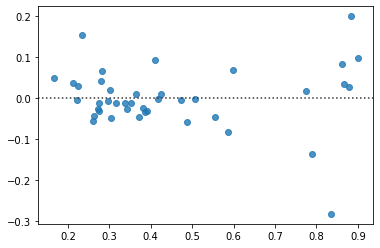

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 72 , error = 0.014442777001303315, training error = 0.003735287961200747


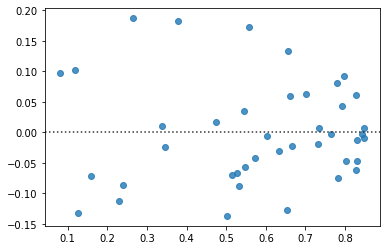

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 77 , error = 0.01155273228770508, training error = 0.000222162861802371


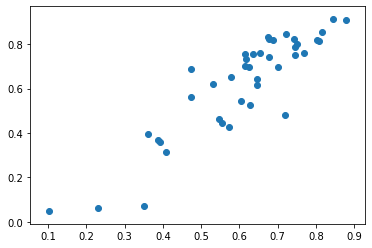

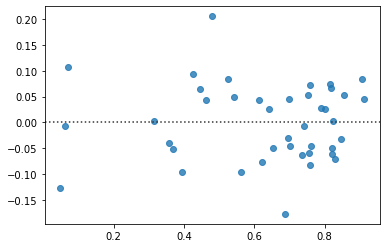

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 80 , error = 0.01067213383170245, training error = 0.0012437472688073565


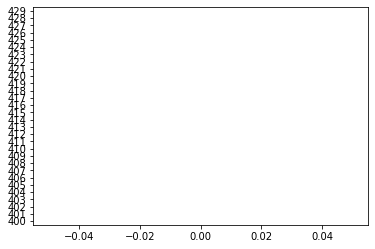

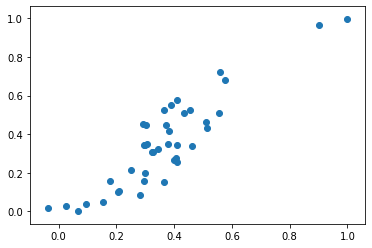

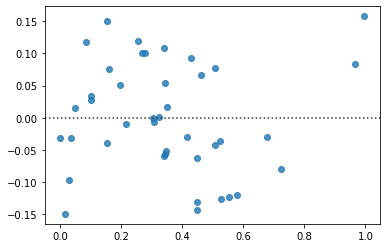

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 77 , error = 0.007307599320486773, training error = 2.1241229408335507e-05


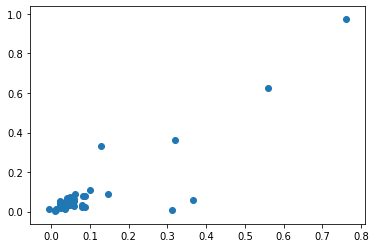

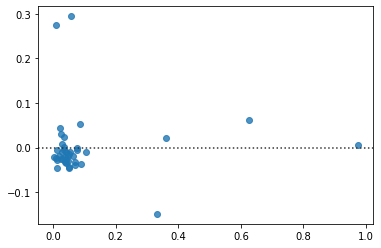

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 83 , error = 0.006945037028017599, training error = 0.00047474523295037535


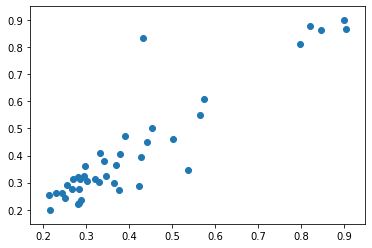

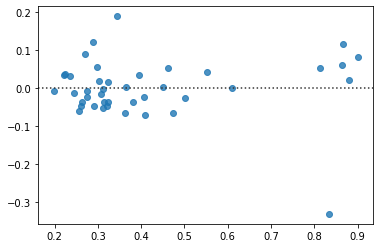

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 63 , error = 0.012912270997279998, training error = 0.001303860172599129


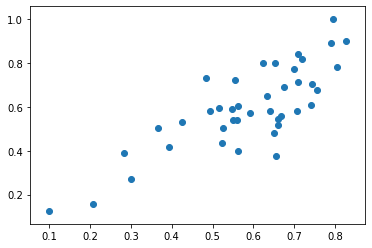

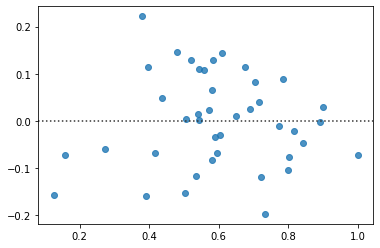

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 74 , error = 0.012498275128318982, training error = 0.00028731871172042457


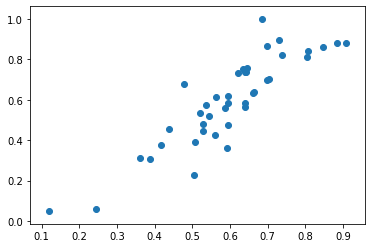

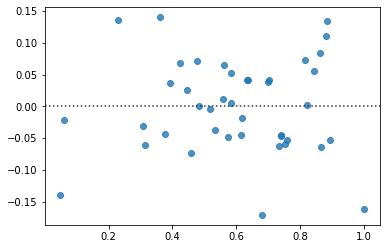

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 62 , error = 0.021592389150296716, training error = 0.0010369617902807268


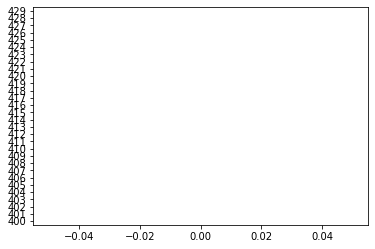

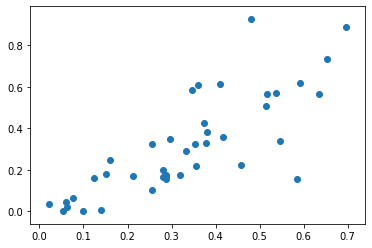

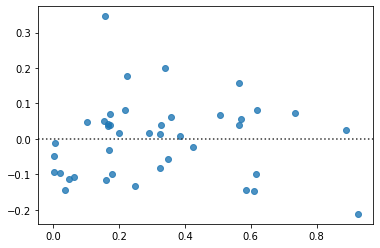

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 96 , error = 0.001059934889904029, training error = 1.7641076150237503e-05


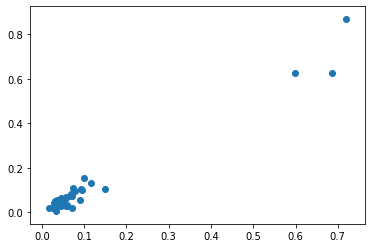

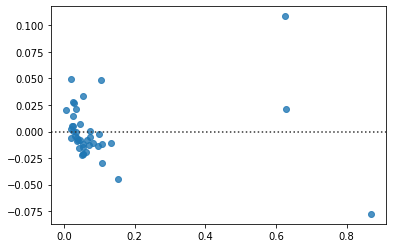

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 79 , error = 0.010296344166564952, training error = 0.0004776086502515758


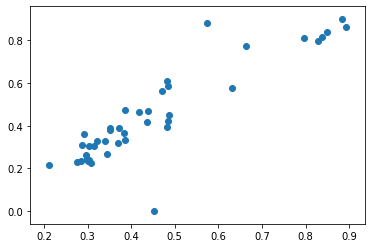

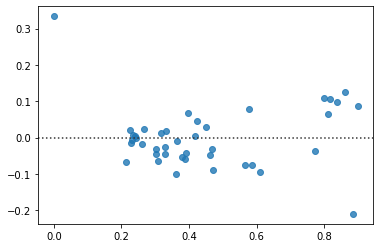

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 45 , error = 0.02074536624719221, training error = 0.0013883464488799104


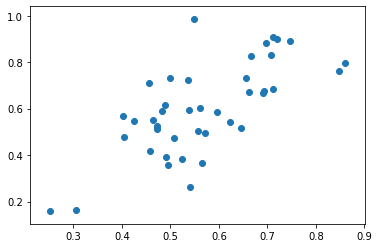

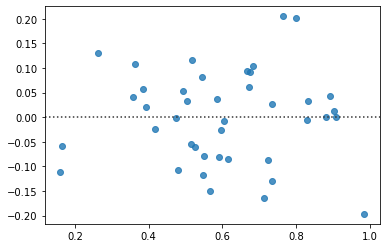

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 75 , error = 0.013728896652502962, training error = 0.0009439868438959714


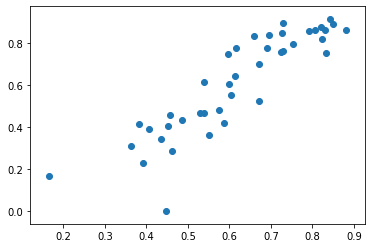

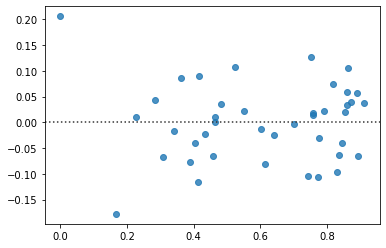

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 66 , error = 0.017882845424519112, training error = 0.0010852457959160445


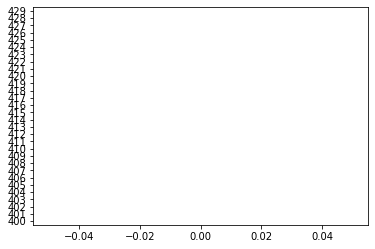

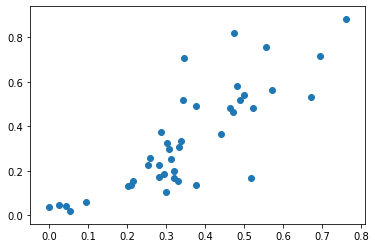

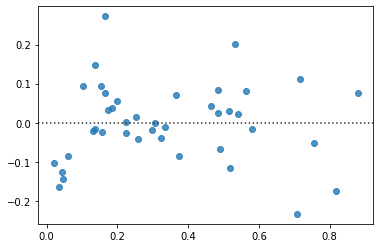

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 85 , error = 0.006642414927938173, training error = 1.3403547806548638e-05


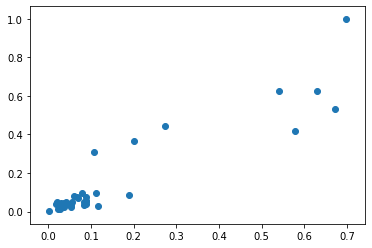

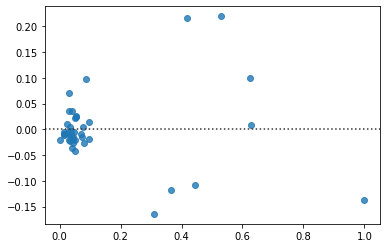

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 82 , error = 0.010281398583279776, training error = 0.0010892056748811817


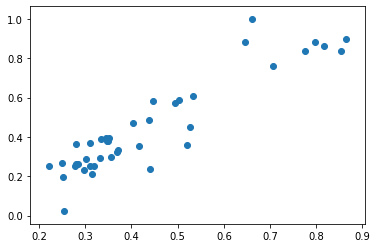

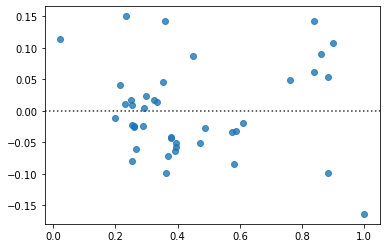

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 58 , error = 0.02140867600671997, training error = 0.001173261076732947


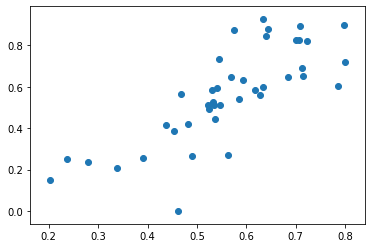

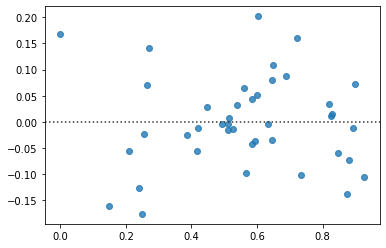

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 74 , error = 0.011412080976427723, training error = 0.00019626480209369705


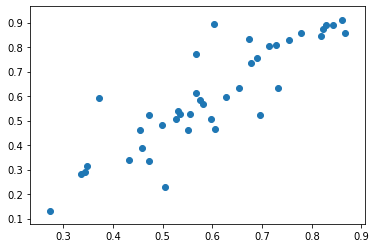

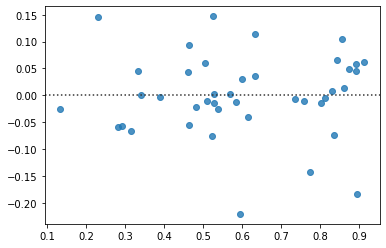

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 71 , error = 0.013229490739225176, training error = 0.003315914568033925


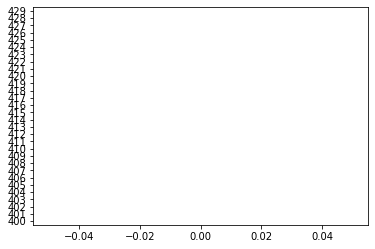

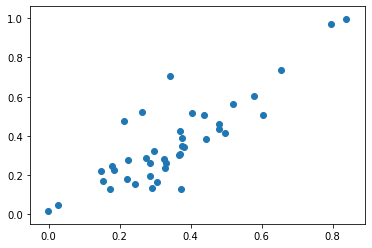

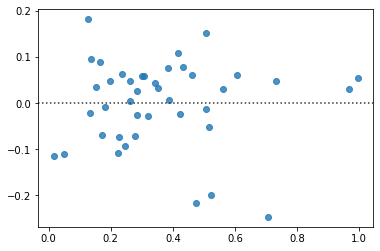

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 83 , error = 0.010396407753751159, training error = 0.0008472109219279417


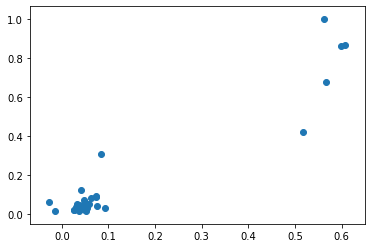

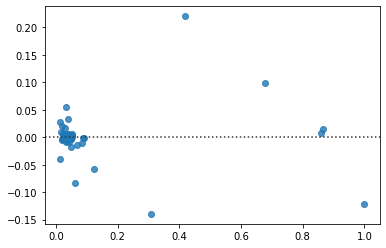

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 80 , error = 0.0063182971179952625, training error = 0.0003958939388291289


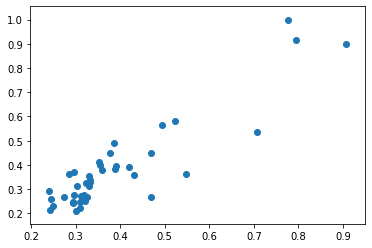

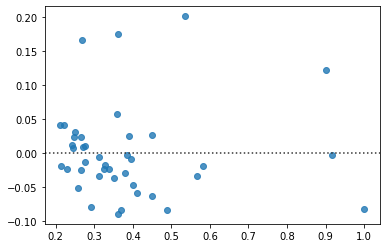

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 53 , error = 0.021029883253775913, training error = 0.0034941741695353693


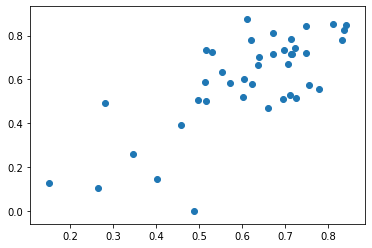

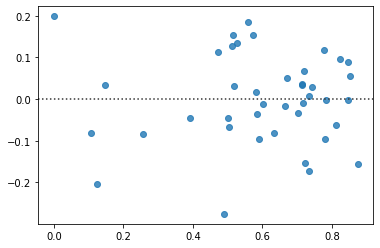

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 65 , error = 0.014082683466649919, training error = 0.0002433049515455137


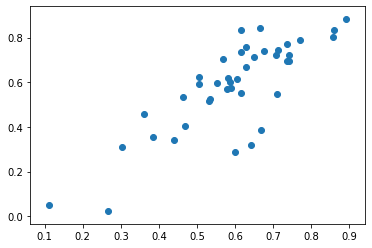

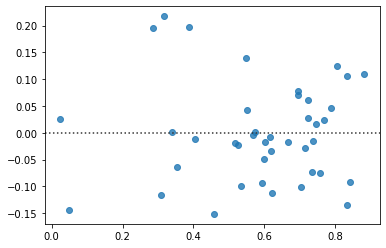

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 39 , error = 0.027931443858699345, training error = 0.0023247888835233855


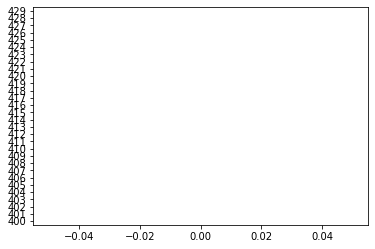

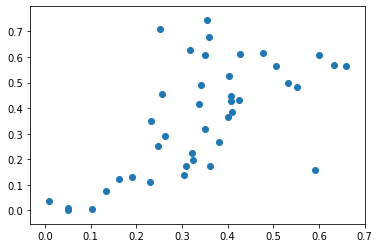

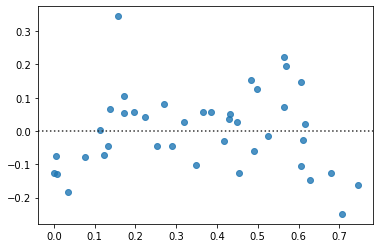

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 82 , error = 0.010078871952568638, training error = 0.00014135920343931273


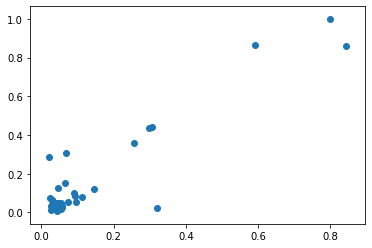

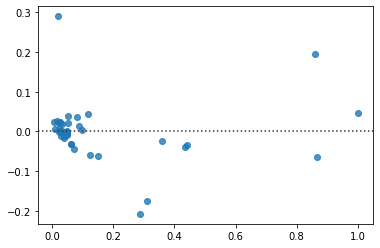

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 78 , error = 0.007501664176747476, training error = 0.0011903694451548613


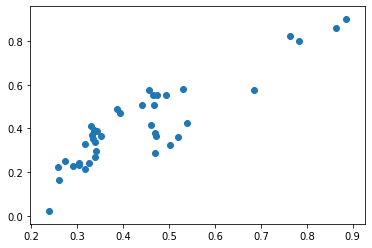

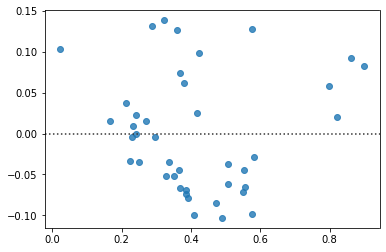

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 42 , error = 0.027324518690465323, training error = 0.0027929210835612047


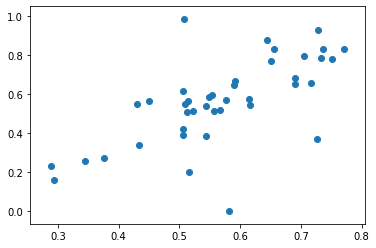

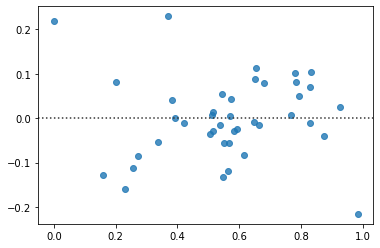

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 50 , error = 0.021725263561997443, training error = 0.001001774405992699


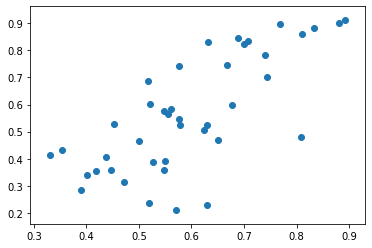

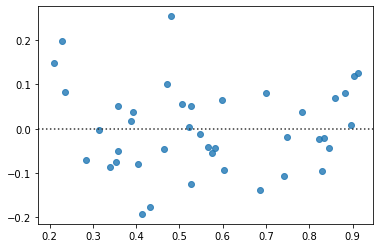

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 71 , error = 0.015442199759111094, training error = 0.0032313989897171606


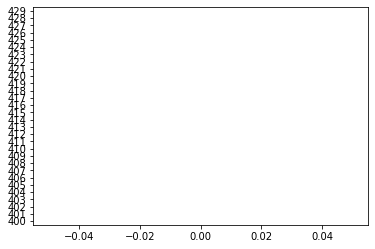

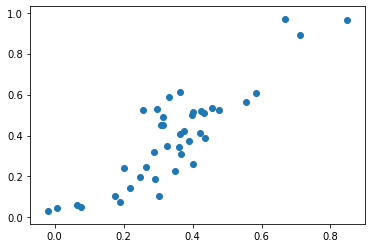

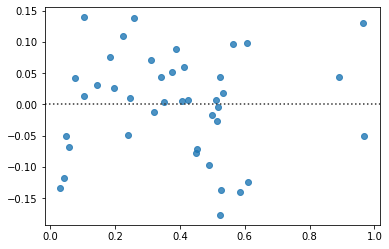

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 84 , error = 0.0010579542082331265, training error = 1.2636831187404524e-05


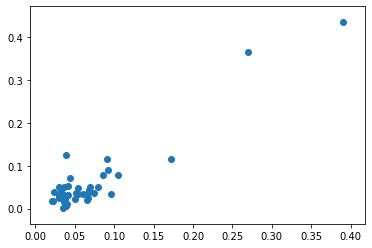

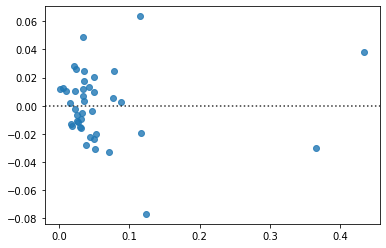

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 84 , error = 0.005440901489567335, training error = 0.0004813126197876988


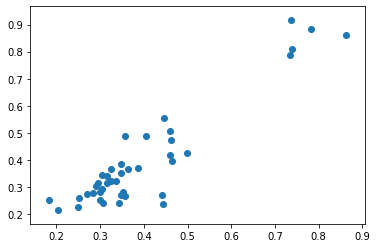

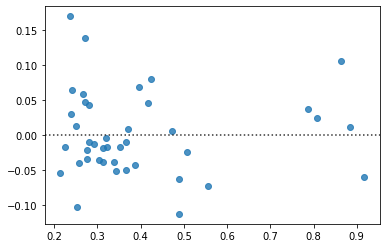

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 76 , error = 0.010534878181353293, training error = 0.003694341165174819


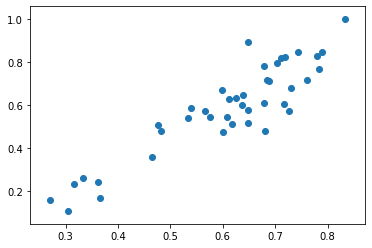

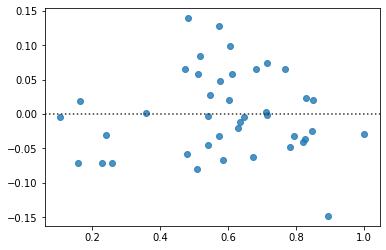

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 74 , error = 0.012685700988841987, training error = 0.0010118420041811248


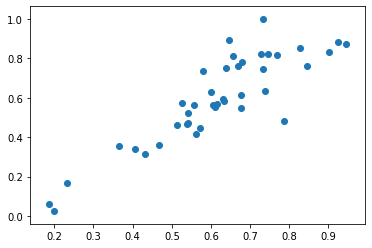

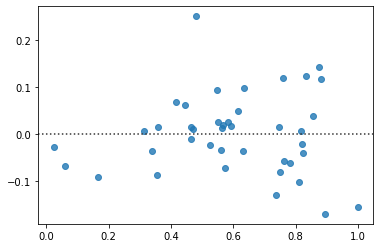

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 57 , error = 0.02166142178506438, training error = 0.00032109946789825615


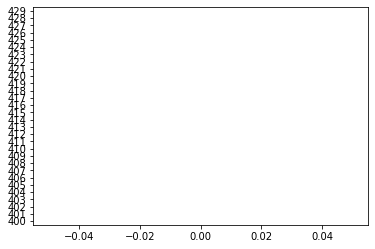

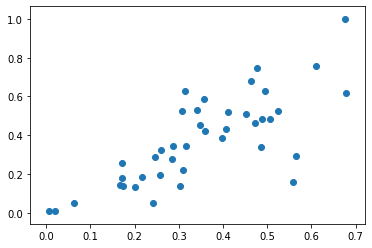

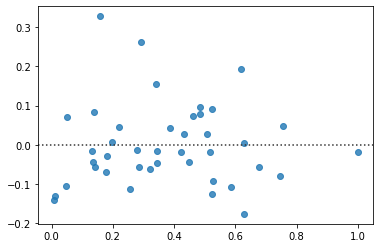

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 88 , error = 0.007607941144298798, training error = 0.00020397280232325638


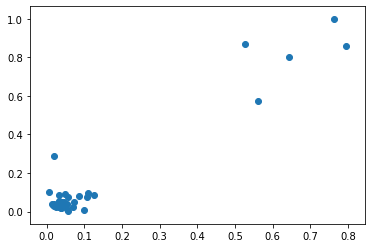

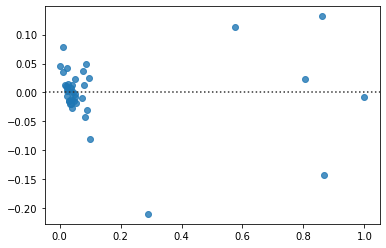

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 89 , error = 0.004767950374006192, training error = 0.001576615143637709


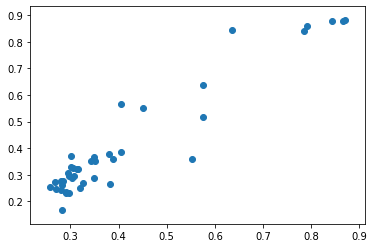

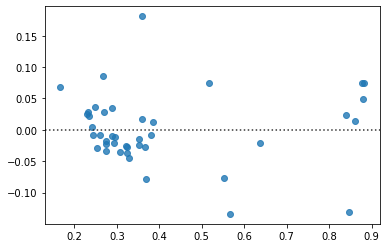

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
fixed carbon : R_Square = 46 , error = 0.018450228890437445, training error = 0.001079752161330515


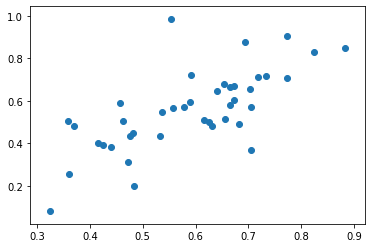

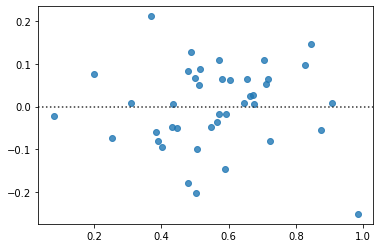

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 63 , error = 0.015363617366159554, training error = 0.00023605164320221478


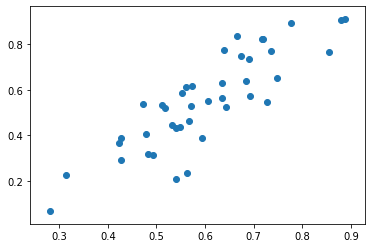

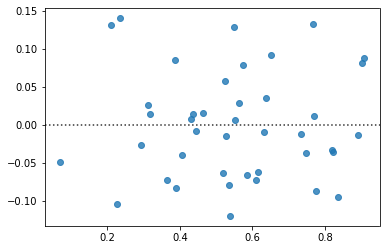

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 63 , error = 0.015104039275341938, training error = 0.003355585032643129


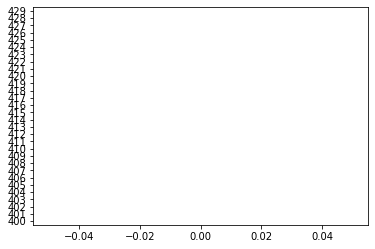

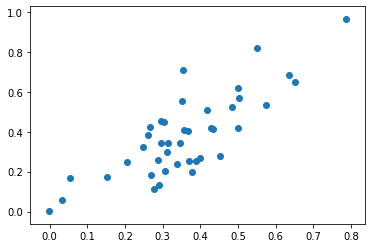

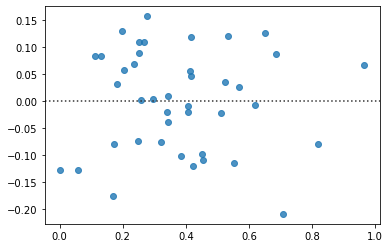

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 87 , error = 0.005417348876500464, training error = 2.7972157789523187e-05


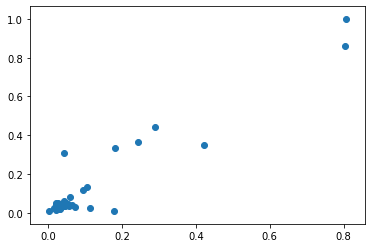

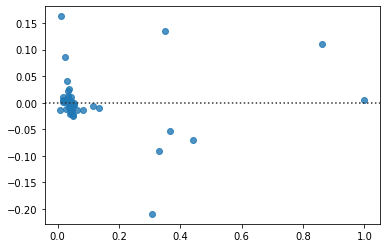

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 79 , error = 0.004454542490939759, training error = 3.686978869507539e-05


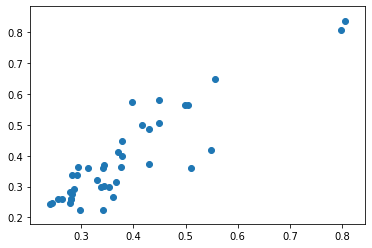

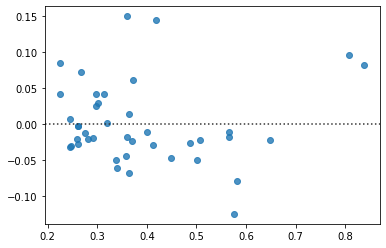

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 65 , error = 0.011344607203258531, training error = 0.0035310213137552428


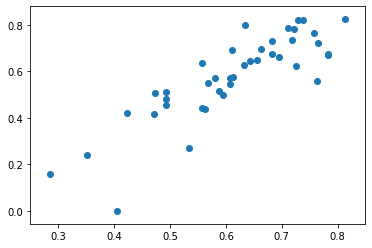

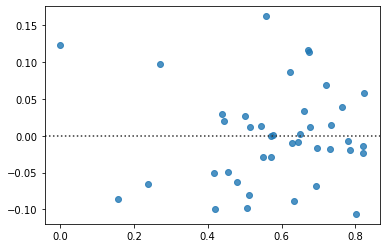

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 62 , error = 0.012433392020119432, training error = 0.00324174799699937


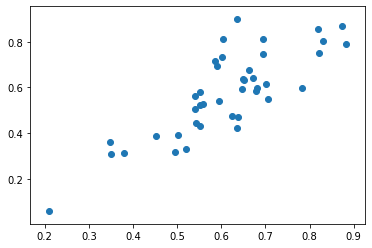

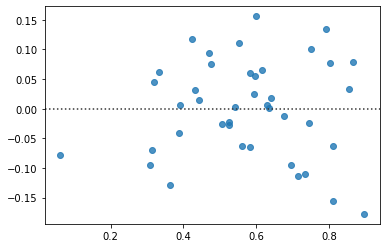

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 79 , error = 0.009660237803539687, training error = 0.00024130771674728328


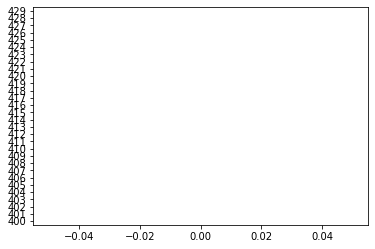

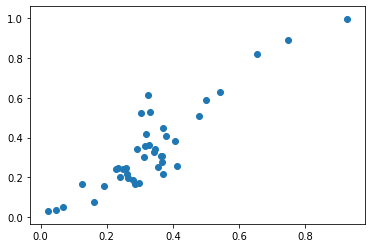

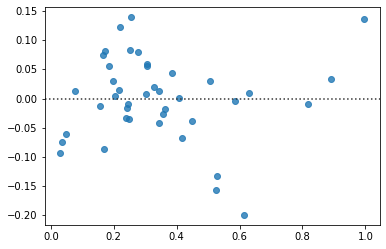

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 82 , error = 0.0036322657762091035, training error = 0.0009571644968375554


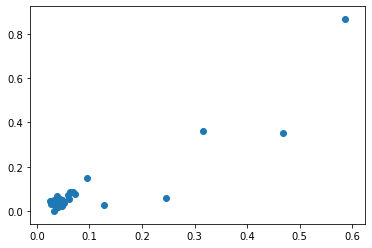

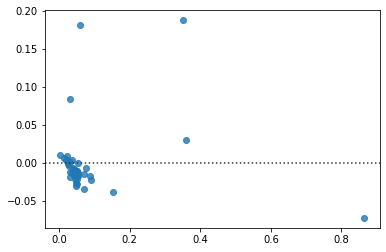

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 81 , error = 0.006035066756619598, training error = 0.0004736410651328807


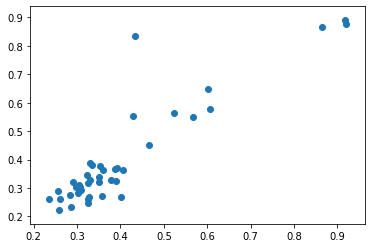

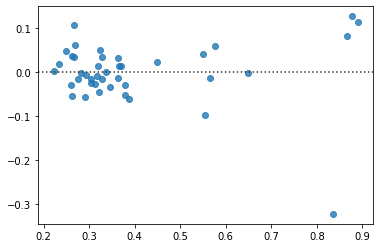

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 78 , error = 0.009229346940205881, training error = 0.0002639078779658136


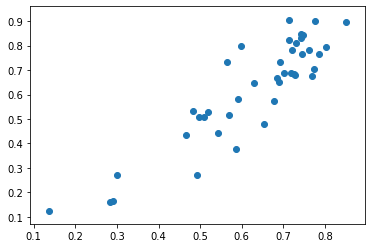

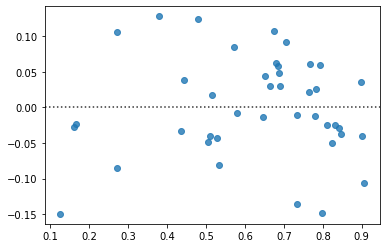

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
calorific value : R_Square = 78 , error = 0.008436859625858007, training error = 2.4893249201117838e-05


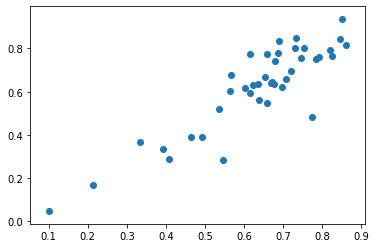

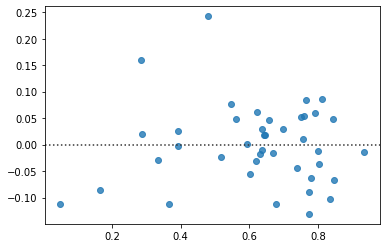

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 51 , error = 0.026011979709803915, training error = 8.813475979962315e-06


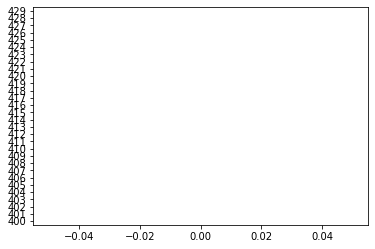

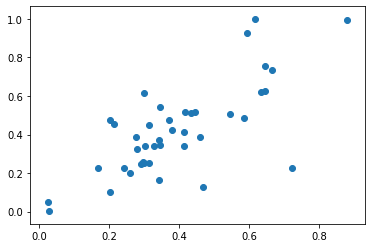

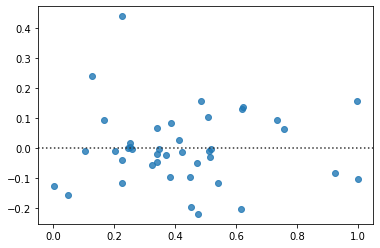

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 83 , error = 0.005300640897607288, training error = 0.0002571108417456033


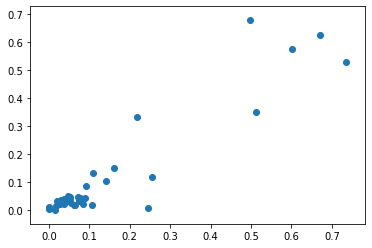

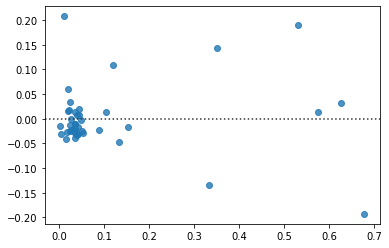

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
volatile matter : R_Square = 65 , error = 0.011685993845541936, training error = 0.00039294925065060517


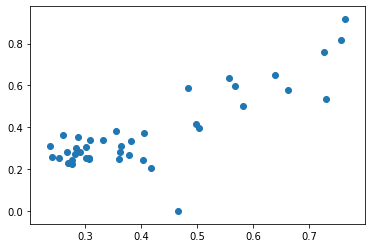

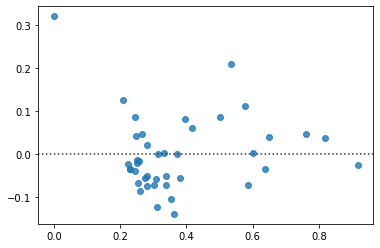

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 47 , error = 0.026218113336071422, training error = 0.0027970635803688665


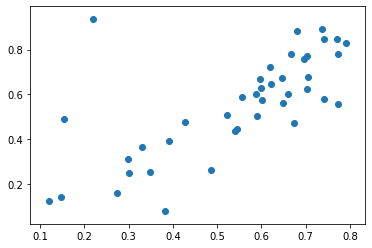

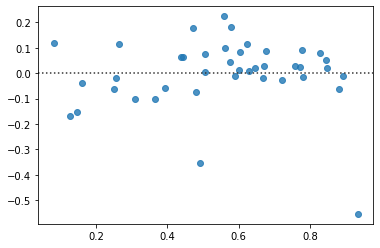

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 62 , error = 0.016643461907106277, training error = 0.00010694976659884126


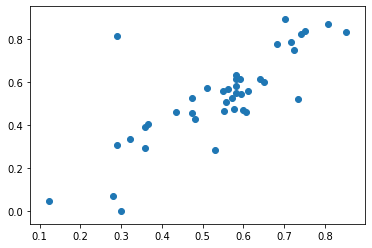

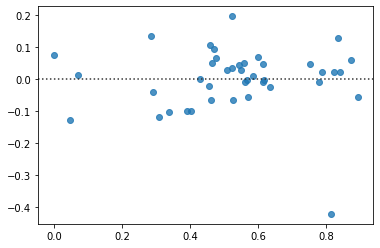

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
ash content : R_Square = 63 , error = 0.016493944512538855, training error = 3.550828367556631e-05


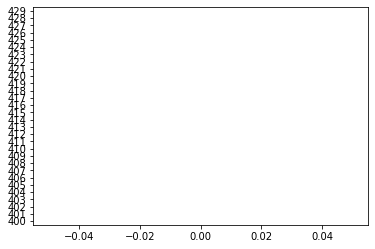

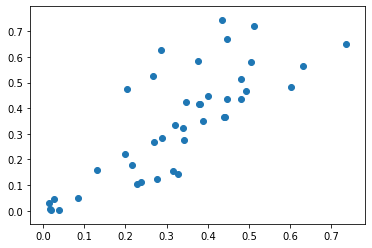

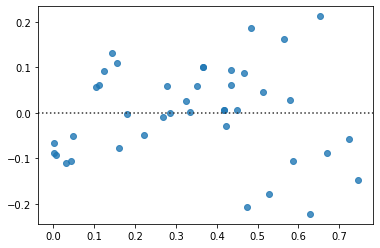

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 3500, 'subsample': 0.6}
moisture : R_Square = 90 , error = 0.003642568131735642, training error = 0.00033587678029553097


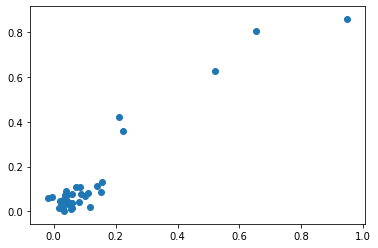

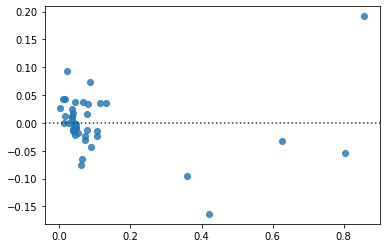

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
volatile matter : R_Square = 87 , error = 0.006463024537091936, training error = 0.0013353846835025595


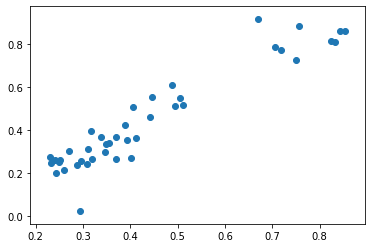

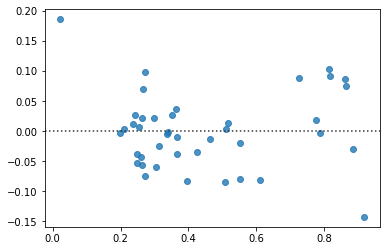

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
fixed carbon : R_Square = 41 , error = 0.016105466158282265, training error = 0.003555962171145759


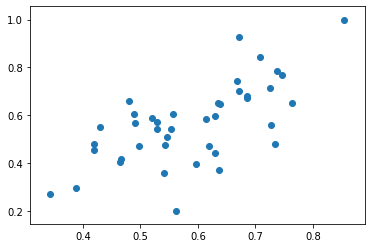

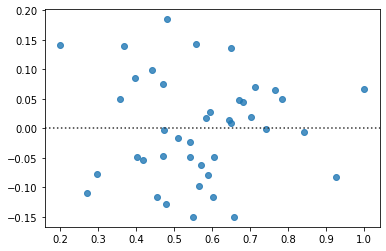

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
calorific value : R_Square = 62 , error = 0.017968273066862453, training error = 0.00019346011438136547


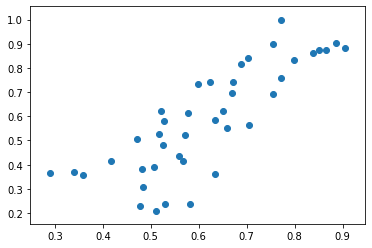

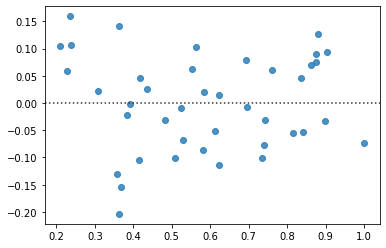

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
ash content : R_Square = 78 , error = 0.00895833044664156, training error = 0.0002442545806146459


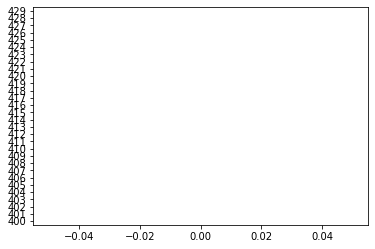

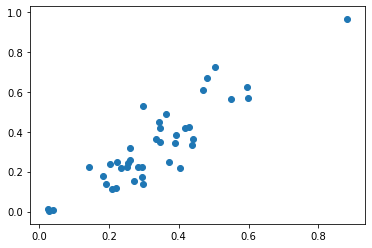

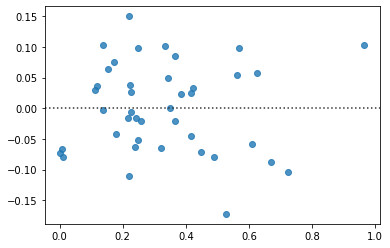

{'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.6}
moisture : R_Square = 82 , error = 0.004544788550817396, training error = 0.00012309318648682786


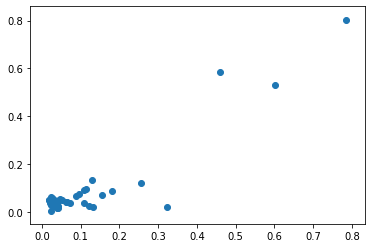

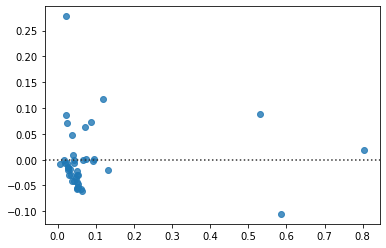

KeyboardInterrupt: 

In [45]:
for i in range(30):
    xgb_regression(df2, 2)
    i = i + 1

In [7]:

def remove_outlier(df):
    for i in range(5):
        z = np.abs(stats.zscore(df.iloc[:,-5+i].values))
        threshold = 3
        idx = (np.where(z > threshold)[0])
        indexes_to_keep = set(range(df.shape[0])) - set(idx)
        df = df.take(list(indexes_to_keep))

#     df[df==np.inf]=np.nan
#     df =  df.fillna(df.mean(), inplace=True)
    
    return df
xls = pd.ExcelFile('Abs after preprocessing-6.11.2019.xlsx')
df4 = remove_outlier(pd.read_excel(xls, 'Abs-SG(2-9)'))
df5 = remove_outlier(pd.read_excel(xls, 'Abs-SG(2-9)-BC(offset)'))
df6 = remove_outlier(pd.read_excel(xls, 'Abs-SG(2-9),MSC'))


ash content : R_Square = 28 , error = 0.02794020217639061, training error = 0.01100029325175999


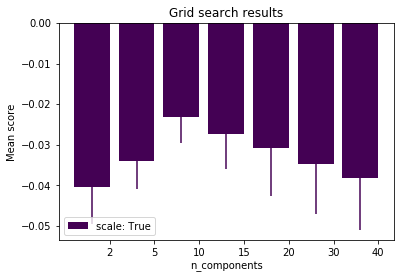

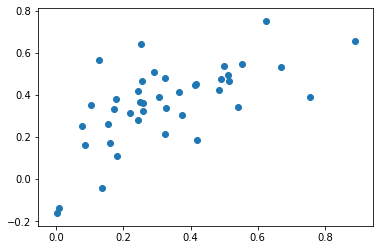

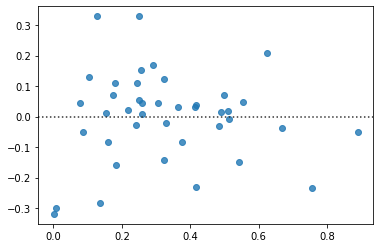

moisture : R_Square = 83 , error = 0.012822663982773506, training error = 0.002001109120537737


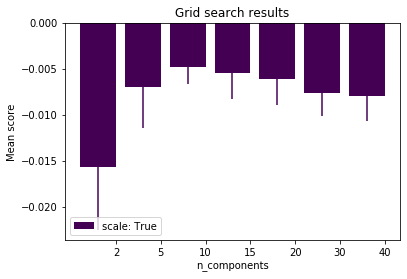

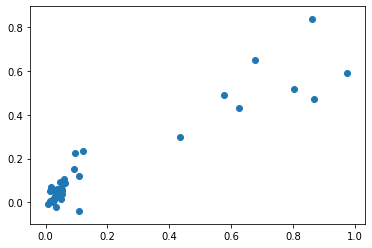

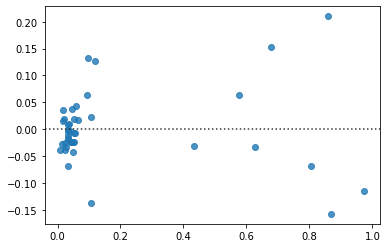

volatile matter : R_Square = 70 , error = 0.008924637699163459, training error = 0.001919811562368728


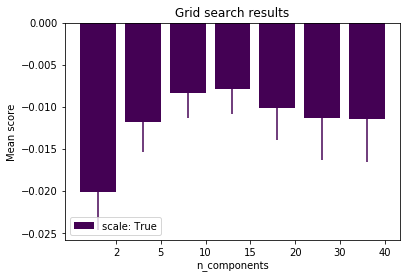

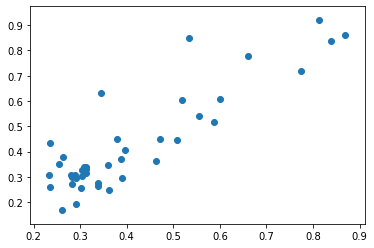

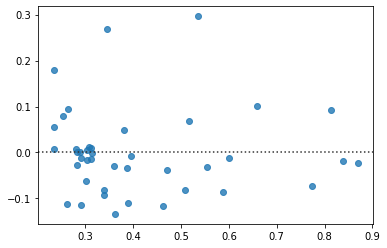

fixed carbon : R_Square = 26 , error = 0.030349656788011454, training error = 0.011296045381201547


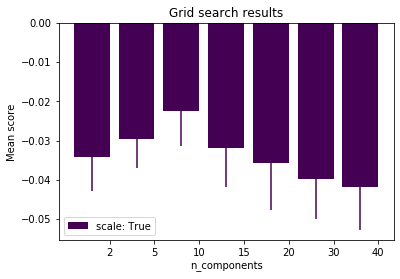

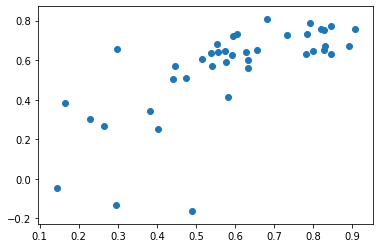

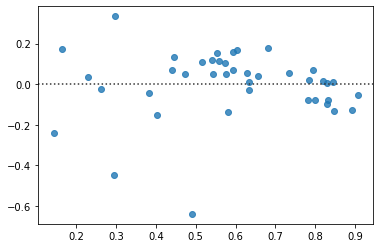

calorific value : R_Square = 23 , error = 0.030157355324664455, training error = 0.009711538973643949


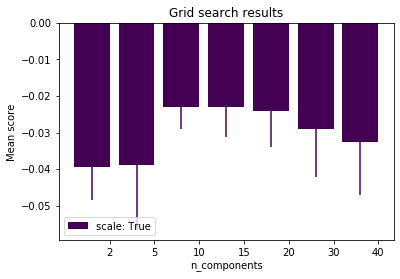

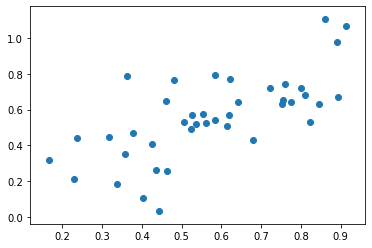

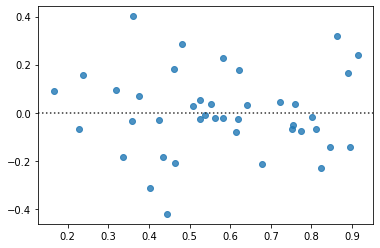

ash content : R_Square = 64 , error = 0.027461064963344228, training error = 0.00961711454879285


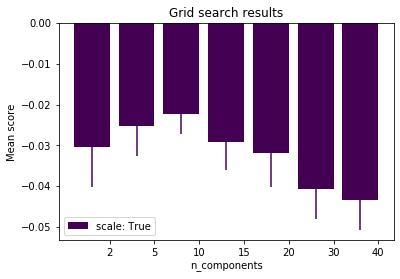

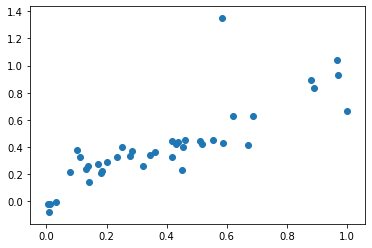

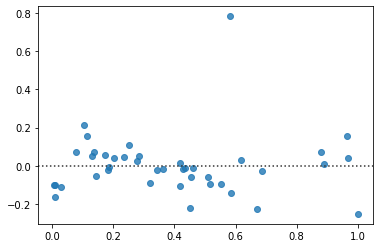

moisture : R_Square = 94 , error = 0.0023286265416680215, training error = 0.003994459957786292


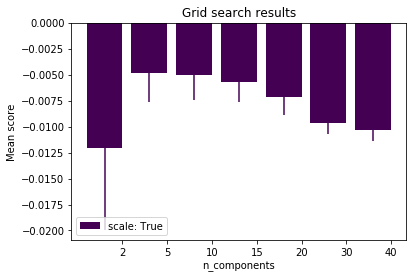

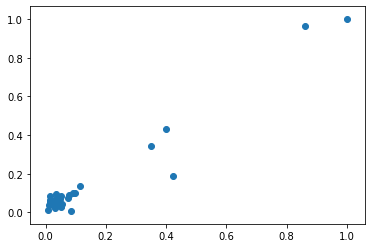

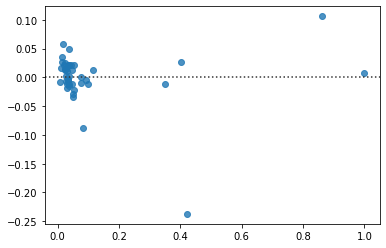

volatile matter : R_Square = 77 , error = 0.007897000412772578, training error = 0.003407417811521134


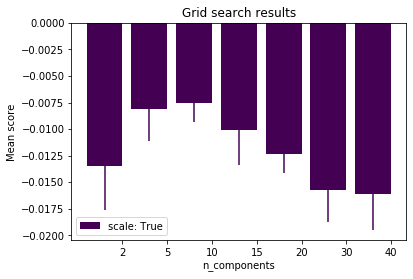

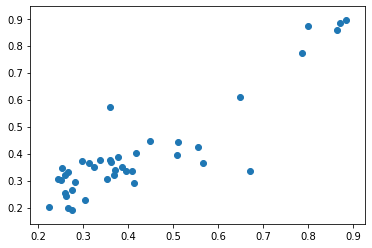

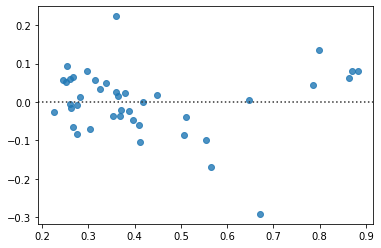

fixed carbon : R_Square = 30 , error = 0.032574820791412606, training error = 0.02096541735451596


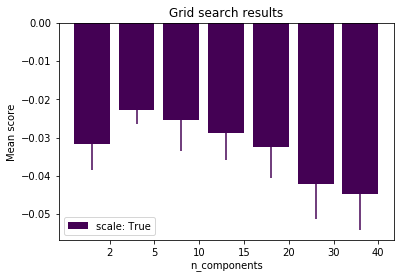

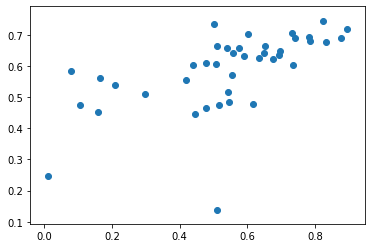

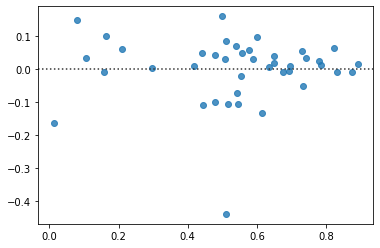

calorific value : R_Square = 49 , error = 0.03285534416727825, training error = 0.009085817547217455


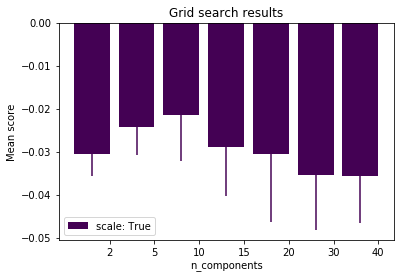

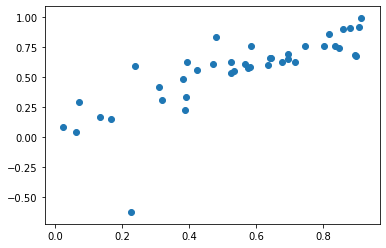

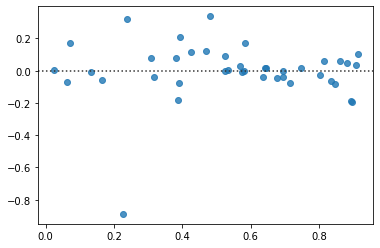

ash content : R_Square = 43 , error = 0.01612084586588952, training error = 0.009980623595530338


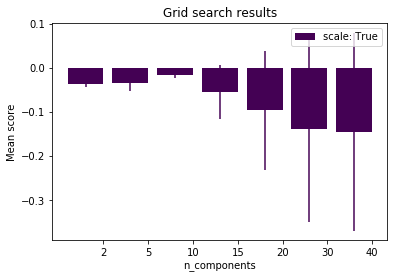

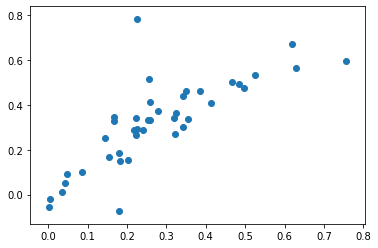

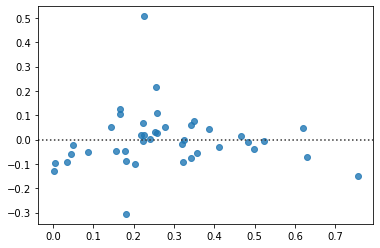

moisture : R_Square = 93 , error = 0.004645996537997858, training error = 0.003177838565919295


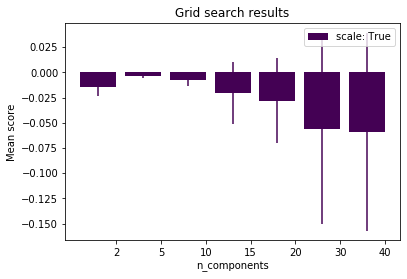

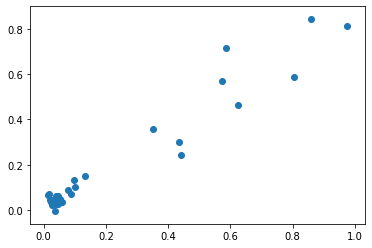

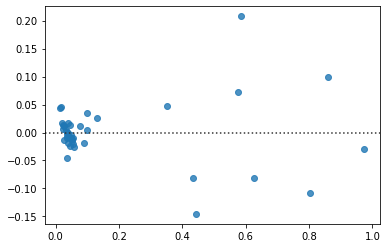

volatile matter : R_Square = 67 , error = 0.013702345523693876, training error = 0.008202126700931298


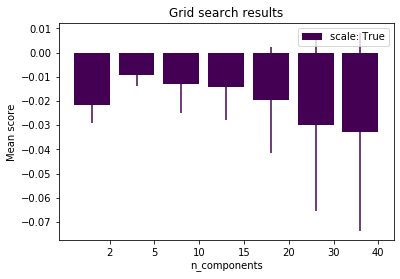

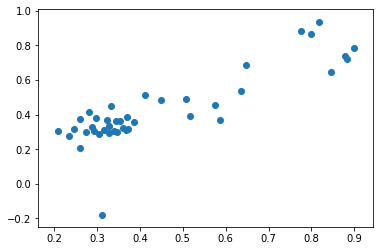

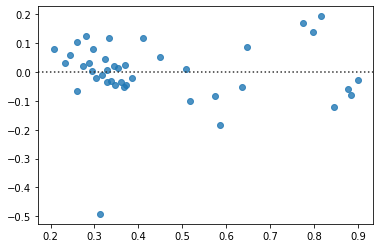

In [ ]:
for i in range(30):
    pls_regression(df4, 4)
    pls_regression(df5, 5)
    pls_regression(df6, 6)
    randomforest_regression(df4, 4)
    randomforest_regression(df5, 5)
    randomforest_regression(df6, 6)
    xgb_regression(df4, 4)
    xgb_regression(df5, 5)
    xgb_regression(df6, 6)
    i = i + 1

In [27]:
df.shape

(205, 2107)

In [28]:
df1.iloc[:,2102].describe()

count    212.000000
mean      19.501639
std       11.941709
min        0.900000
25%       10.535000
50%       18.175000
75%       26.967500
max       54.770000
Name: Ash, dtype: float64

In [29]:
df1.iloc[:,2103].describe()

count    212.000000
mean       3.269170
std        6.021883
min        0.020000
25%        0.670000
50%        1.000000
75%        1.860000
max       33.070000
Name: Moisture, dtype: float64

In [30]:
df1.iloc[:,2104].describe()

count    212.000000
mean      21.151962
std        9.745437
min       -0.540000
25%       14.537500
50%       18.105000
75%       25.347500
max       47.860000
Name: Volatile matter, dtype: float64

In [31]:
df1.iloc[:,2105].describe()

count    212.000000
mean      56.071899
std       11.024392
min       15.860000
25%       50.640000
50%       56.670000
75%       63.692500
max       78.210000
Name: Fixed carbon, dtype: float64

In [32]:
df1.iloc[:,2106].describe()

count    212.000000
mean      25.959933
std        4.985331
min       12.213600
25%       22.379980
50%       26.267247
75%       29.990297
max       35.605964
Name: gross calorific value (MJ/Kg), dtype: float64

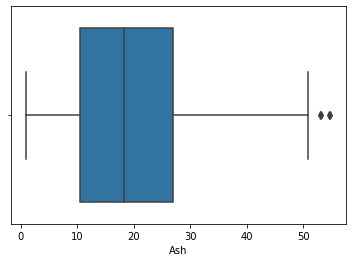

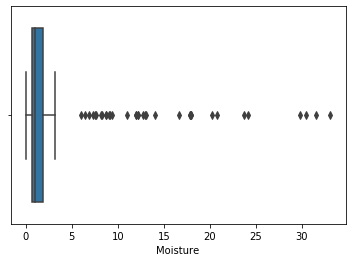

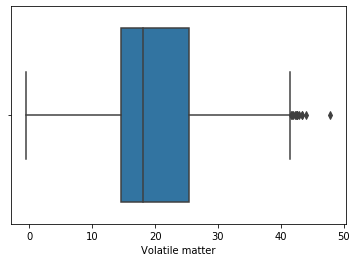

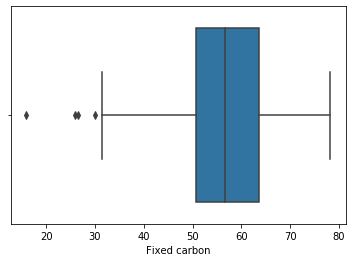

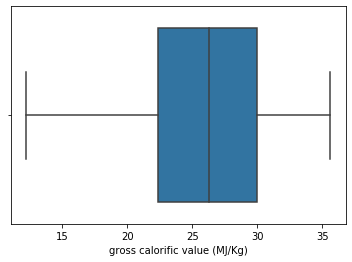

In [33]:
(sns.boxplot(x=df1.iloc[:,-5]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-4]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-3]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-2]))
pyplot.show()
(sns.boxplot(x=df1.iloc[:,-1]))
pyplot.show()